# North Gravity - Sample Problem

2 csv files:
- one with 8 time series fo stock data (*equities.csv*)
- another one with currency data (*currencies.csv*)

*What we needed in our pipeline was to fuse the two sources in the singe data set and then apply it for analyses.
Please try to process them, filter the errors (if any), fuse, visualise and do some analyses. You can propose your analysis, or simply do a regplot between the two most correlated variables.*

After comparing with https://www.xe.com/currencycharts/?from=GBP&to=CHF&view=10Y data, the series seem to be in USD


The Notebook is divided in the followong parts:
1. **[EDA, Cleaning, Normalizing and Merging](#first-bullet)**
    - [Stocks](#first-first-bullet)
    - [Currencies](#first-second-bullet)
    - [Merging](#first-third-bullet)
2. **[Analysis](#second-bullet)**
    - [Visualization of trends (moving average)](#second-first-bullet)
    - [Correlations](#second-second-bullet)
    - [Autocorrelations](#second-third-bullet)
    - [Cointegrations](#second-forth-bullet)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Set the size of all figures from matplotlib
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 10]

from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller, coint
from statsmodels.tsa.arima_model import ARMA, ARIMA

C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1. EDA & Cleaning <a class="anchor" id="first-bullet"></a>
### Stocks <a class="anchor" id="first-first-bullet"></a>

In [2]:
#Load the equities csv files
stocks = pd.read_csv('equities.csv', parse_dates=[2], index_col=[2])
stocks.drop(columns=['Unnamed: 0'], inplace=True)
#Turn symbol into category type
stocks['Symbol'] = stocks['Symbol'].astype('category')

print(stocks.head(10), stocks.tail(10))
print('\n', stocks.info())

print('Companies list: {} companies {}'.format(len(stocks['Symbol'].unique().tolist()),
                                               stocks['Symbol'].unique().tolist()))

print('\n', stocks.describe())

           Symbol   AdjClose
Date                        
2010-01-01     BP  38.947311
2010-01-08     BP  40.163998
2010-01-15     BP  38.758614
2010-01-22     BP  37.301182
2010-01-29     BP  34.796219
2010-02-05     BP  35.655064
2010-02-12     BP  35.616032
2010-02-19     BP  34.936859
2010-02-26     BP  36.390083
2010-03-05     BP  37.387524            Symbol   AdjClose
Date                        
2018-03-09    XOM   0.000000
2018-03-16    XOM  72.762482
2018-03-23    XOM  73.861343
2018-03-30    XOM  75.257195
2018-04-06    XOM  76.445152
2018-04-13    XOM  78.623077
2018-04-20    XOM  80.048630
2018-04-27    XOM   0.000000
2018-05-04    XOM  80.900002
2018-05-11    XOM  81.008896
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3496 entries, 2010-01-01 to 2018-05-11
Data columns (total 2 columns):
Symbol      3496 non-null category
AdjClose    3496 non-null float64
dtypes: category(1), float64(1)
memory usage: 58.4 KB

 None
Companies list: 8 companies ['BP', 'CVX', 'MRO', '

                   BP        CVX        MRO        NRG        UAL        VLO  \
Date                                                                           
2010-01-01  38.947311  58.473110  15.738274   0.000000  13.550000  14.025059   
2010-01-08  40.163998  58.635250  15.410497  21.706005  13.930000  13.521790   
2010-01-15  38.758614  56.195488  15.183938  21.660875  13.130000  13.988054   
2010-01-22  37.301182  53.984234  14.542841  22.310705  12.630000  13.640208   
2010-01-29  34.796219  52.605873  13.911383  19.946058  12.360000  13.403373   
2010-02-05  35.655064  52.871250  13.896920  20.054369  15.660000  13.321960   
2010-02-12  35.616032  54.264332  14.436794  20.370251  14.980000  13.092526   
2010-02-19  34.936859  53.660023  14.147383  19.918985  15.660000  12.954265   
2010-02-26  36.390083  54.381844  14.460249  20.126568  18.059999  13.971305   
2010-03-05  37.387524  55.059013  15.481948  20.704187  19.170000  15.151663   

                  XLE        XOM  
Date

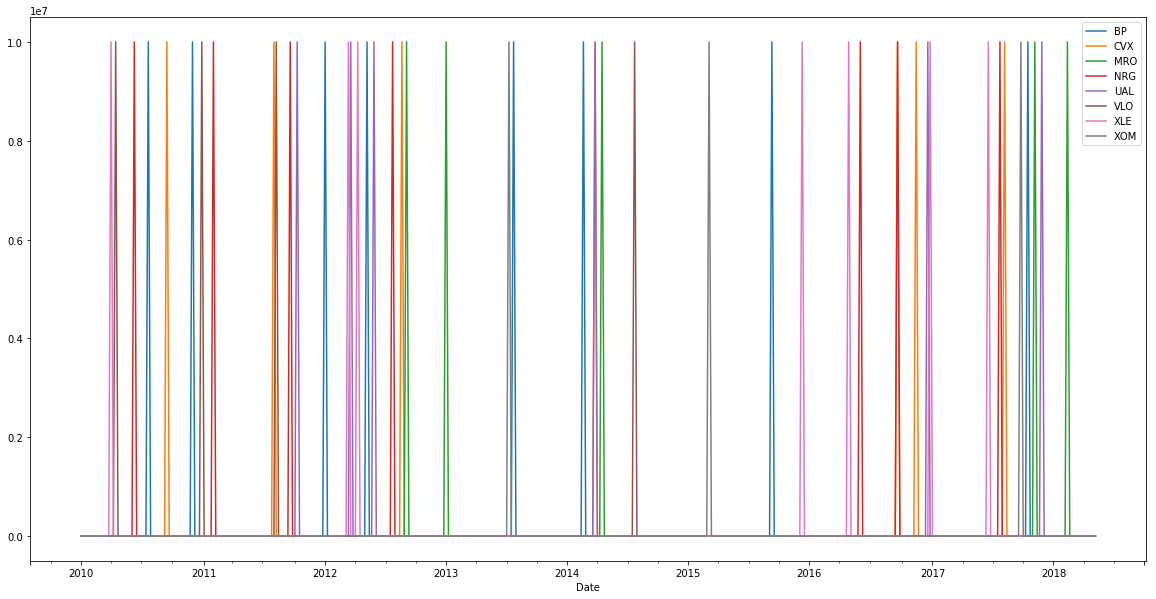

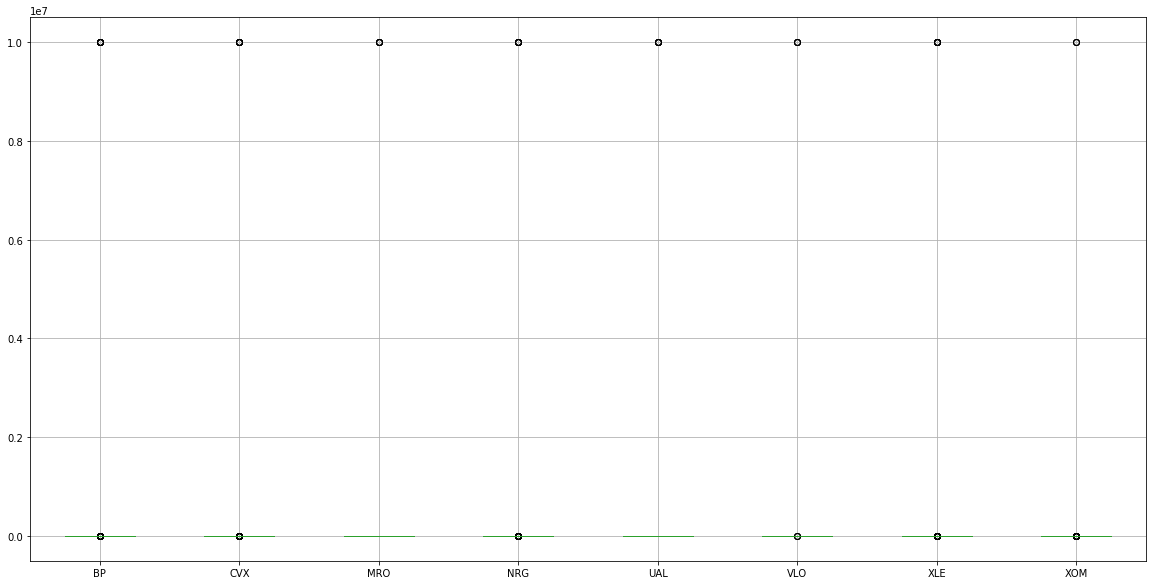

In [4]:
#Pivot the Symbol column into a column index
stocks_pivoted = stocks.set_index([stocks.index, 'Symbol']).unstack(['Symbol'])
#Flatten the columns index
stocks_pivoted.columns = [j for i,j in stocks_pivoted.columns]

print(stocks_pivoted.head(10))
print(stocks_pivoted.info())
print('\n', stocks_pivoted.describe())

#Visualisation of the raw stock time series
_ = stocks_pivoted.plot()
plt.show()

# Visualisation of the time series as boxplots
_ = stocks_pivoted.boxplot()
plt.show()

- 8 different companies, no NaN values after pivoting
- very high outliers (10^7 compared to 10-100 values)  -> to clean
- 0 values that are not supposed to be zeros (a stock cannot go from 80 to 0) -> to clean

In [5]:
def clean_df(dataframe, sep=False):
    """Takes as arguments the dataframe to clean from very high wrong values
    and from the zero (impossible for stocks and currencies), 
    by replacing them by NaN values first and then interpolating their values linearly
    or taking the following value if it's the first value in the series"""

    #Replace the wrong high values defined as above 5* IQR above the 75% percentile by NaN values
    for col in dataframe.columns:
        percentiles = np.percentile(dataframe[col], [25, 75])
        df_cleaned = dataframe[dataframe < (percentiles[1] + 5*(percentiles[1]-percentiles[0]))].replace([True], [np.nan])

    #Replace the 0 values by NaN values (if any)
    df_cleaned = df_cleaned.replace([0], [np.nan])
    print('Number of NaN after cleaning (outliers & zeros): \n{}'.format(df_cleaned.isnull().sum()))

    #Interpolate the NaN value linearly
    df_cleaned = df_cleaned.interpolate('linear')

    #Fill the first NaN value of series (if so) with next value
    df_cleaned = df_cleaned.fillna(method='bfill')
    print('Number of NaN after interpolation: \n{}'.format(df_cleaned.isnull().sum()))

    if sep == False:
        #Visualisation of the raw time series with no outliers
        _ = df_cleaned.plot()
        _ = plt.title("Evolution of the values after cleaning wrong high and zero values")
        _ = plt.ylabel('Value')
        plt.show()
        
    else:  #time series plotting on separated plots instead of same plot
        #Visualisation of the raw time series with no outliers on separated plots
        for col in df_cleaned.columns:
            _ = df_cleaned[col].plot()
            _ = plt.title('{}'.format(col))
            plt.show()
      
    # Visualisation of the time series as boxplots with no outliers
    _ = df_cleaned.boxplot()
    _ = plt.title("Boxplots of the value after cleaning wrong high and zero values")
    plt.show()
    
    #Print statistics of dataset
    print(df_cleaned.describe())        
    
    return df_cleaned

Number of NaN after cleaning (outliers & zeros): 
BP     34
CVX    34
MRO    19
NRG    38
UAL    26
VLO    23
XLE    28
XOM    28
dtype: int64
Number of NaN after interpolation: 
BP     0
CVX    0
MRO    0
NRG    0
UAL    0
VLO    0
XLE    0
XOM    0
dtype: int64


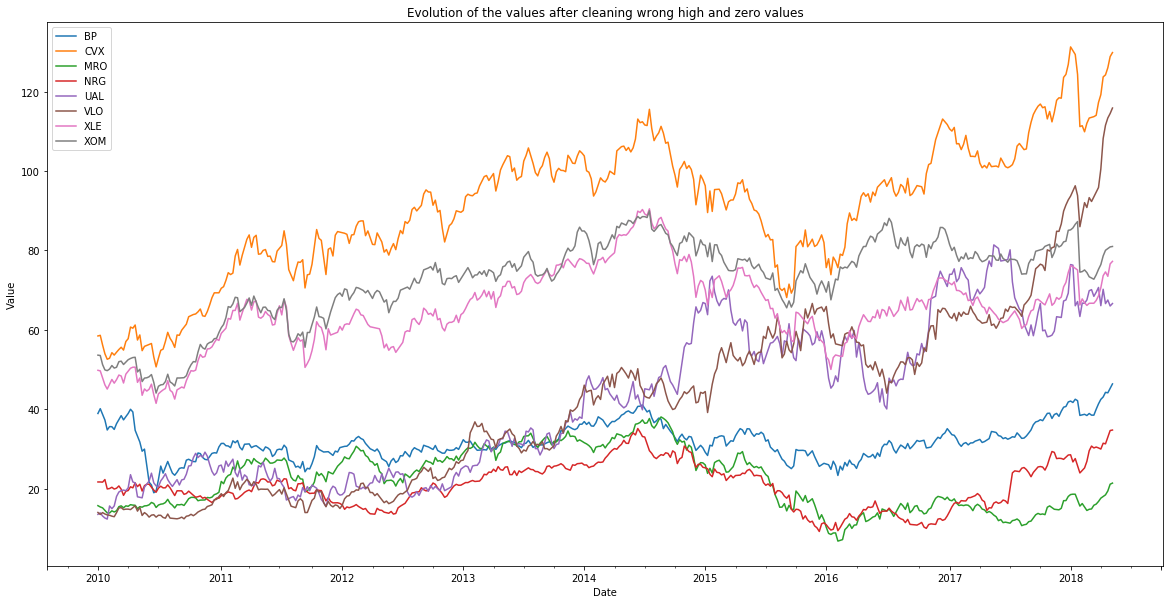

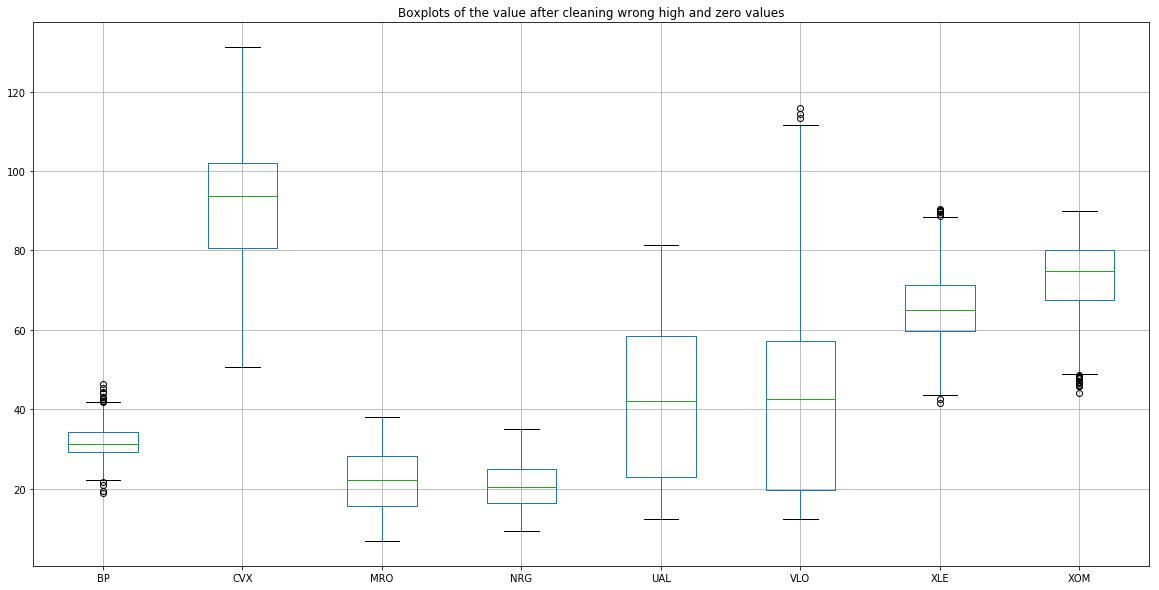

               BP         CVX         MRO         NRG         UAL         VLO  \
count  437.000000  437.000000  437.000000  437.000000  437.000000  437.000000   
mean    31.860495   90.649613   22.241237   20.726907   41.949451   41.629219   
std      4.413279   17.053693    7.546261    5.677977   19.246847   22.831918   
min     18.984409   50.683510    6.816562    9.239765   12.360000   12.426952   
25%     29.331244   80.545864   15.677272   16.525442   23.059999   19.709278   
50%     31.247407   93.815353   22.183233   20.370251   42.000000   42.483036   
75%     34.291817  101.942871   28.223667   24.853624   58.529999   57.133862   
max     46.400002  131.263321   38.083122   35.163895   81.410004  115.870003   

              XLE         XOM  
count  437.000000  437.000000  
mean    65.170822   72.603468  
std      9.828314   10.478832  
min     41.502258   44.087730  
25%     59.831059   67.578644  
50%     65.023064   74.926254  
75%     71.331741   80.117035  
max     90.487

In [6]:
stocks_cleaned = clean_df(stocks_pivoted)

                  BP       CVX       MRO       NRG       UAL       VLO  \
Date                                                                     
2010-01-01  0.728159  0.096669  0.285344  0.480874  0.017234  0.015449   
2010-01-08  0.772538  0.098682  0.274860  0.480874  0.022737  0.010584   
2010-01-15  0.721276  0.068404  0.267614  0.479133  0.011151  0.015091   
2010-01-22  0.668115  0.040962  0.247110  0.504200  0.003910  0.011729   
2010-01-29  0.576745  0.023857  0.226914  0.412986  0.000000  0.009439   

                 XLE       XOM  
Date                            
2010-01-01  0.169960  0.208168  
2010-01-08  0.167074  0.206159  
2010-01-15  0.131928  0.156267  
2010-01-22  0.095084  0.127136  
2010-01-29  0.073521  0.123118  


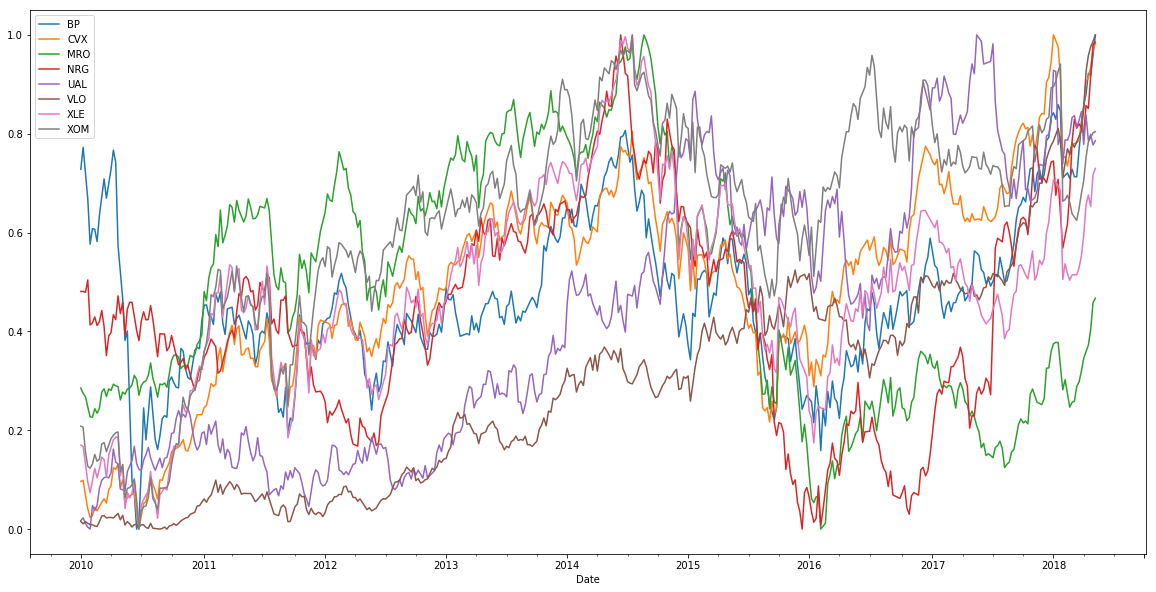

In [7]:
#Scale the values between (0,1)
scaler = MinMaxScaler(feature_range=(0,1))

stocks_scaled = scaler.fit_transform(stocks_cleaned.values)
stocks_scaled = pd.DataFrame(stocks_scaled, columns=stocks_cleaned.columns, index=stocks_cleaned.index)
print(stocks_scaled.head())

stocks_scaled.to_csv('stocks_cleaned_scaled.csv')

#Plot scaled dataframe
_ = stocks_scaled.plot()
plt.show()

### Currencies <a class="anchor" id="first-second-bullet"></a>

               BGN     BRL     CAD      CHF      EUR     PLN     NOK
raw_date                                                            
2010-08-29  0.0000  1.7604  1.0609  1.02290  0.78660  3.1374  6.2759
2010-09-05  1.5239  1.7239  1.0566  1.01630  0.77918  3.0793  6.1470
2010-09-12  0.0000  1.7184  1.0309  1.02320  0.78585  3.0914  6.1894
2010-09-19  1.4975  1.7166  1.0268  1.01150  0.76570  3.0338  6.0988
2010-09-26  0.0000  1.7168  1.0290  0.98143  0.74560  2.9647  5.9257
2010-10-03  0.0000  1.6783  1.0262  0.97793  0.72854  2.8683  5.8575
2010-10-10  0.0000  1.6862  1.0212  0.96728  0.72077  2.8662  5.8383
2010-10-17  0.0000  1.6587  1.0054  0.95273  0.70977  2.7717  5.7438
2010-10-24  0.0000  1.6933  1.0262  0.97122  0.71767  2.8492  5.8440
2010-10-31  0.0000  1.7059  1.0211  0.98925  0.72166  2.8736  5.9118                BGN     BRL     CAD           CHF      EUR     PLN     NOK
raw_date                                                                 
2018-02-25  0.0000  3.27

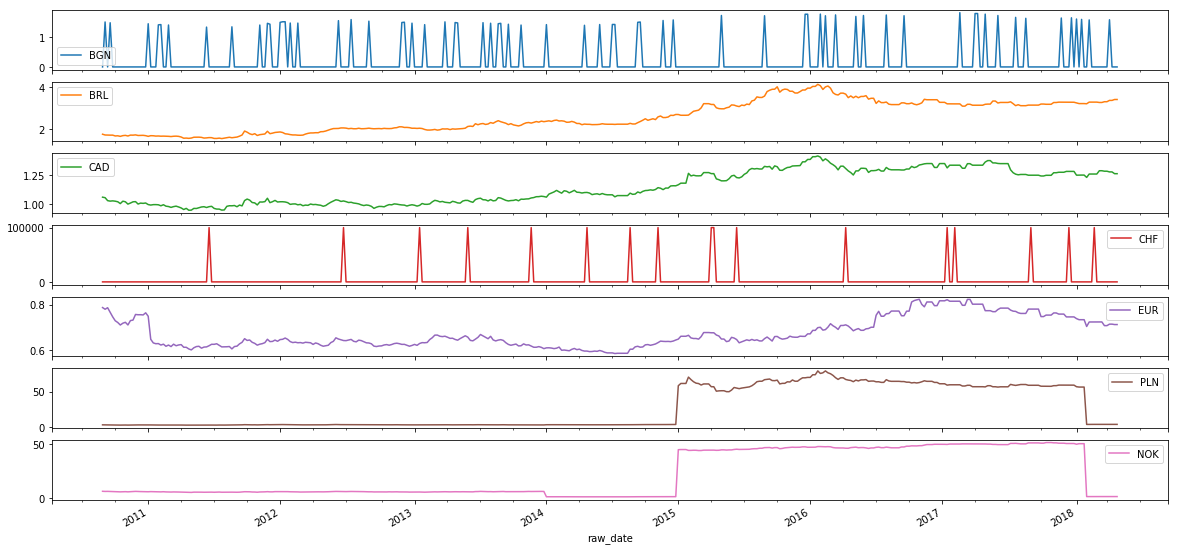

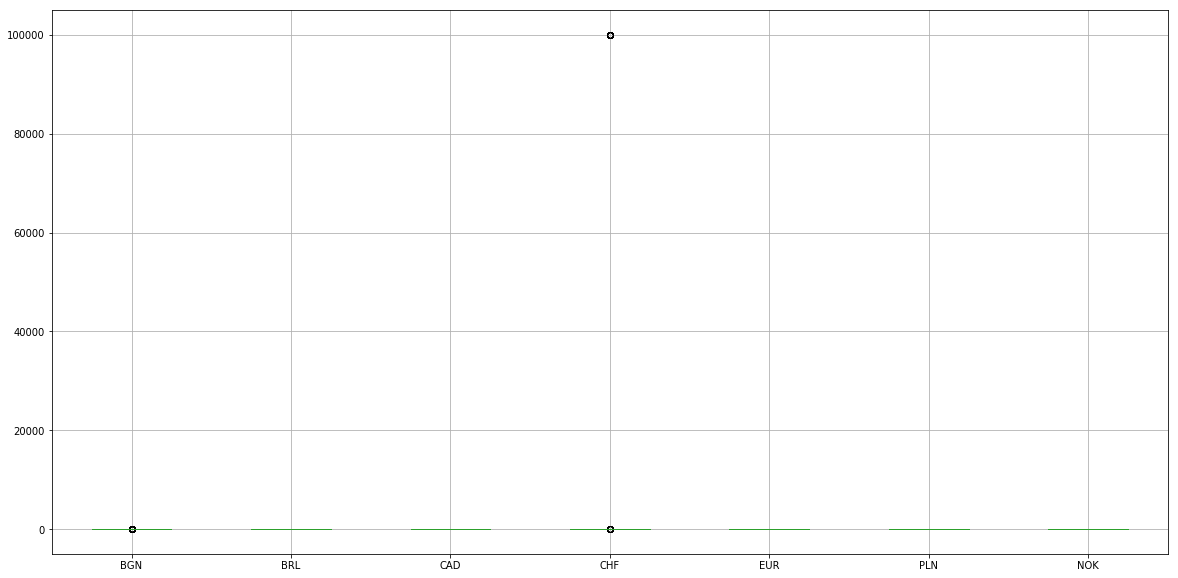


               BGN         BRL         CAD            CHF         EUR  \
count  401.000000  401.000000  401.000000     401.000000  401.000000   
mean     0.254553    2.581770    1.146115    4240.307443    0.673922   
std      0.581933    0.718325    0.141365   20173.617502    0.065360   
min      0.000000    1.553500    0.948030       0.766300    0.584110   
25%      0.000000    2.007300    1.014700       0.920240    0.624360   
50%      0.000000    2.359800    1.098400       0.955690    0.647540   
75%      0.000000    3.206200    1.287900       0.979460    0.723050   
max      1.839500    4.121900    1.417100  100000.000000    0.823160   

              PLN         NOK  
count  401.000000  401.000000  
mean    26.841866   21.935486  
std     29.118020   21.348190  
min      2.648500    1.134000  
25%      3.163600    5.584900  
50%      3.412000    5.973300  
75%     59.386000   46.755000  
max     79.472000   51.423000  


In [22]:
#Load the currency csv file
currencies = pd.read_csv('currencies.csv', parse_dates=[0], index_col=[0])

print(currencies.head(10), currencies.tail(10))
print('\n', currencies.info())
print('Number of currencies : {}'.format(len(currencies.columns)))

#Visualisation of the raw currencies time series:
_ = currencies.plot(subplots=True)
plt.show()

# Visualisation of the time series as boxplots
_ = currencies.boxplot()
plt.show()

print('\n', currencies.describe())

- 7 different currencies, No NaN values
- EUR, CAD, BRL seem to be clean
- BGN, CHF have wrong high values -> clean
- PLN, NOK seems to have offsets -> clean

Number of NaN after cleaning (outliers & zeros): 
BGN    336
BRL      0
CAD      0
CHF     17
EUR      0
PLN      0
NOK      0
dtype: int64
Number of NaN after interpolation: 
BGN    0
BRL    0
CAD    0
CHF    0
EUR    0
PLN    0
NOK    0
dtype: int64


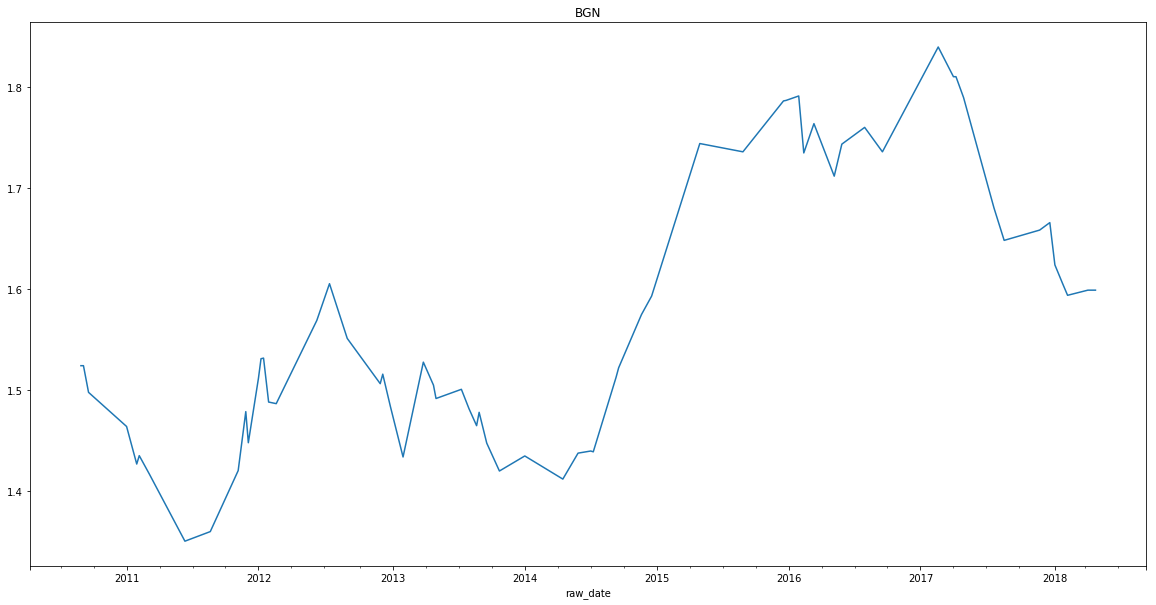

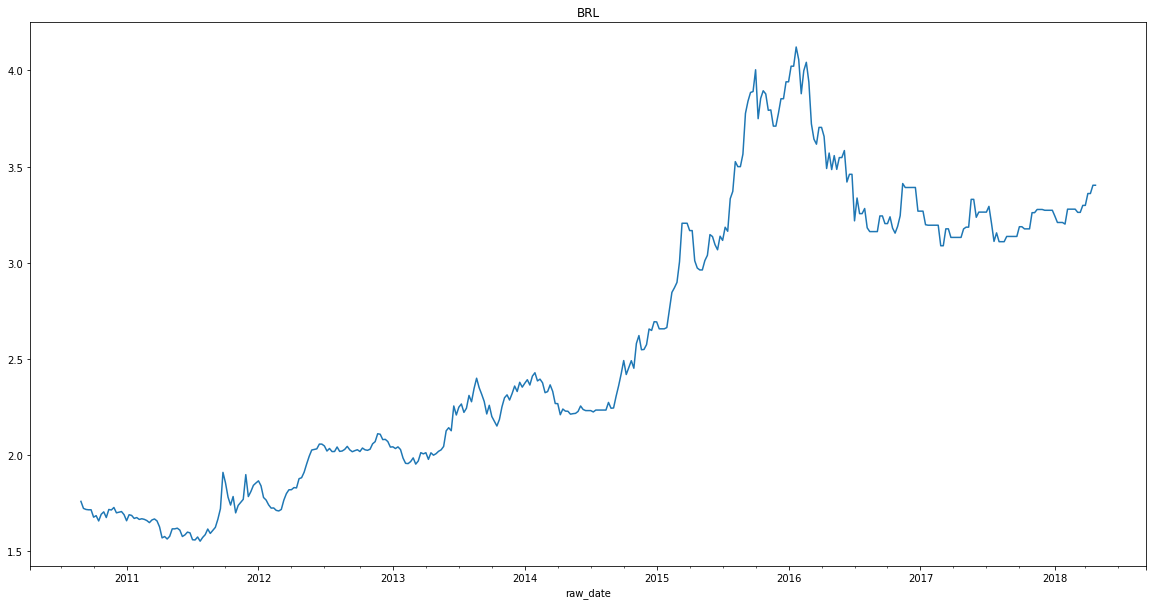

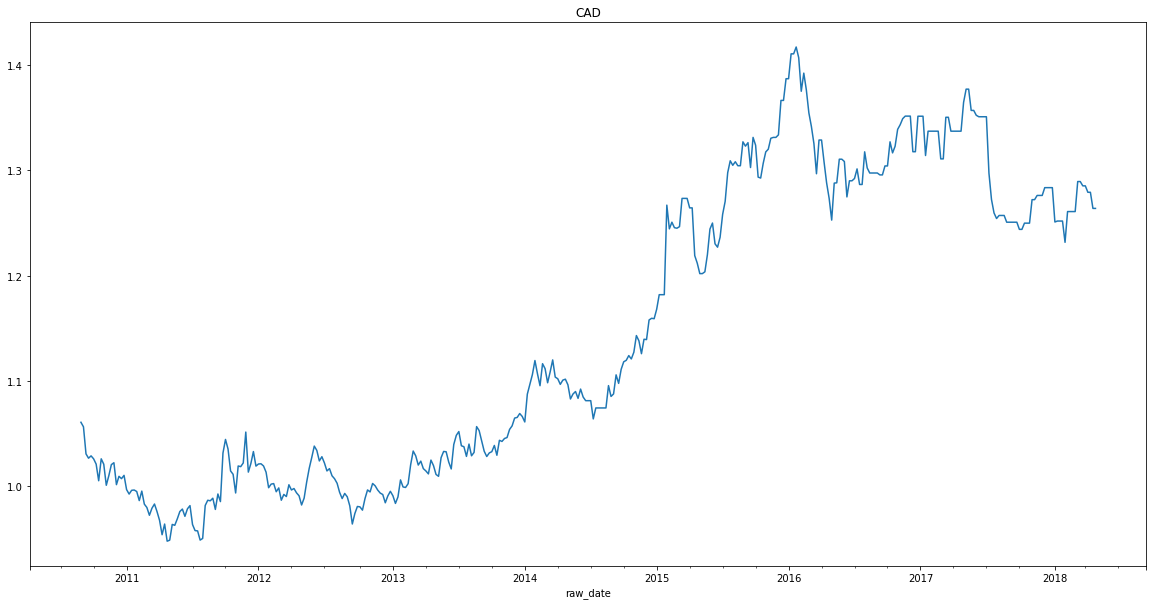

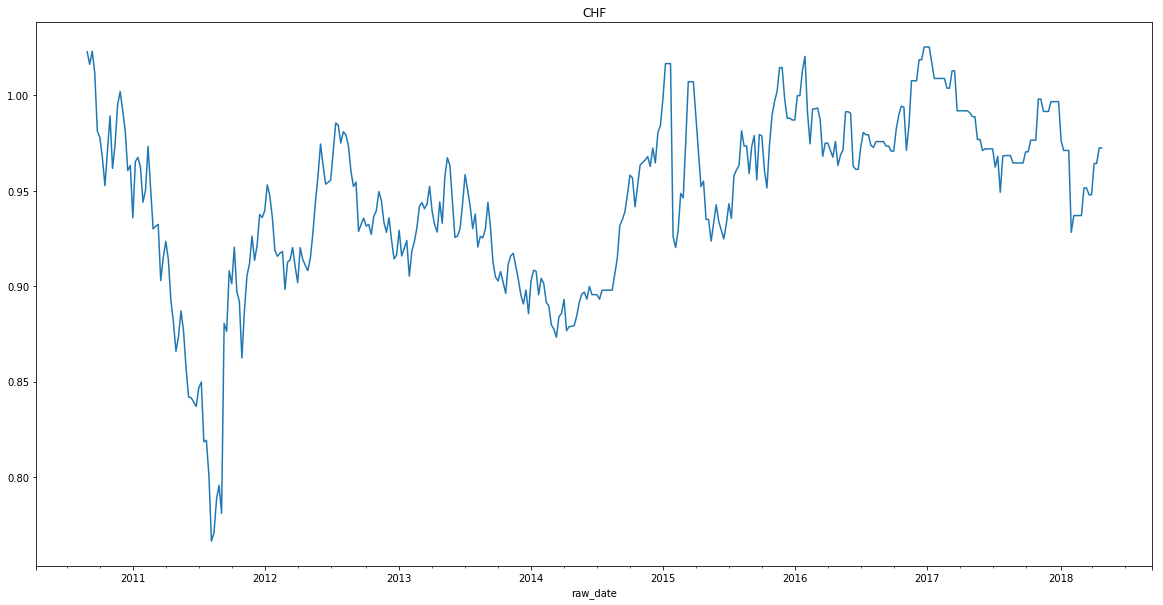

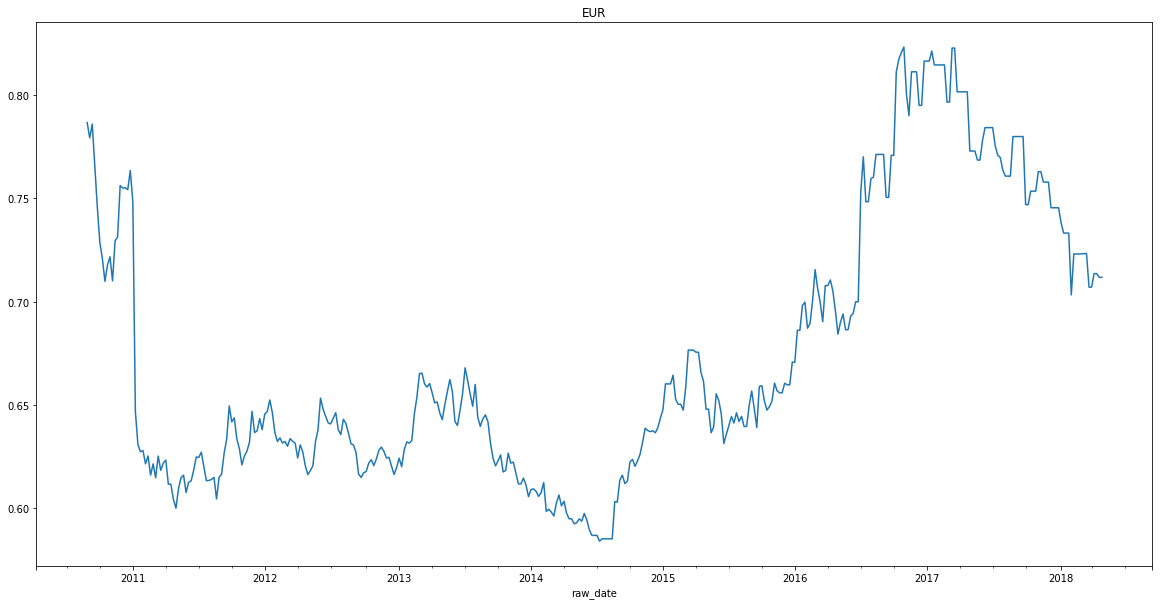

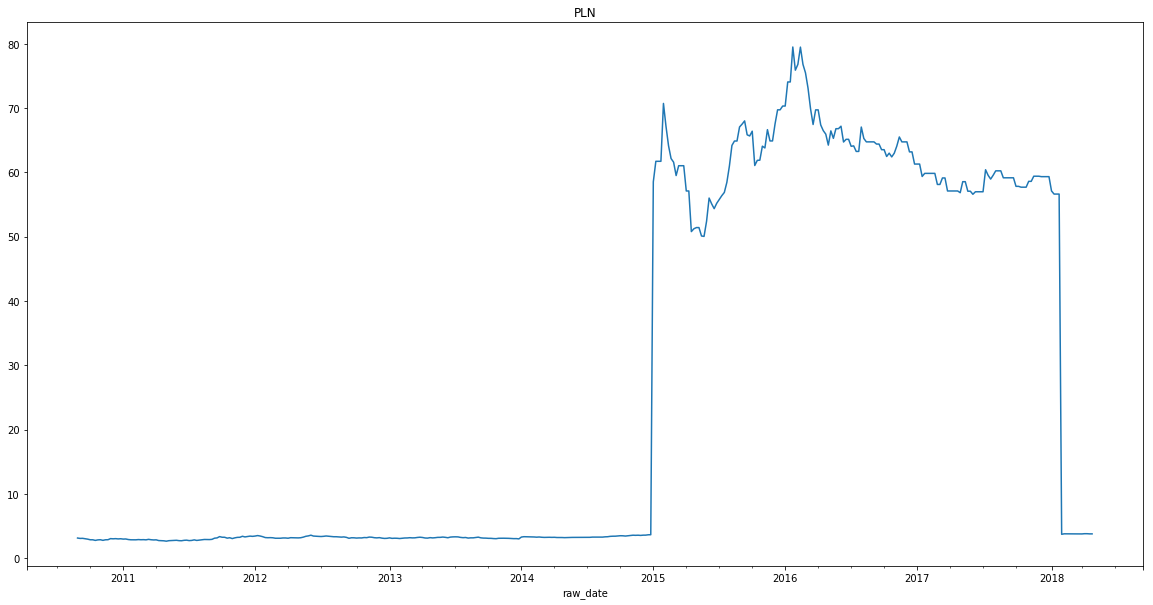

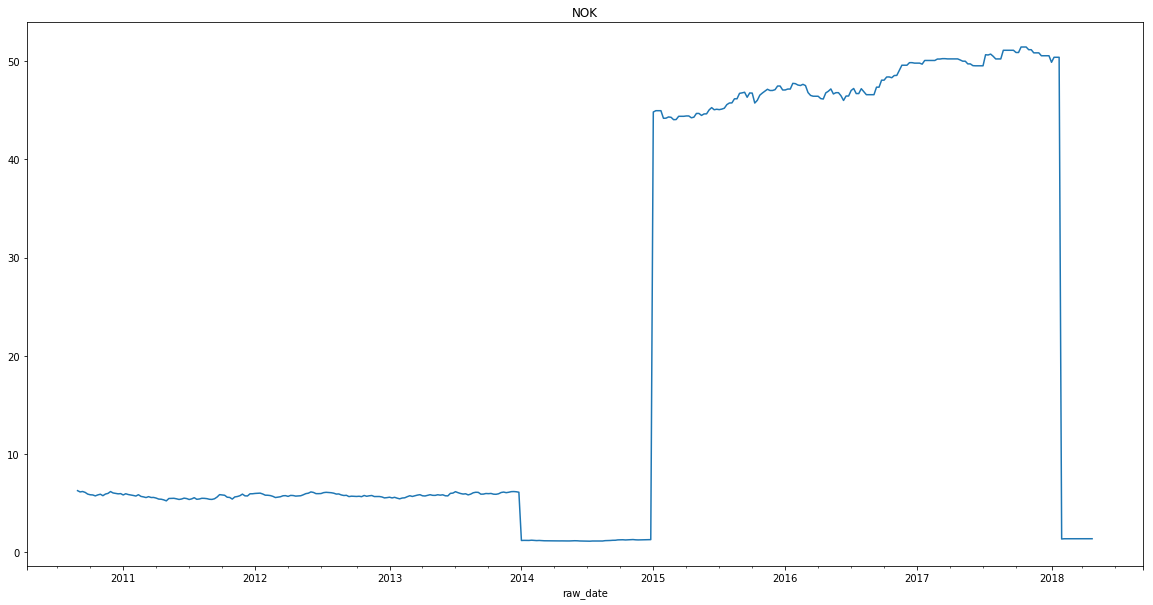

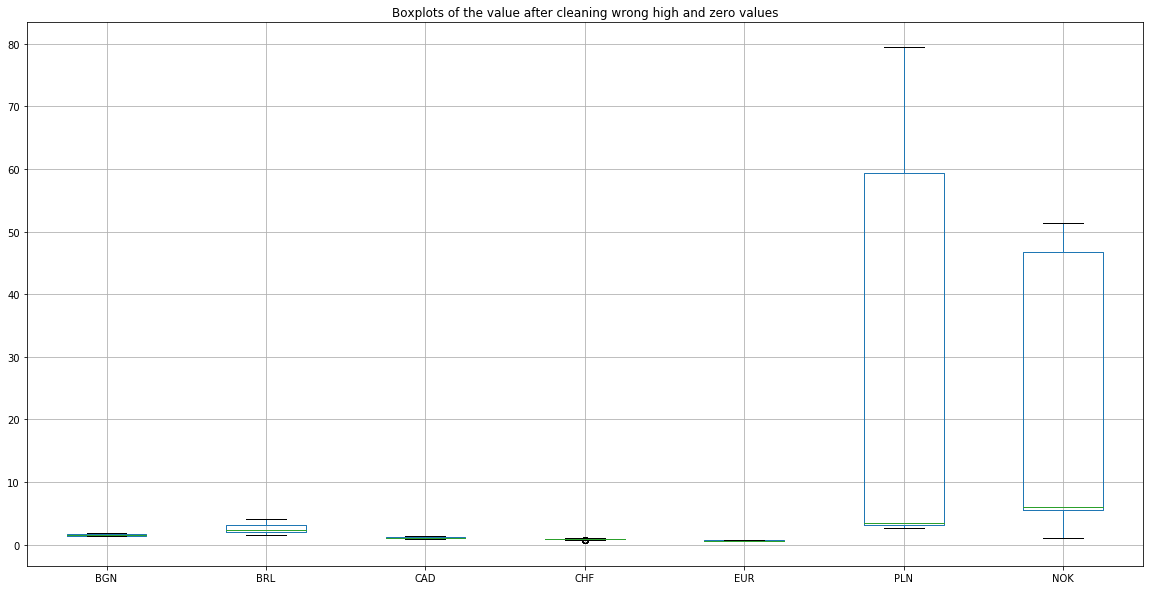

              BGN         BRL         CAD         CHF         EUR         PLN  \
count  401.000000  401.000000  401.000000  401.000000  401.000000  401.000000   
mean     1.580689    2.581770    1.146115    0.946104    0.673922   26.841866   
std      0.139902    0.718325    0.141365    0.045213    0.065360   29.118020   
min      1.350100    1.553500    0.948030    0.766300    0.584110    2.648500   
25%      1.463600    2.007300    1.014700    0.918230    0.624360    3.163600   
50%      1.548100    2.359800    1.098400    0.952360    0.647540    3.412000   
75%      1.736182    3.206200    1.287900    0.976010    0.723050   59.386000   
max      1.839500    4.121900    1.417100    1.025400    0.823160   79.472000   

              NOK  
count  401.000000  
mean    21.935486  
std     21.348190  
min      1.134000  
25%      5.584900  
50%      5.973300  
75%     46.755000  
max     51.423000  


In [23]:
currencies_cleaned = clean_df(currencies, sep=True)

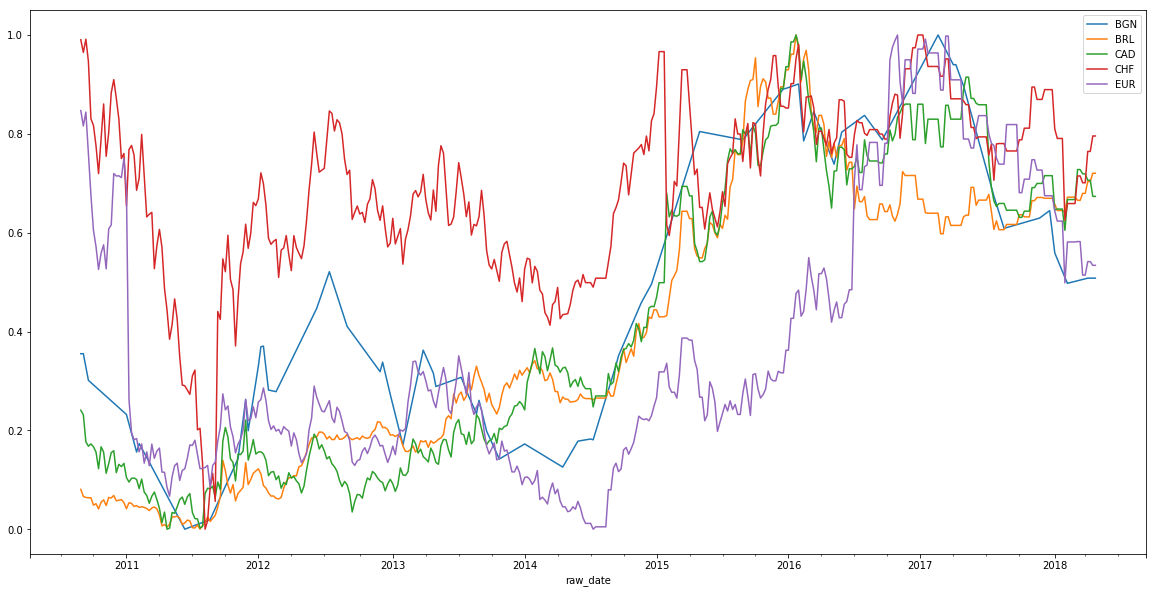

In [24]:
#Rescale to (0,1) the right series (all besides PLN & NOK)
scaler = MinMaxScaler(feature_range=(0,1))
currencies_scaled = scaler.fit_transform(currencies_cleaned.iloc[:, :-2].as_matrix().reshape(-1,5))
currencies_scaled = pd.DataFrame(currencies_scaled, columns=currencies_cleaned.iloc[:, :-2].columns,
                                index=currencies_cleaned.index)
_ = currencies_scaled.plot()
plt.show()

In [25]:
#Closer look on the problems with PLN and NOK !!
print(currencies_cleaned[['PLN', 'NOK']].loc['2014-12':'2015-02'])
print(currencies_cleaned[['PLN', 'NOK']].loc['2017-12':'2018-03'])
print(currencies_cleaned['NOK'].loc['2013-12':'2015-01-04'])

#Get the multiplication error
print('\n',
      currencies_cleaned[['PLN', 'NOK']].loc['2015-01-04'] / currencies_cleaned[['PLN', 'NOK']].loc['2014-12-28'])
print('\n',
      currencies_cleaned[['PLN', 'NOK']].loc['2018-01-28'] / currencies_cleaned[['PLN', 'NOK']].loc['2018-02-04'])


#Get the indices of min/max values during the uncorrect period
print('\nmax PLN ', currencies_cleaned['PLN'].loc['2015-01-04':'2018-01-28'].idxmax())
print('min PLN', currencies_cleaned['PLN'].loc['2015-01-04':'2018-01-28'].idxmin())

print('\nmax NOK 1st period', currencies_cleaned['NOK'].loc['2014-01-05':'2014-12-28'].idxmax())
print('min NOK 1st period', currencies_cleaned['NOK'].loc['2014-01-05':'2014-12-28'].idxmin())
print('\nmax NOK 2nd period', currencies_cleaned['NOK'].loc['2015-01-04':'2018-01-28'].idxmax())
print('min NOK 2nd period', currencies_cleaned['NOK'].loc['2015-01-04':'2018-01-28'].idxmin())

                PLN      NOK
raw_date                    
2014-12-07   3.5853   1.2885
2014-12-14   3.5882   1.2808
2014-12-21   3.6435   1.2859
2014-12-28   3.6523   1.2936
2015-01-04  58.5080  44.8070
2015-01-11  61.7040  44.9420
2015-01-18  61.7040  44.9420
2015-01-25  61.7040  44.9420
2015-02-01  70.6990  44.1700
2015-02-08  67.1440  44.1800
2015-02-15  64.1320  44.3050
2015-02-22  62.1350  44.2700
                PLN      NOK
raw_date                    
2017-12-03  59.3860  50.8280
2017-12-10  59.3180  50.5330
2017-12-17  59.3180  50.5330
2017-12-24  59.3180  50.5330
2017-12-31  59.3180  50.5330
2018-01-07  57.0960  49.8670
2018-01-14  56.6100  50.3780
2018-01-21  56.6100  50.3780
2018-01-28  56.6100  50.3780
2018-02-04   3.7190   1.3577
2018-02-11   3.7939   1.3812
2018-02-18   3.7939   1.3812
2018-02-25   3.7939   1.3812
2018-03-04   3.7939   1.3812
2018-03-11   3.7890   1.3775
2018-03-18   3.7890   1.3775
2018-03-25   3.7769   1.3789
raw_date
2013-12-01     6.1127
2013-12-08  

For the PLN and NOK, the standard deviation of the series are higher than the median (not the case for the other currencies & for the stock) -> way to detect this kind of problem on a series
- From 2015-01-04 to 2018-01-28 included (2018-02-04 next date), it seems to have a scale problem  -> the min/max for this period are (3.71405,4.12871) for PLN and (7.66252, 7.89484) for NOK  (source: xe.com)

- From 2014-01-05 to 2014-12-28 included for the NOK, the series have been reduced before being augmented -> the min/max for this period are (6.17633 ,6.80742)


Anyways, the data is in the end rescaled to (0,1) values  -> periods rescaling for the PLN and NOK series

In [26]:
def rescale_periods(series, min_max=(0,1), periods=[]):
    """Rescales the given periods of a series to the right amplitude specified by the tuple min_max
    using the MinMaxScaler from scikit-learn
    *args contains the periods to scale individually. If args=['entire'], the entire series is scaled in one shot"""
    
    #Create the scaler
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=min_max)
    
    series_rescaled = series
        
    for period in periods:

        #Period to scale
        to_scale = series.loc[period[0]:period[1]]

        #Plot the period to rescale
        _ = plt.plot(to_scale.index, to_scale)
        _ = plt.title('Period to rescale')
        plt.show()

        #Rescale the given period according to the specified min and max values
        period_scaled = scaler.fit_transform(to_scale.values.reshape(-1,1))
        print(to_scale.values.shape, period_scaled.shape)

        #Plot the rescaled period
        _ = plt.plot(series.loc[period[0]:period[1]].index, period_scaled)
        _ = plt.title('Rescaled period')
        plt.show()
        
        
        #Replace in the series the scaled part
        print(period_scaled.shape)
        series_rescaled.loc[period[0]:period[1]] = period_scaled.reshape(period_scaled.shape[0])

    return series_rescaled

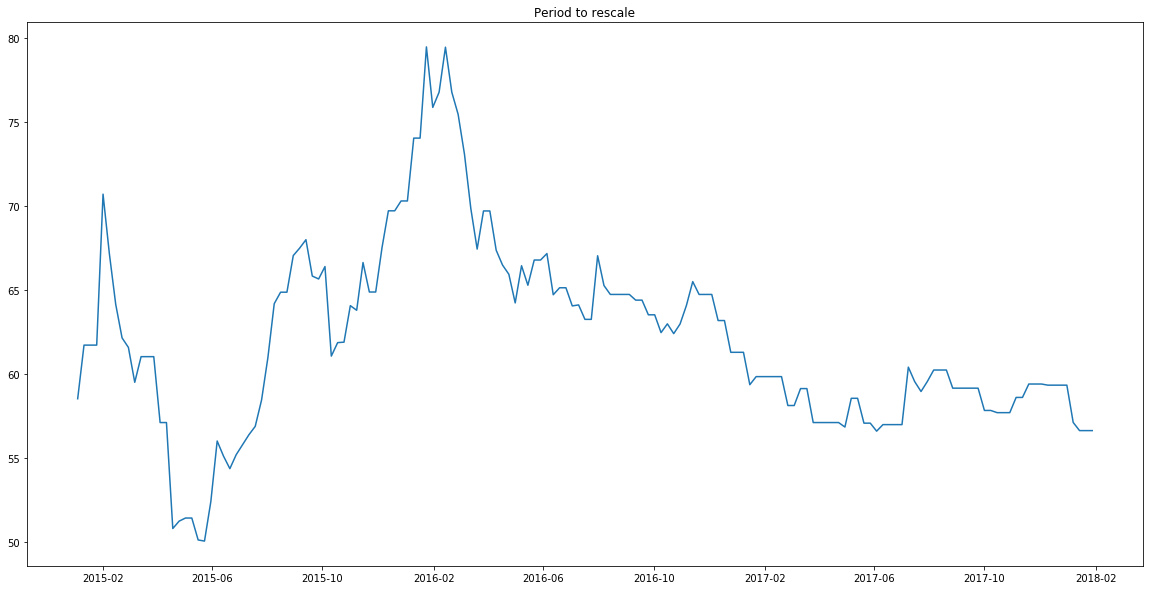

(161,) (161, 1)


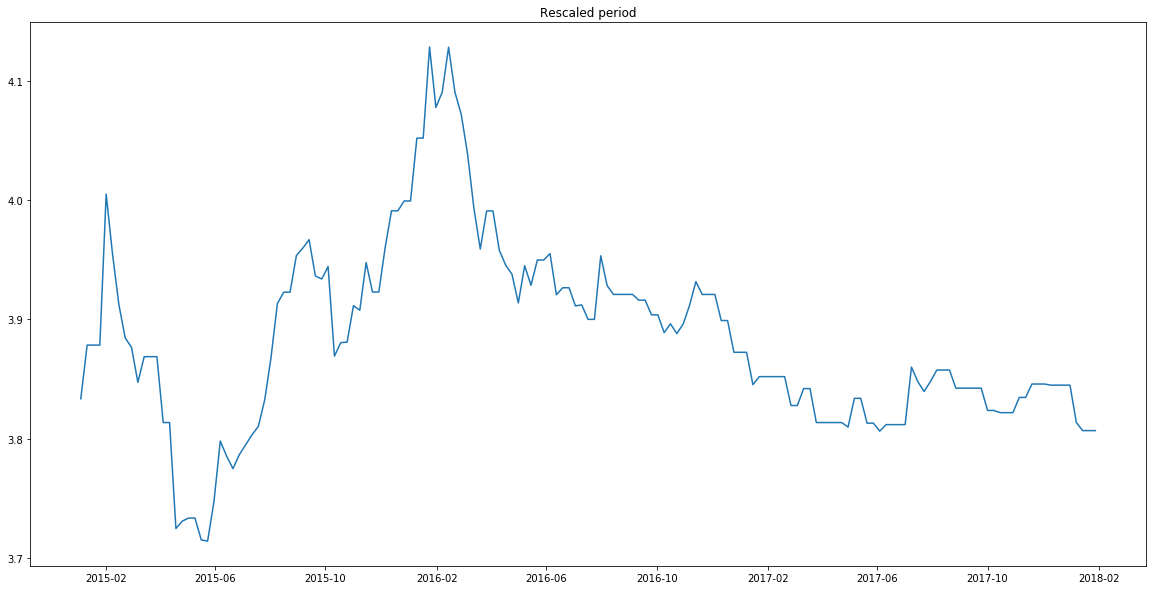

(161, 1)


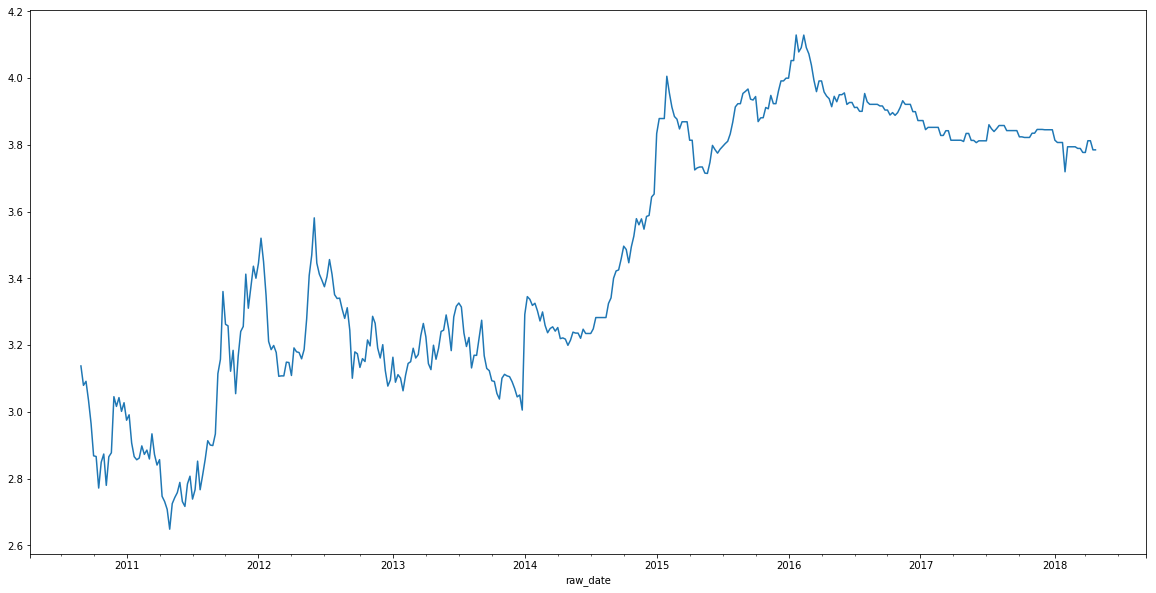

In [27]:
#Get the real USD/PLN series
pln_rescaled_real = rescale_periods(series=currencies_cleaned['PLN'], min_max=(3.71405,4.12871),
                              periods=[['2015-01-04','2018-01-28']])
_ = pln_rescaled_real.plot()
plt.show()

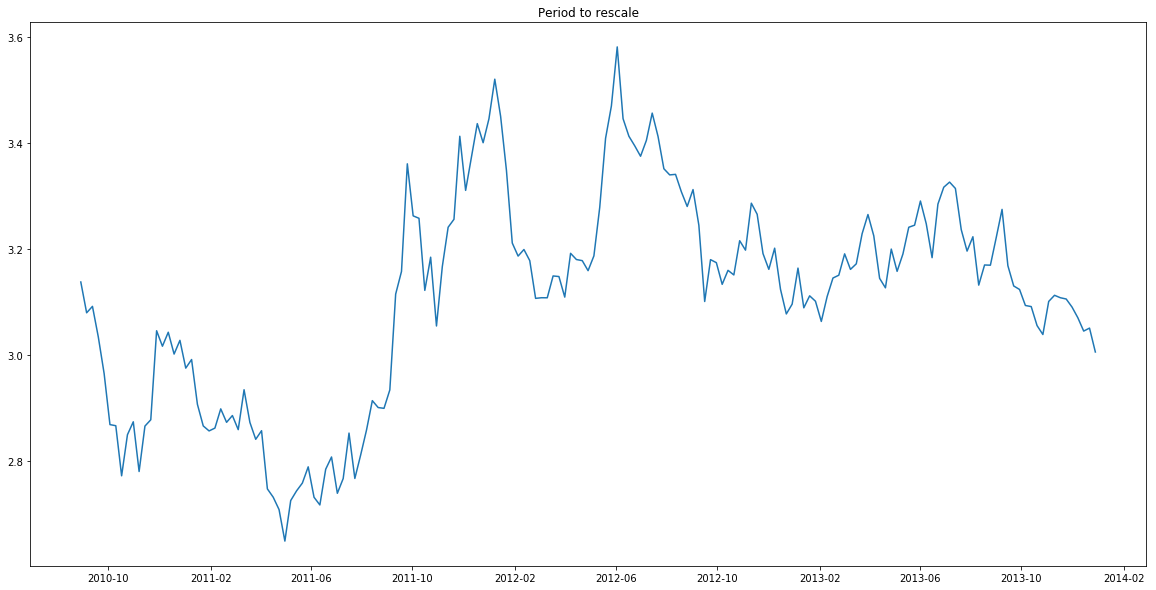

(175,) (175, 1)


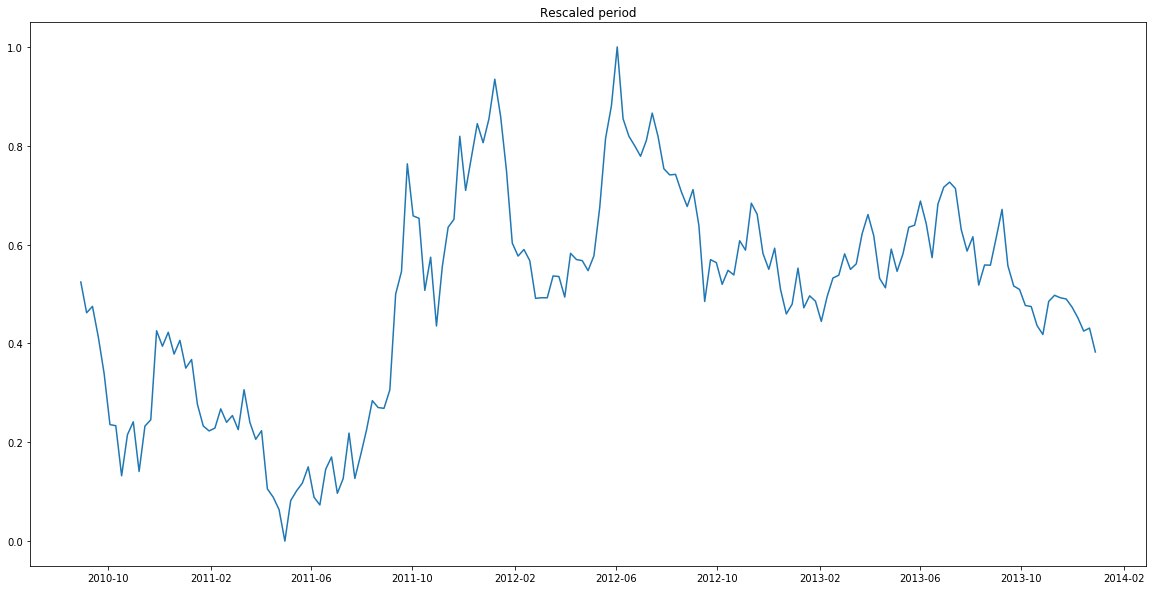

(175, 1)


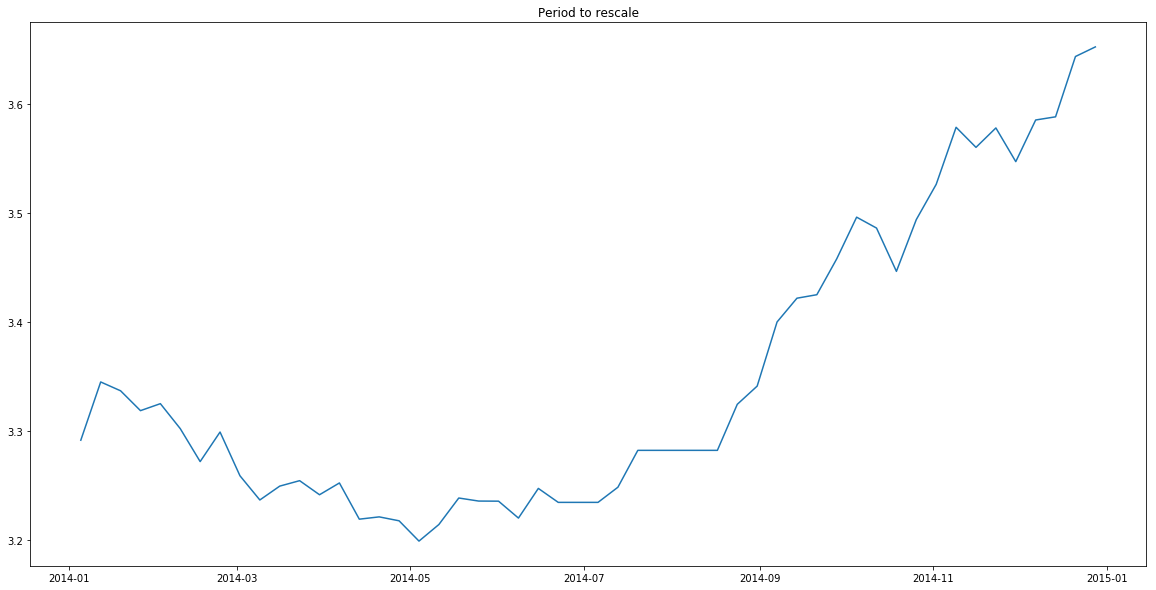

(52,) (52, 1)


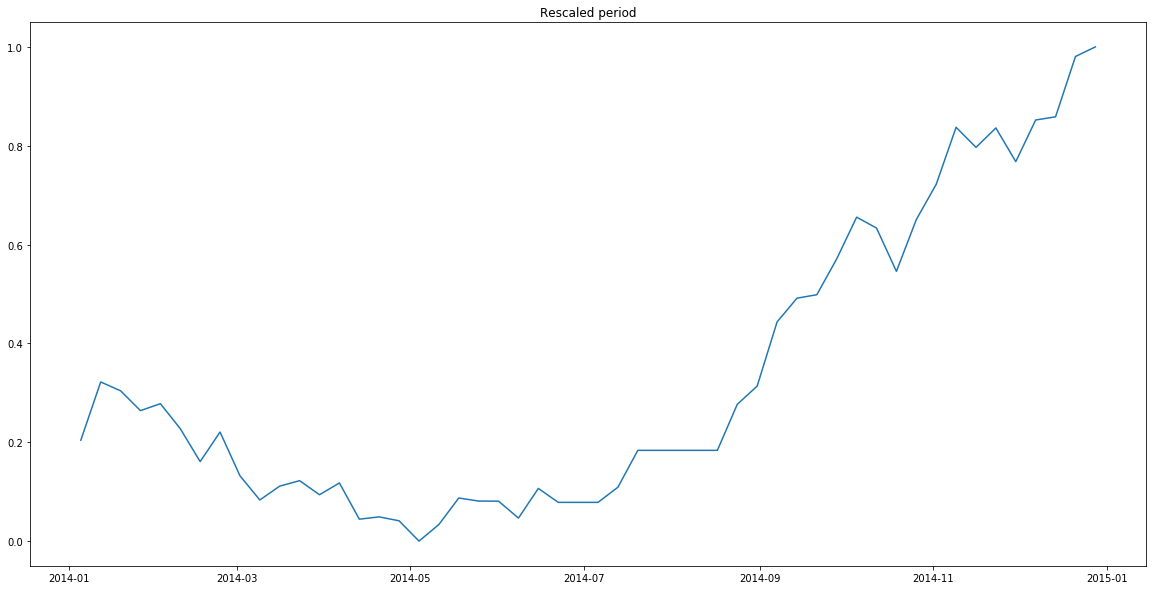

(52, 1)


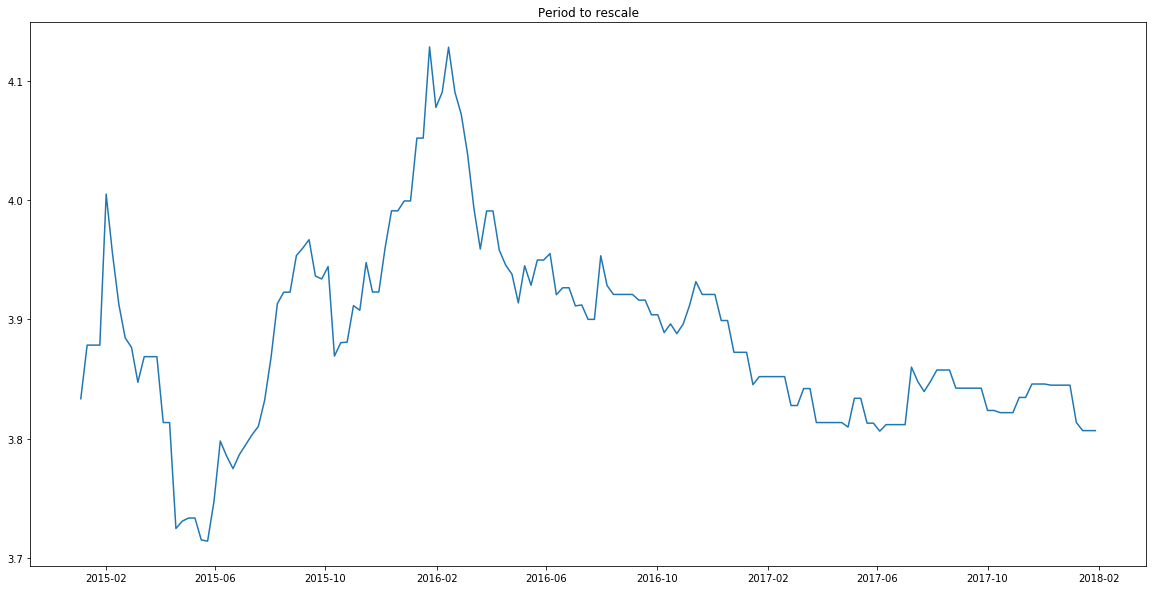

(161,) (161, 1)


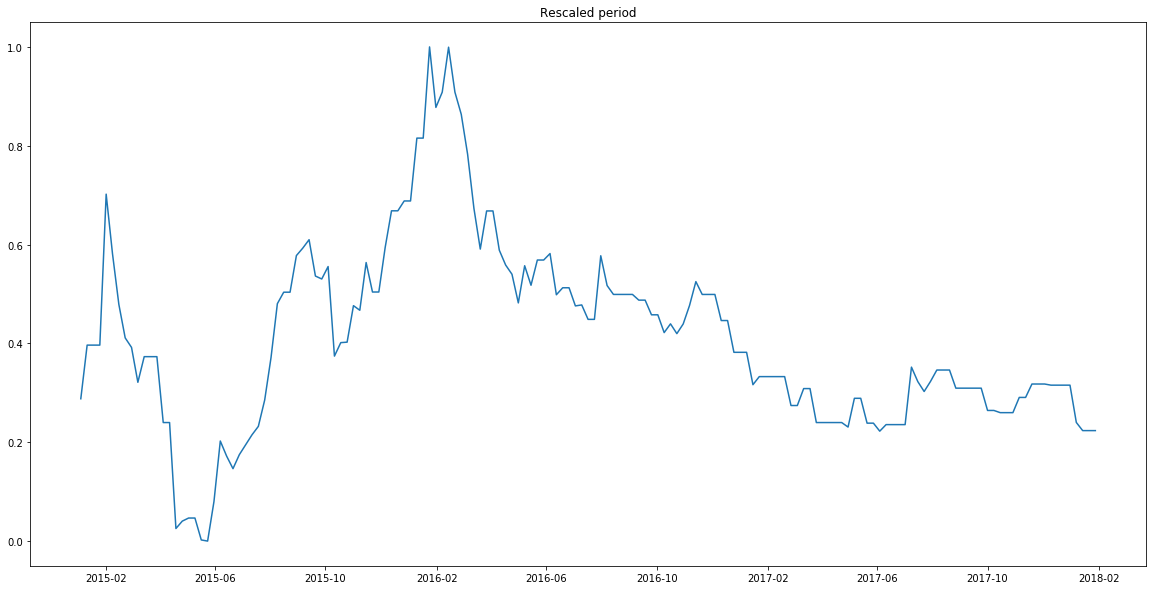

(161, 1)


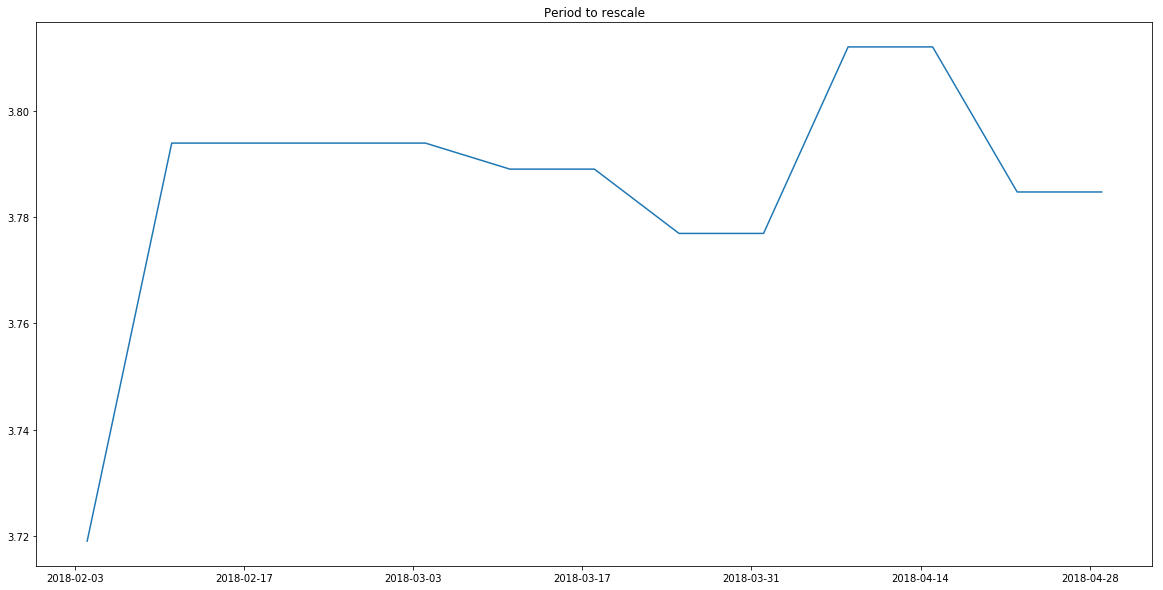

(13,) (13, 1)


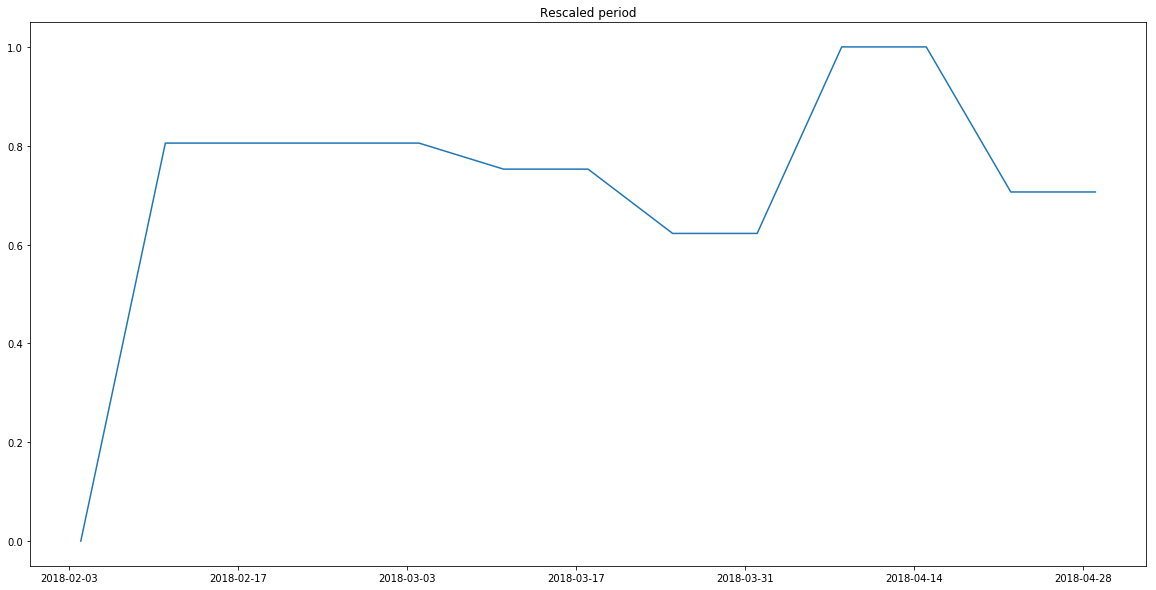

(13, 1)


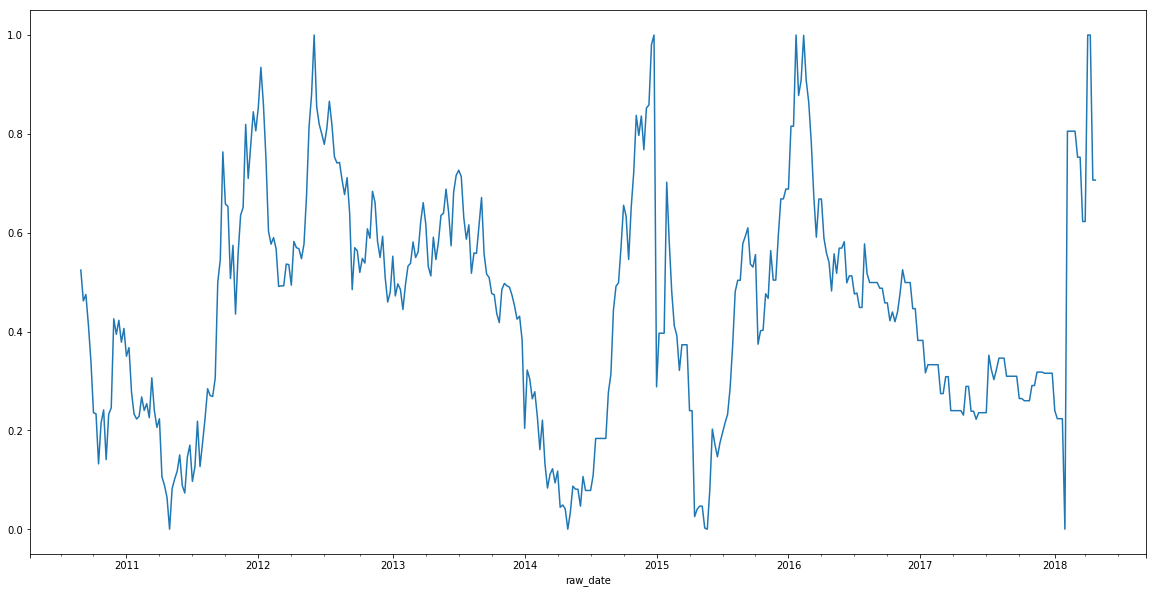

In [28]:
#Rescale the PLN series periods by periods to (0,1)
pln_rescaled = rescale_periods(series=currencies_cleaned['PLN'], min_max=(0,1),
                               periods=[['2010-08-29','2013-12-29'], ['2014-01-05', '2014-12-28'], ['2015-01-04','2018-01-28'], ['2018-02-04','2018-04-29']])
_ = pln_rescaled.plot()
plt.show()

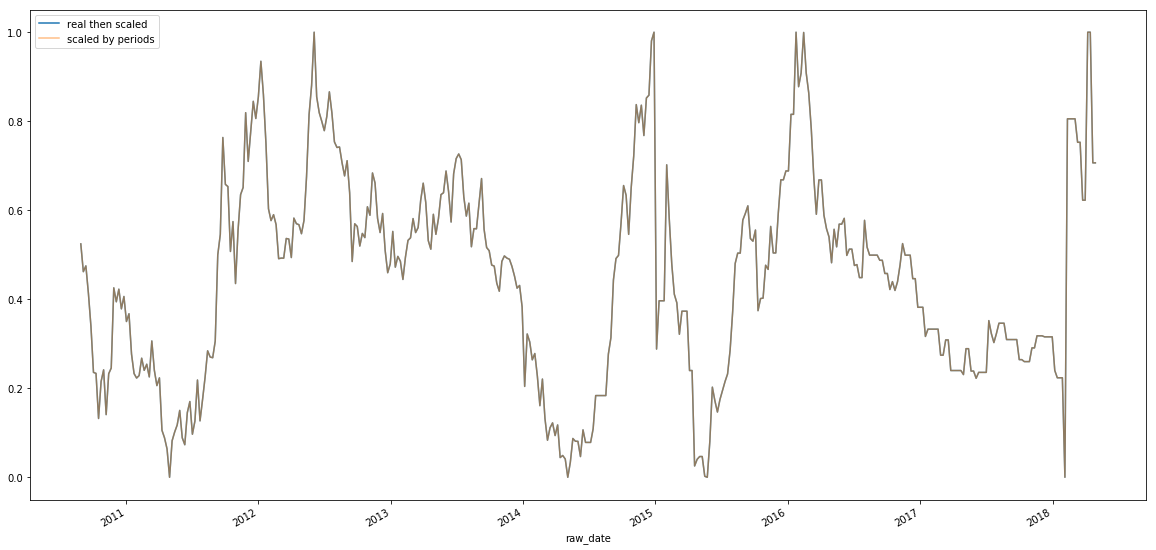

In [29]:
#Compare the rescaling to real then to (0,1) method with the direct rescaling to (0,1) method periods by periods
scaler = MinMaxScaler(feature_range=(0,1))
_ = plt.plot(pln_rescaled_real.index, scaler.fit_transform(pln_rescaled_real.values.reshape(-1,1)))
_ = pln_rescaled.plot(alpha=0.5)
_ = plt.legend(['real then scaled', 'scaled by periods'])
plt.show()

Both methods give the same result !

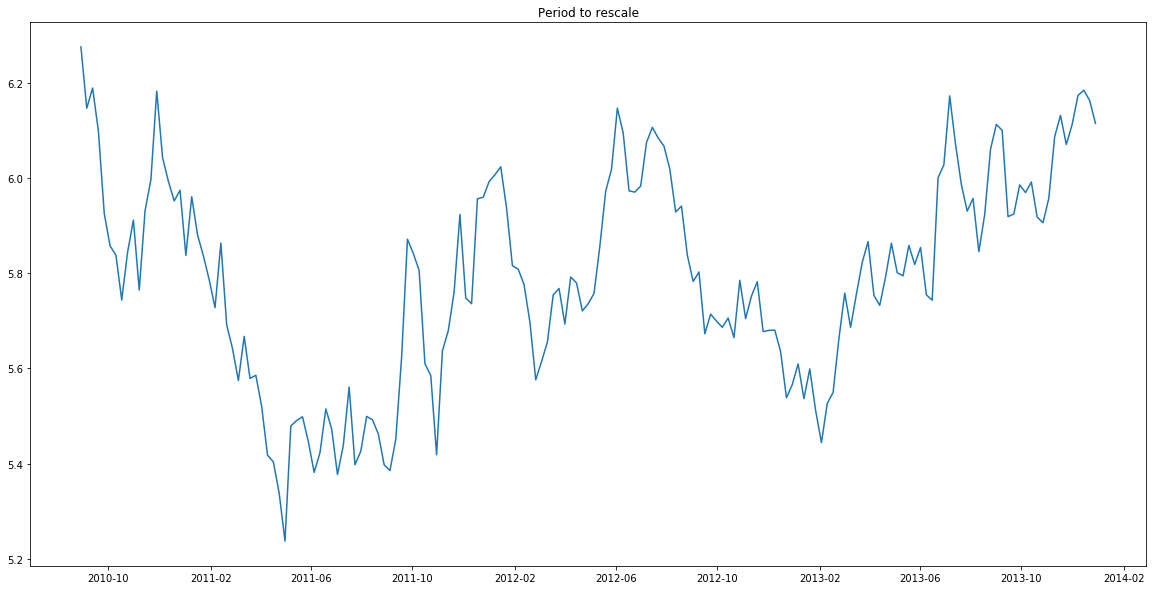

(175,) (175, 1)


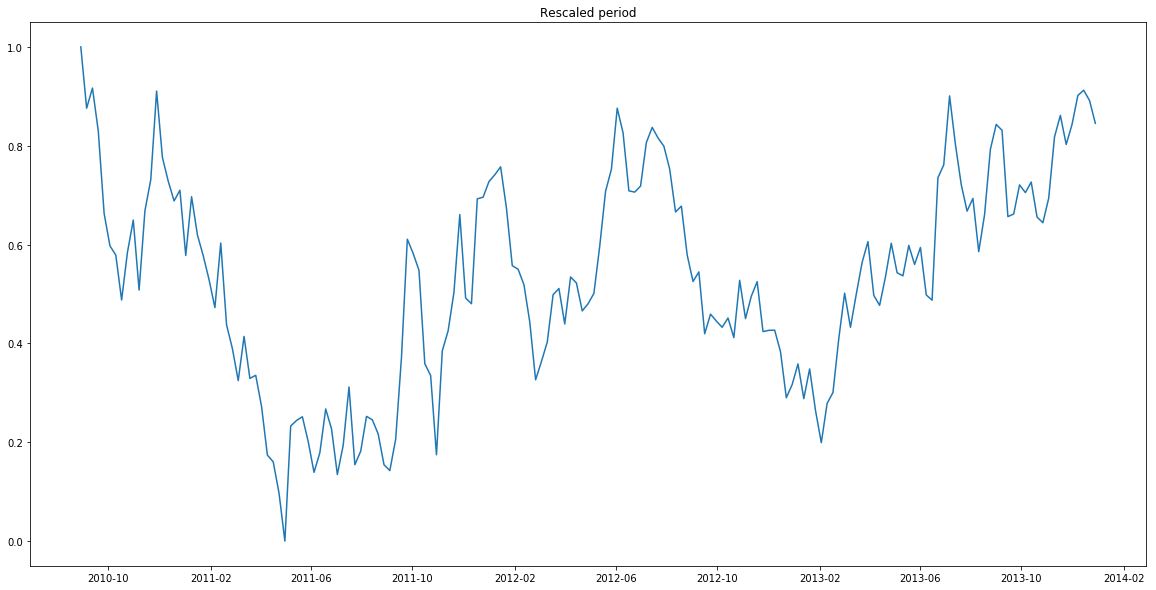

(175, 1)


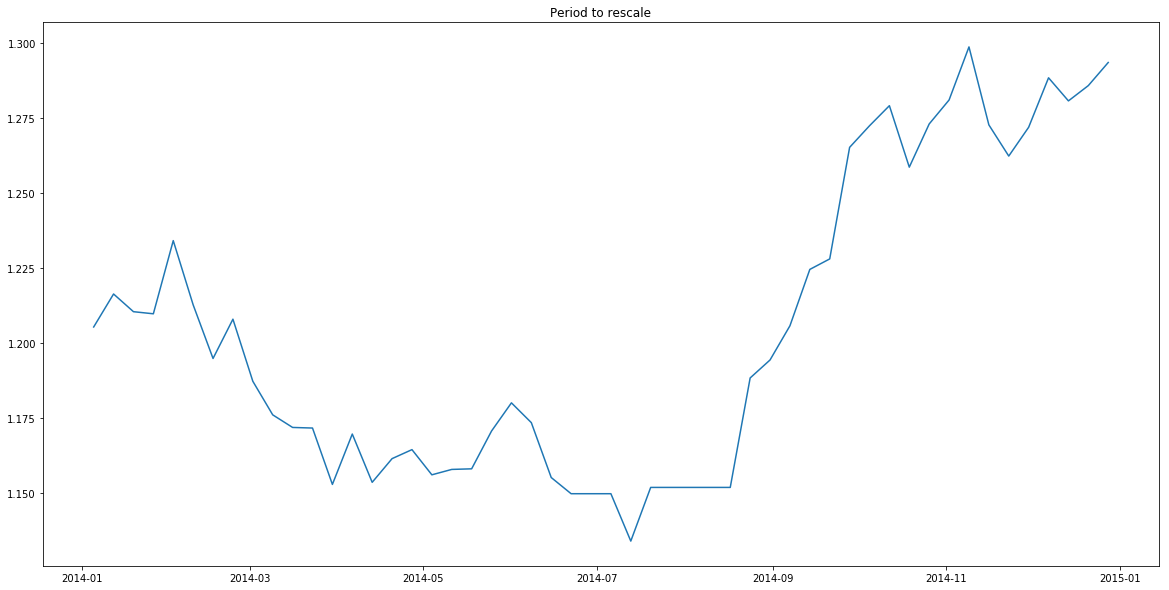

(52,) (52, 1)


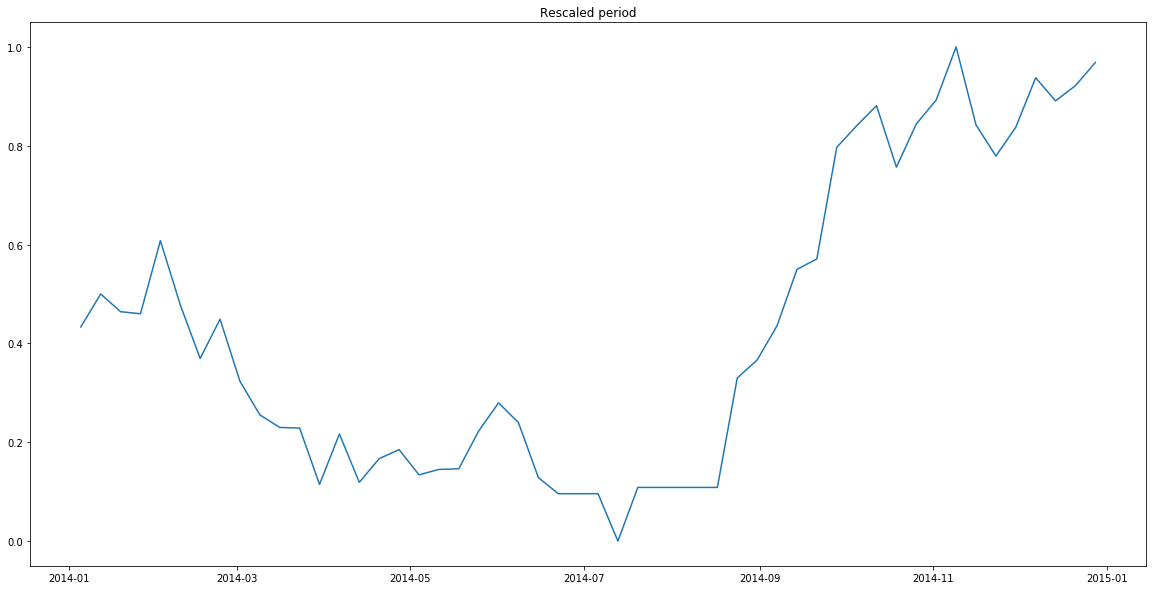

(52, 1)


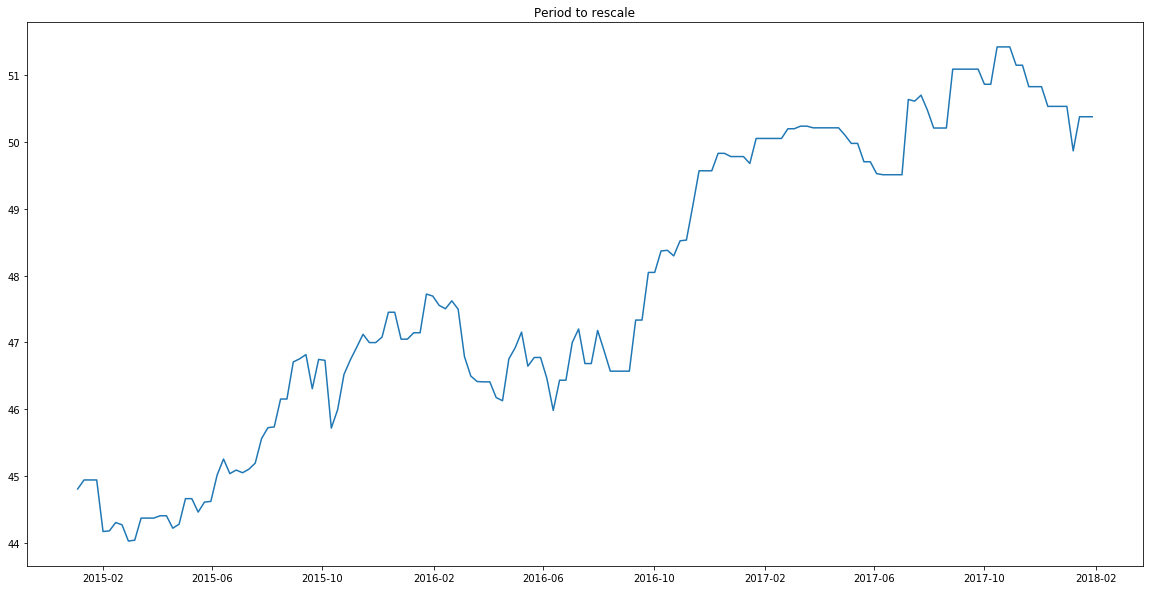

(161,) (161, 1)


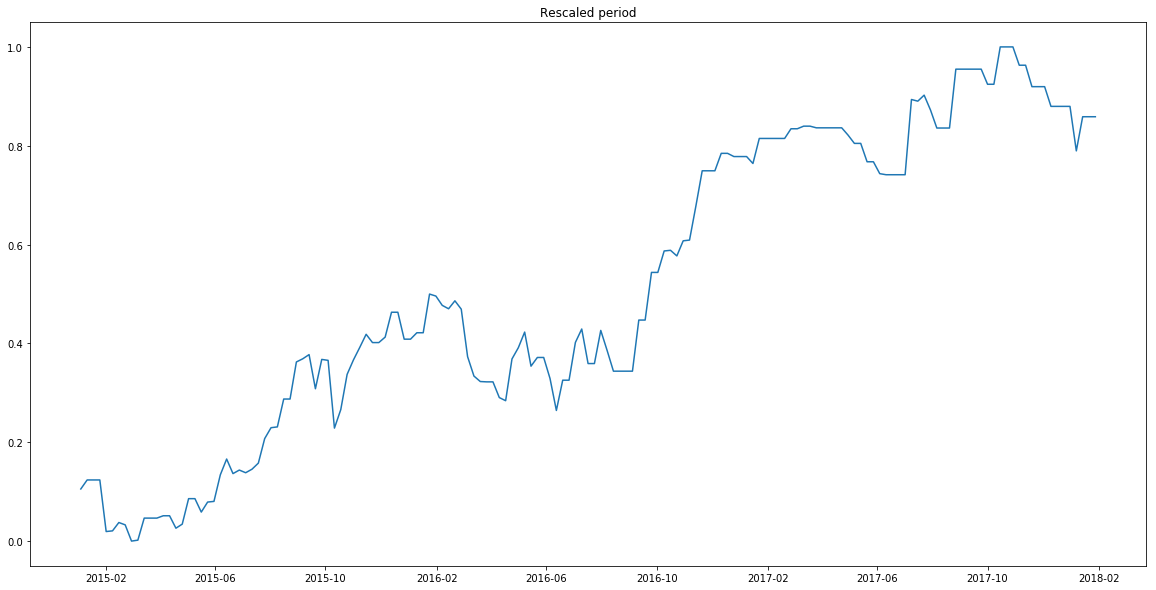

(161, 1)


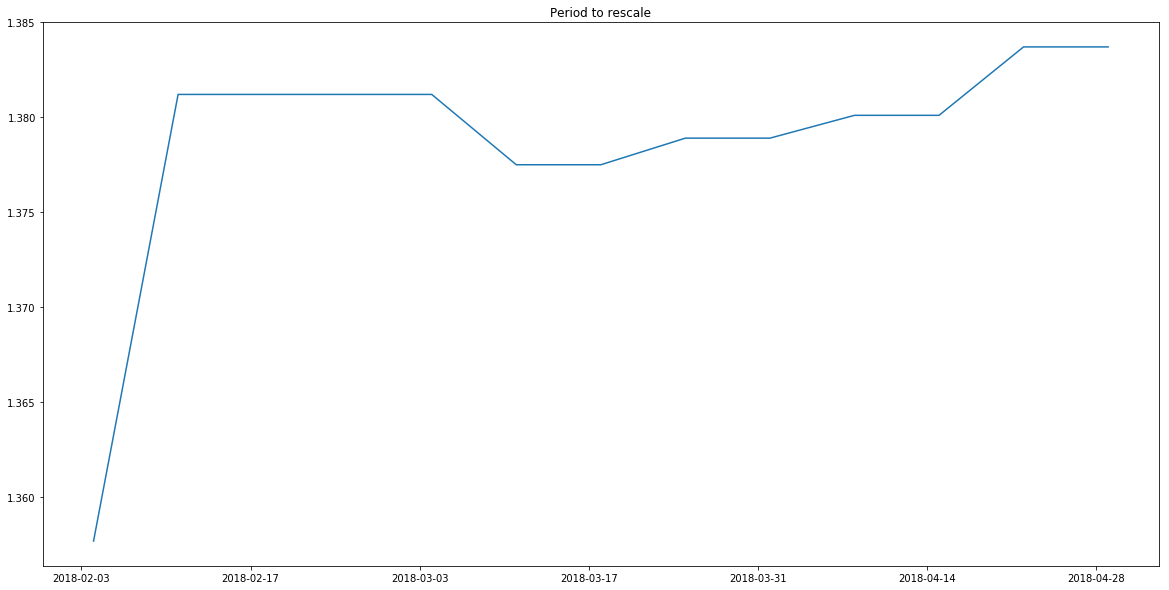

(13,) (13, 1)


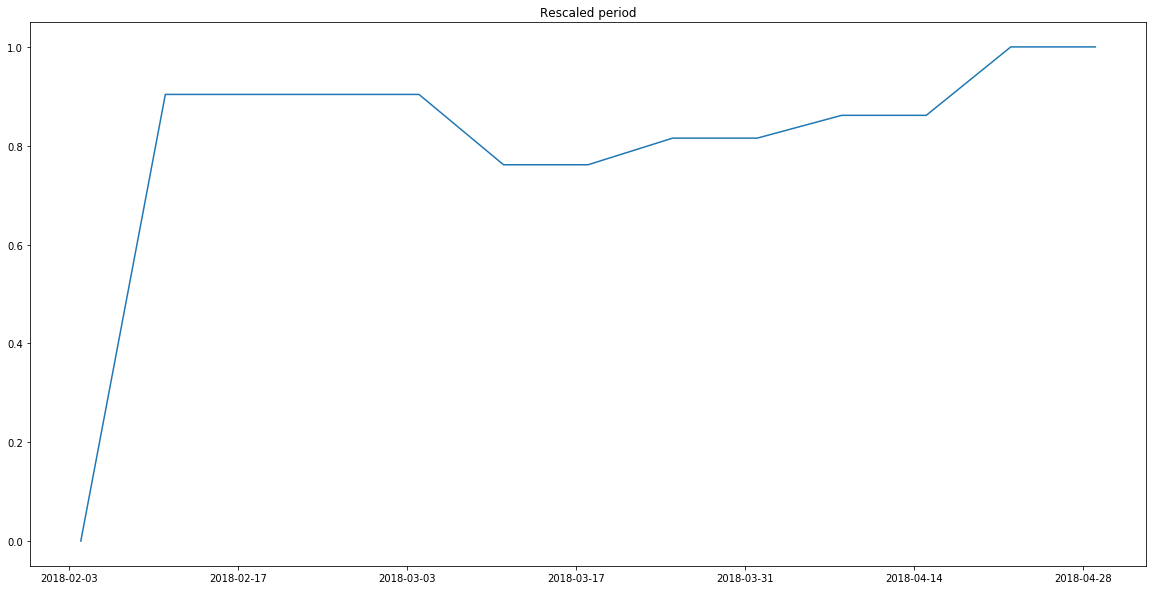

(13, 1)


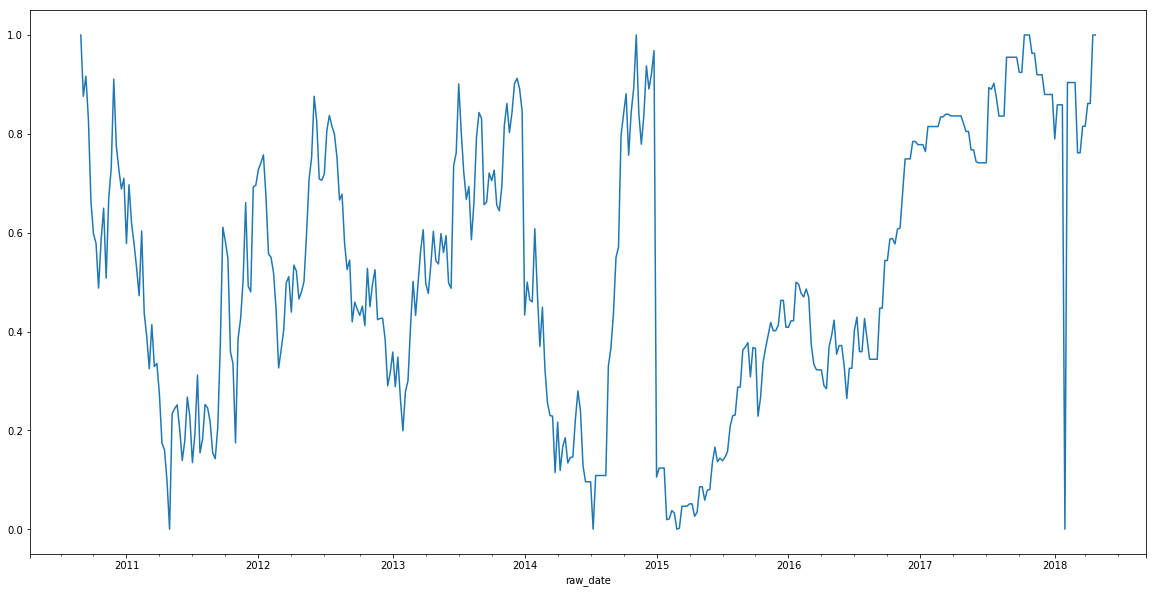

In [30]:
#Rescale the NOK series for the 4 different periods 2014-01-05 to 2014-12-28
nok_rescaled = rescale_periods(series=currencies_cleaned['NOK'], min_max=(0,1),
                               periods=[['2010-08-29','2013-12-29'], ['2014-01-05','2014-12-28'],
                                       ['2015-01-04','2018-01-28'], ['2018-02-04','2018-04-29']])
_ = nok_rescaled.plot()
plt.show()

                 BGN       BRL       CAD       CHF       EUR       PLN  \
raw_date                                                                 
2010-08-29  0.355129  0.080556  0.240625  0.990351  0.847061  0.524290   
2010-09-05  0.355129  0.066345  0.231458  0.964878  0.816022  0.461984   
2010-09-12  0.328157  0.064203  0.176669  0.991509  0.843924  0.474960   
2010-09-19  0.301185  0.063503  0.167928  0.946353  0.759632  0.413190   
2010-09-26  0.296581  0.063580  0.172618  0.830297  0.675549  0.339088   

                 NOK  
raw_date              
2010-08-29  1.000000  
2010-09-05  0.875938  
2010-09-12  0.916747  
2010-09-19  0.829548  
2010-09-26  0.662945  


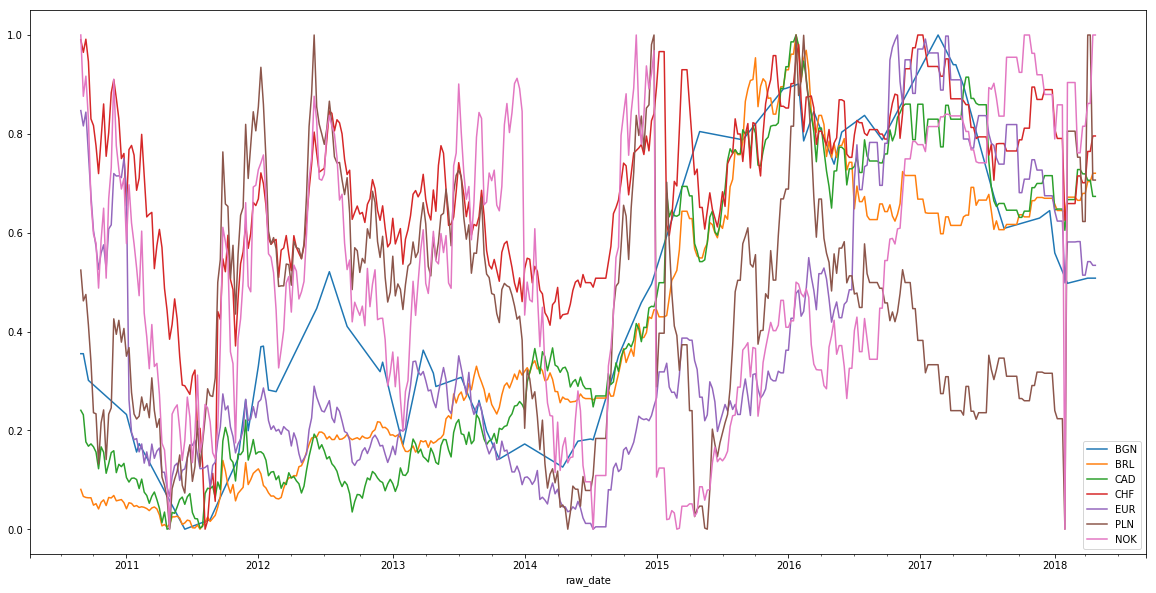

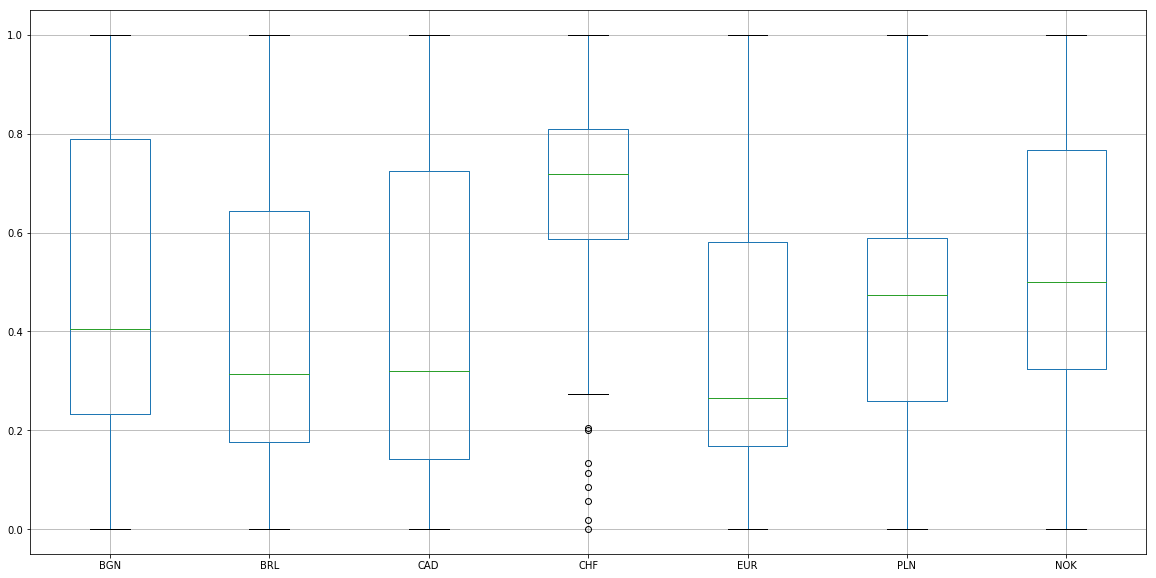

In [31]:
#Concatenate the curencies dataframe with the PLN and NOK scaled series
currencies_scaled = pd.concat([currencies_scaled, pln_rescaled, nok_rescaled], axis=1)
print(currencies_scaled.head())
currencies_scaled.to_csv('currencies_cleaned_scaled.csv')

#plot all
_ = currencies_scaled.plot()
plt.show()
_ = currencies_scaled.boxplot()
plt.show()

### Merge <a class="anchor" id="first-third-bullet"></a>
Merge al lthe rescaled series into one global dataframe

**Datetime indexes are not matching: interpolation will loose information**

DatetimeIndex(['2010-01-01', '2010-01-08', '2010-01-15', '2010-01-22',
               '2010-01-29', '2010-02-05', '2010-02-12', '2010-02-19',
               '2010-02-26', '2010-03-05',
               ...
               '2018-03-09', '2018-03-16', '2018-03-23', '2018-03-30',
               '2018-04-06', '2018-04-13', '2018-04-20', '2018-04-27',
               '2018-05-04', '2018-05-11'],
              dtype='datetime64[ns]', name='Date', length=437, freq=None) DatetimeIndex(['2010-08-29', '2010-09-05', '2010-09-12', '2010-09-19',
               '2010-09-26', '2010-10-03', '2010-10-10', '2010-10-17',
               '2010-10-24', '2010-10-31',
               ...
               '2018-02-25', '2018-03-04', '2018-03-11', '2018-03-18',
               '2018-03-25', '2018-04-01', '2018-04-08', '2018-04-15',
               '2018-04-22', '2018-04-29'],
              dtype='datetime64[ns]', name='raw_date', length=401, freq=None)
                  BP       CVX       MRO       NRG       UAL       V

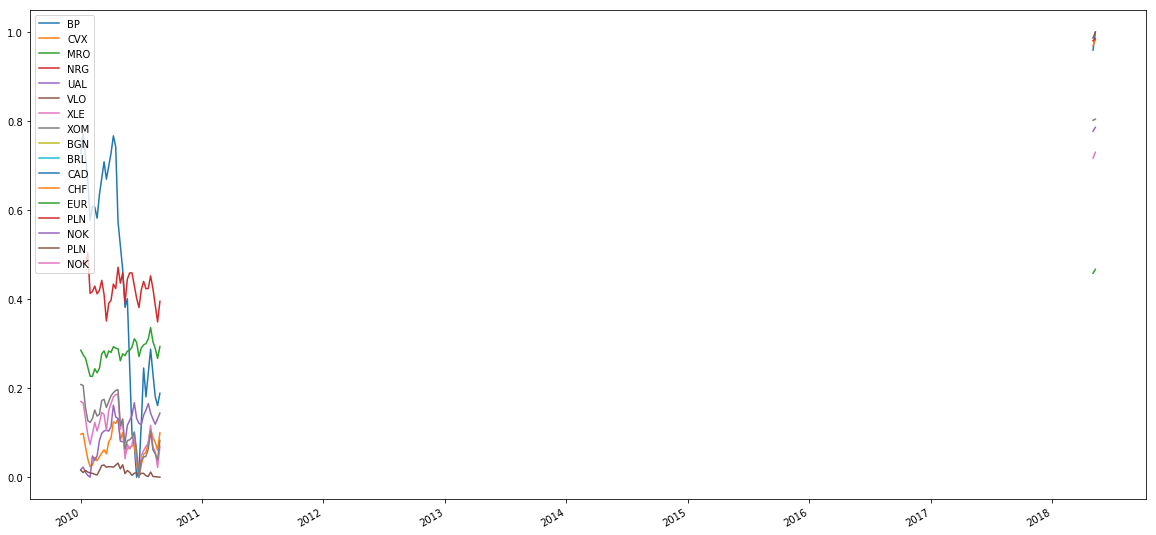

In [289]:
#Merge the stocks and currencies dataframes
global_df = pd.concat([stocks_scaled, currencies_scaled], axis=1)
print(stocks_scaled.index, currencies_scaled.index)
print(global_df.head())

#Plot all
_ = global_df.plot()
plt.show()

## 2. Analysis <a class="anchor" id="second-bullet"></a>

                  BP       CVX       MRO       NRG       UAL       VLO  \
Date                                                                     
2010-01-01  0.728159  0.096669  0.285344  0.480874  0.017234  0.015449   
2010-01-08  0.772538  0.098682  0.274860  0.480874  0.022737  0.010584   
2010-01-15  0.721276  0.068404  0.267614  0.479133  0.011151  0.015091   
2010-01-22  0.668115  0.040962  0.247110  0.504200  0.003910  0.011729   
2010-01-29  0.576745  0.023857  0.226914  0.412986  0.000000  0.009439   

                 XLE       XOM  
Date                            
2010-01-01  0.169960  0.208168  
2010-01-08  0.167074  0.206159  
2010-01-15  0.131928  0.156267  
2010-01-22  0.095084  0.127136  
2010-01-29  0.073521  0.123118  
                 BGN       BRL       CAD       CHF       EUR       PLN  \
raw_date                                                                 
2010-08-29  0.355129  0.080556  0.240625  0.990351  0.847061  0.524290   
2010-09-05  0.355129  0.0663

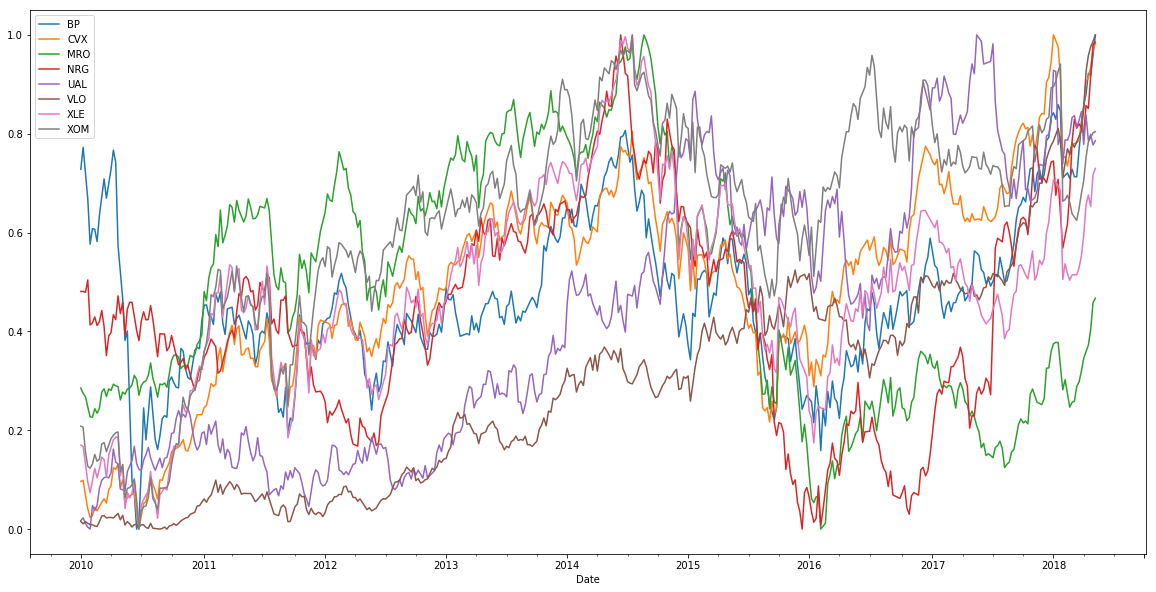

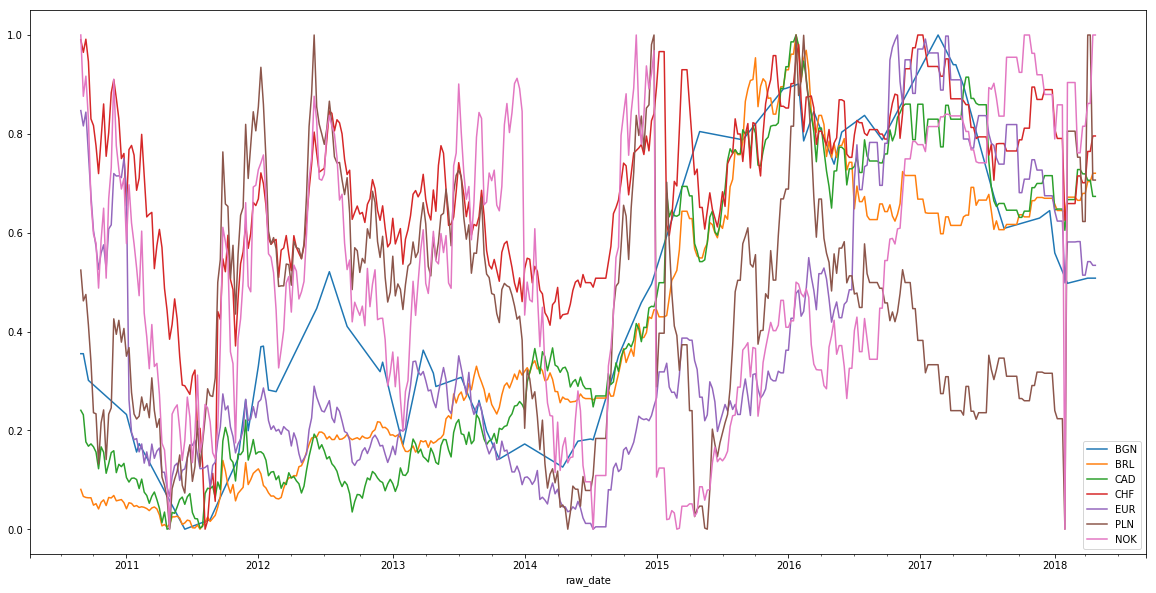

In [2]:
#Load the csv files
stocks = pd.read_csv('stocks_cleaned_scaled.csv', index_col=[0], parse_dates=[0])
currencies = pd.read_csv('currencies_cleaned_scaled.csv', index_col=[0], parse_dates=[0])
print(stocks.head())
print(currencies.head())

#Plot the series
_ = stocks.plot()
plt.show()

_ = currencies.plot()
plt.show()

### Trend (moving average) <a class="anchor" id="second-first-bullet"></a>

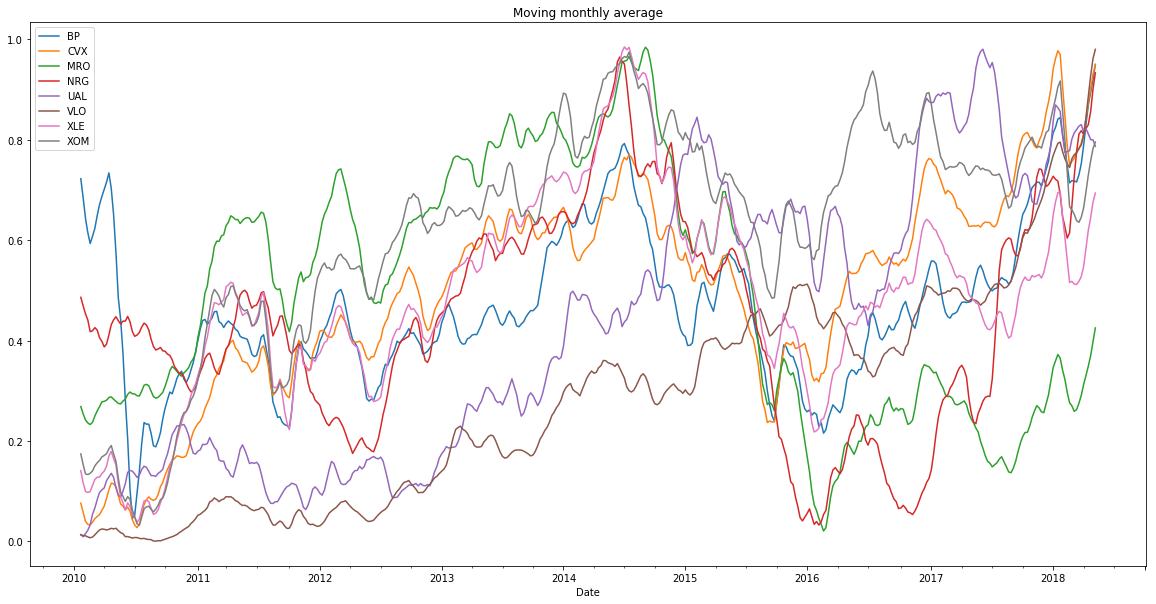

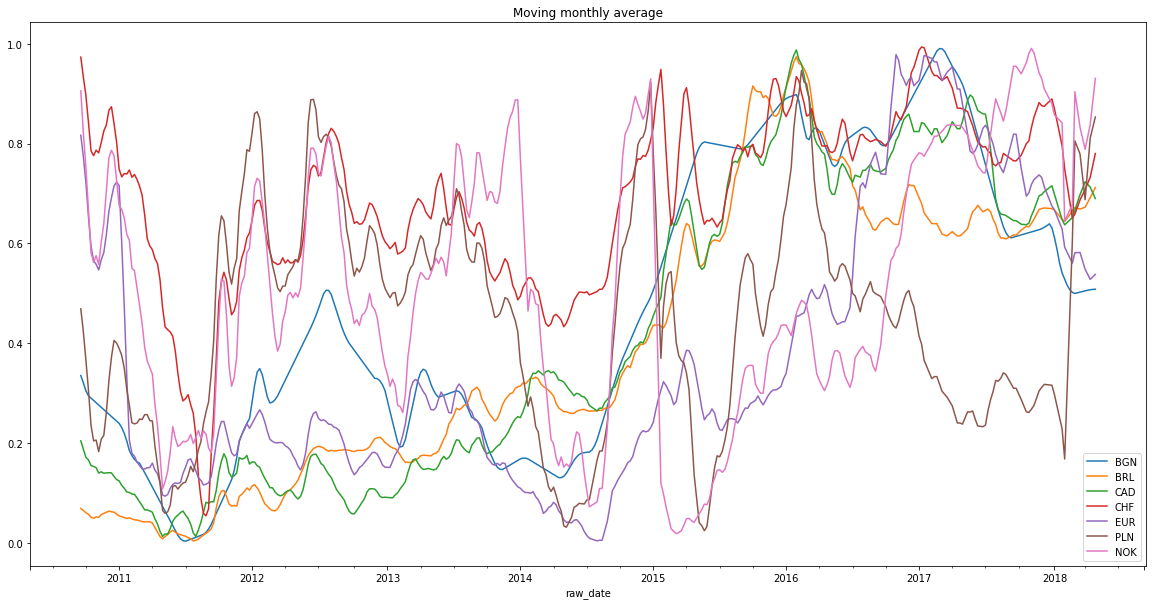

In [48]:
#Plot the moving monthly average for the stocks and currencies (4 values/month in average)
_ = stocks.rolling(4).mean().plot()
_ = plt.title('Moving monthly average')
plt.show()

_ = currencies.rolling(4).mean().plot()
_ = plt.title('Moving monthly average')
plt.show()

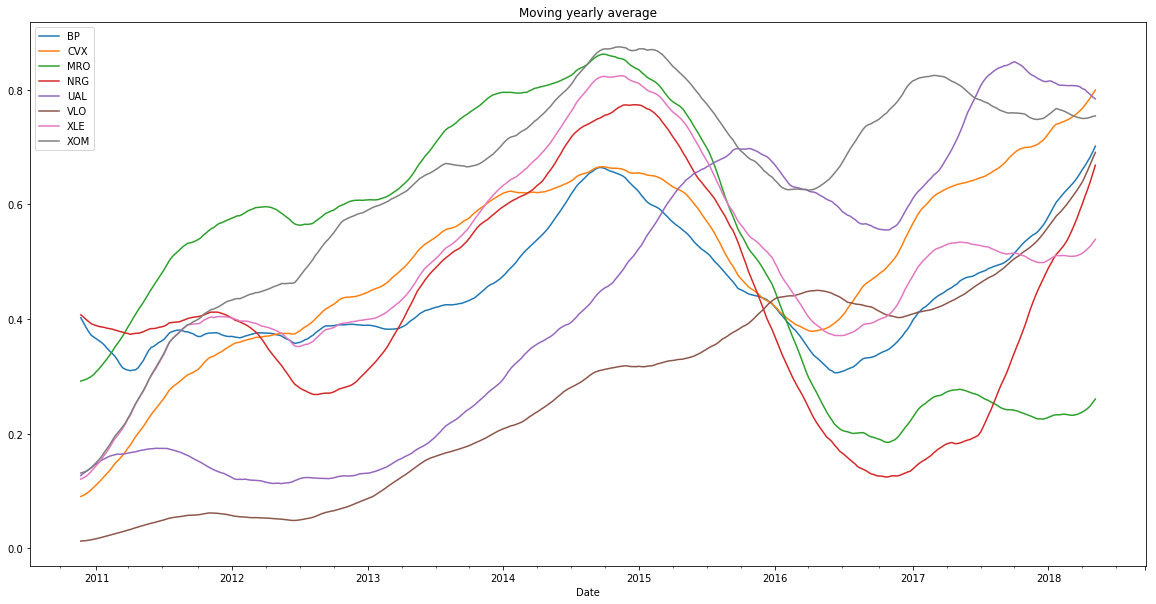

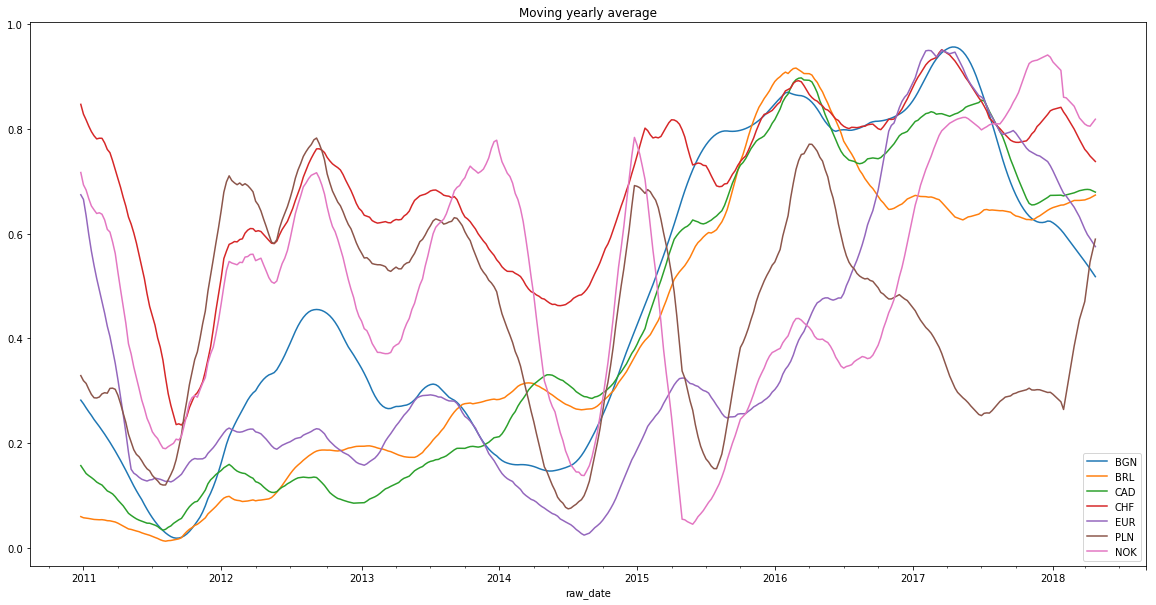

In [3]:
#Plot the moving yearly average for the stocks and currencies (4 values/month in average)
_ = stocks.rolling(48).mean().plot()
_ = plt.title('Moving yearly average')
plt.show()

_ = currencies.rolling(18).mean().plot()
_ = plt.title('Moving yearly average')
plt.show()

### Correlations  <a class="anchor" id="second-second-bullet"></a>

In [3]:
def correlation_analysis(dataframe, viz=False):
    """Proceed the analysis of the correlation between the different series of the dataframe"""

    if viz == True:
        #Plot the scatter matrix of the dataframe to visualize the distributions and cross-correlations
        _ = pd.plotting.scatter_matrix(dataframe, figsize=(30,30))
        _ = plt.title('Scatter matrix of the dataframe series')
        plt.show()

    #Print the correlation matrix
    df_corr = dataframe.corr()
    print("Correlation matrix :\n", df_corr)
    _ = sns.heatmap(df_corr, cmap='RdYlGn')
    _ = plt.title('Heatmap of the series correlations')
    plt.show()

    #Return the most correlated series couples (corr > 0.7)
    most_corr = df_corr[(df_corr >= 0.7) & (df_corr != 1)]
    most_corr.fillna('-', inplace=True)
    print("\nHighest correlation values (>0.7)\n", most_corr)
    
    
    
    #Creating the returns
    df_return = dataframe.pct_change()
    df_return.dropna(inplace=True)
    print('\nReturn of the series\n', df_return.head())

    #Print the correlation matrix
    df_corr_return = df_return.corr()
    print("\nCorrelation matrix for the return :\n", df_corr_return)
    _ = sns.heatmap(df_corr_return, cmap='RdYlGn')
    _ = plt.title('Heatmap of the returns correlations')
    plt.show()

    #Return the most correlated series couples (corr > 0.7)
    most_corr_return = df_corr_return[(df_corr_return >= 0.7) & (df_corr_return != 1)]
    most_corr_return.fillna('-', inplace=True)
    print("\nHighest correlation values (>0.7)\n", most_corr_return)
    
    return

#### Stocks
For stocks, it is interesting to look at the return to compare them !

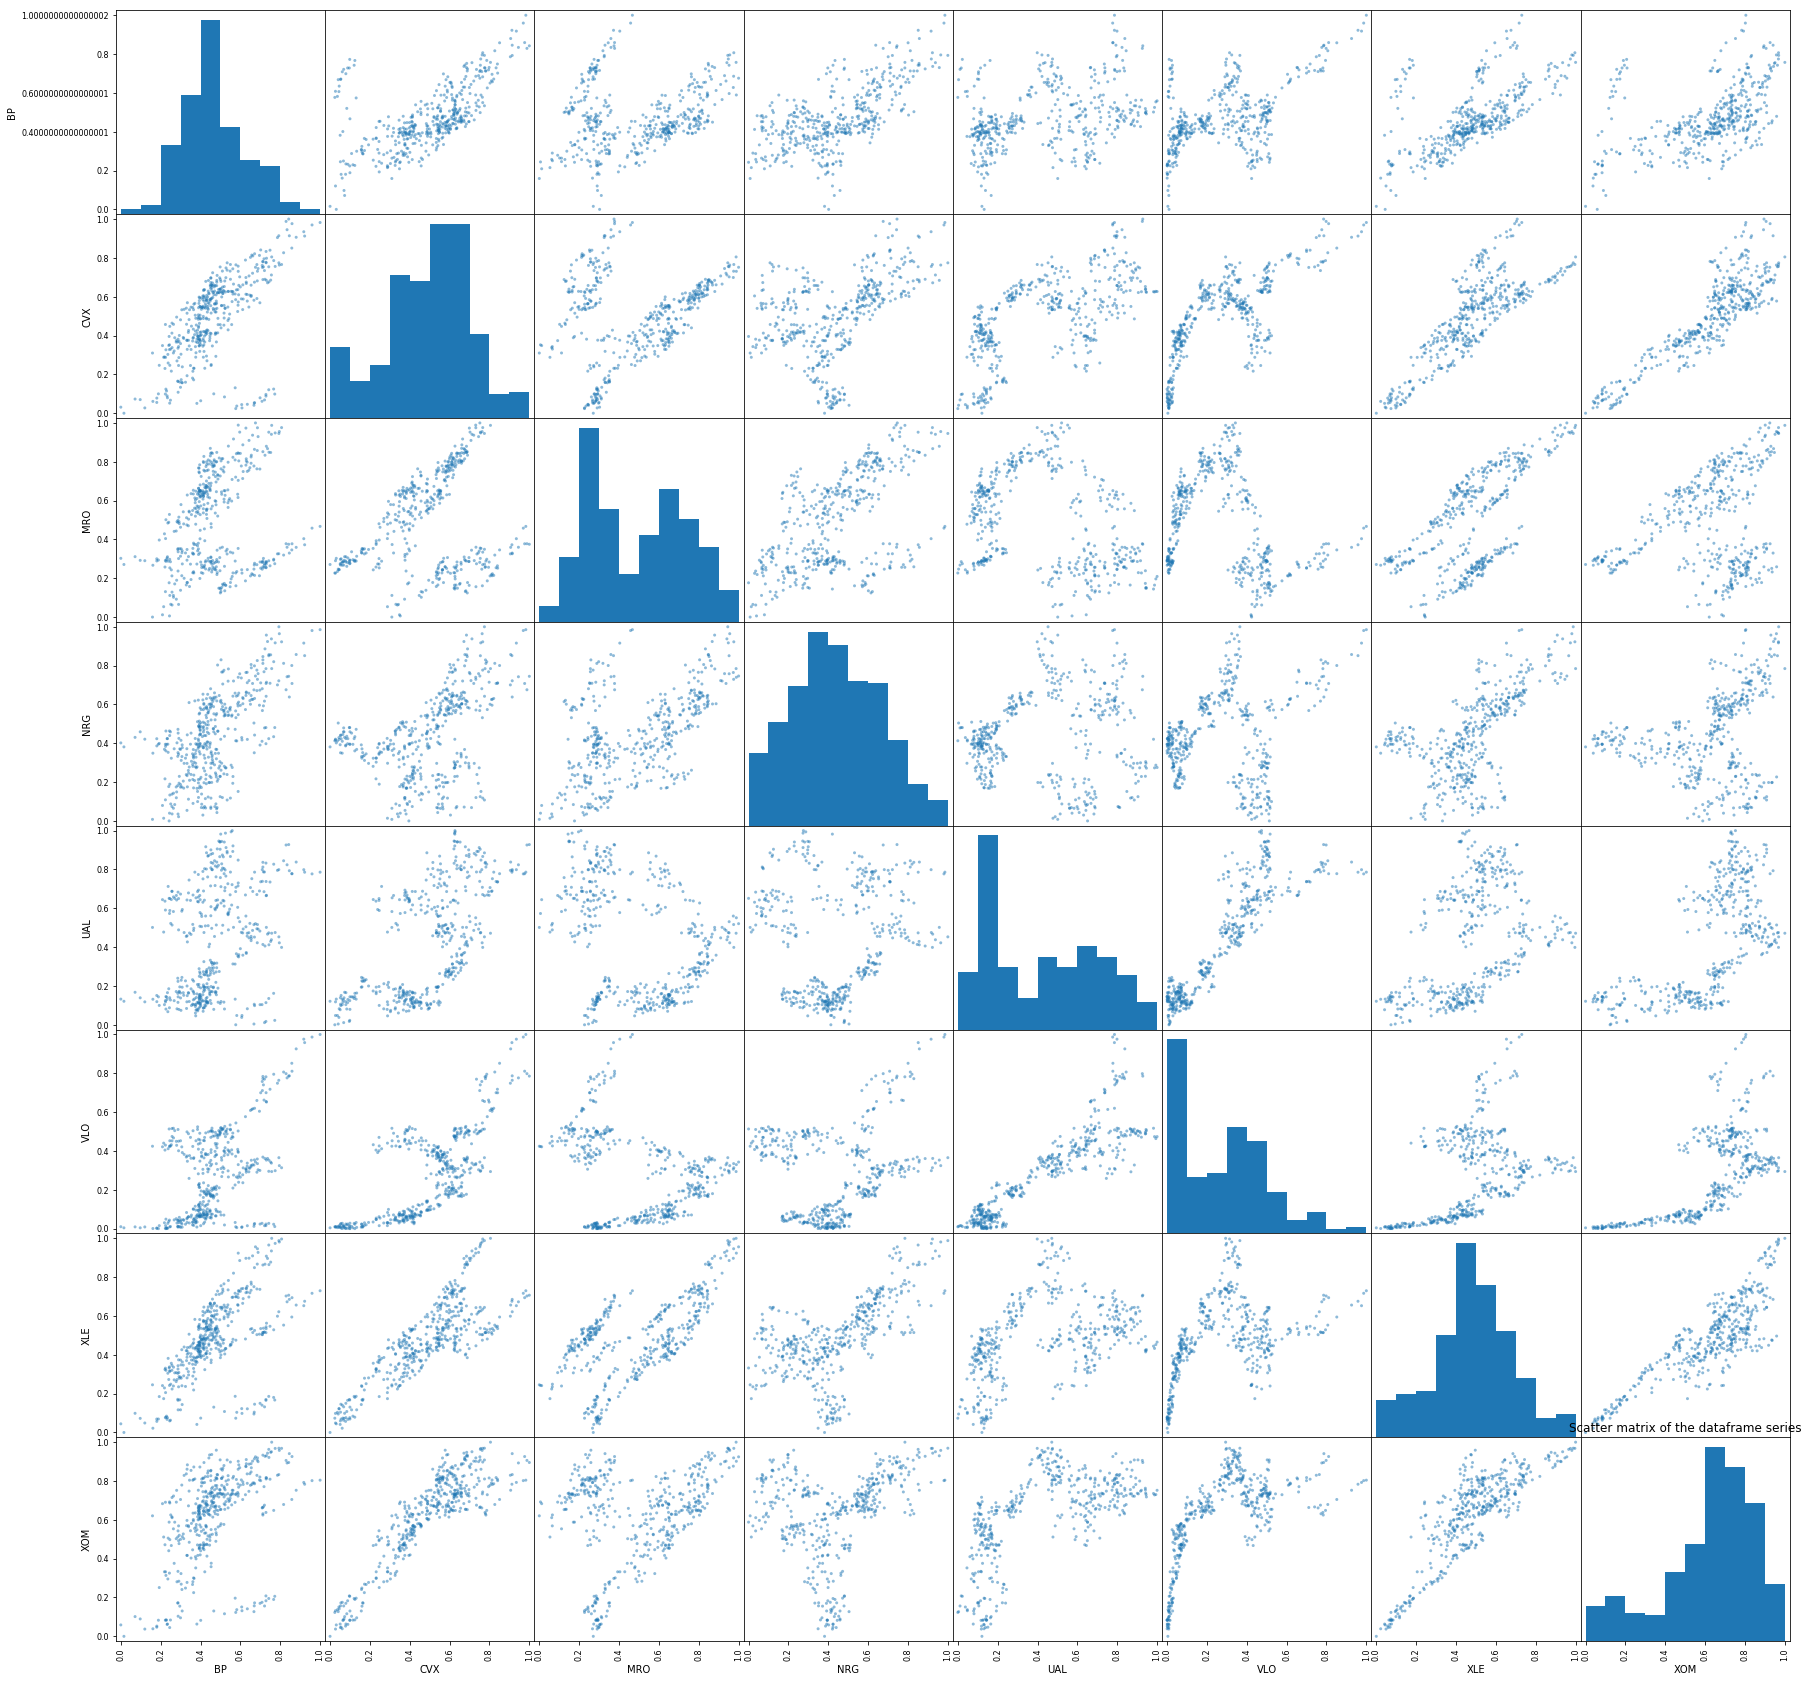

Correlation matrix :
            BP       CVX       MRO       NRG       UAL       VLO       XLE  \
BP   1.000000  0.620212  0.236371  0.649730  0.357172  0.512541  0.611210   
CVX  0.620212  1.000000  0.237087  0.447014  0.635584  0.732100  0.813791   
MRO  0.236371  0.237087  1.000000  0.560814 -0.324243 -0.315353  0.640723   
NRG  0.649730  0.447014  0.560814  1.000000  0.091229  0.206712  0.590030   
UAL  0.357172  0.635584 -0.324243  0.091229  1.000000  0.891459  0.426786   
VLO  0.512541  0.732100 -0.315353  0.206712  0.891459  1.000000  0.446988   
XLE  0.611210  0.813791  0.640723  0.590030  0.426786  0.446988  1.000000   
XOM  0.479330  0.886426  0.275342  0.269911  0.630937  0.650550  0.850527   

          XOM  
BP   0.479330  
CVX  0.886426  
MRO  0.275342  
NRG  0.269911  
UAL  0.630937  
VLO  0.650550  
XLE  0.850527  
XOM  1.000000  


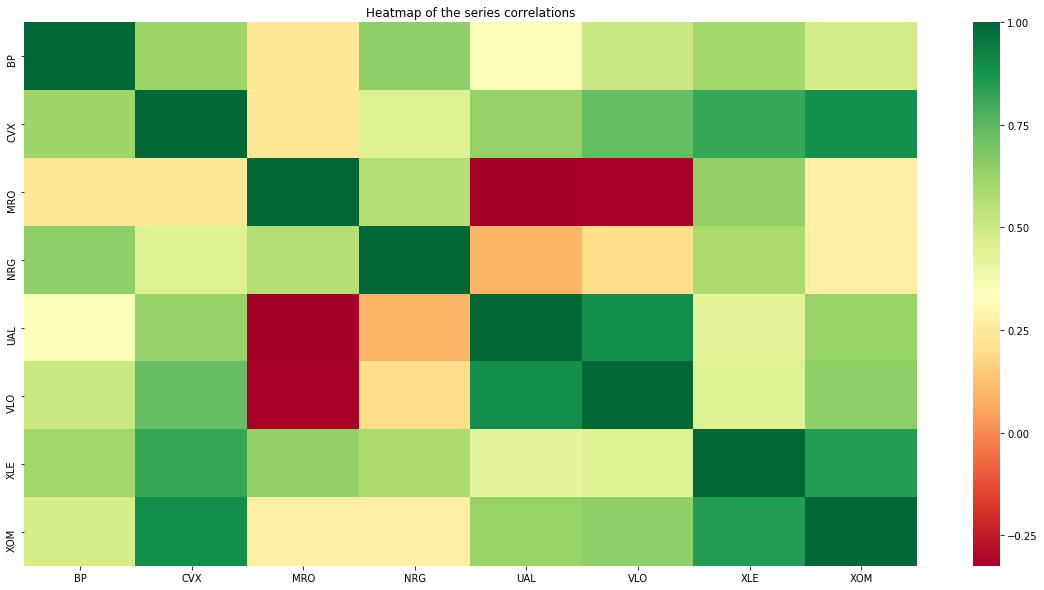


Highest correlation values (>0.7)
     BP       CVX MRO NRG       UAL       VLO       XLE       XOM
BP   -         -   -   -         -         -         -         -
CVX  -         -   -   -         -    0.7321  0.813791  0.886426
MRO  -         -   -   -         -         -         -         -
NRG  -         -   -   -         -         -         -         -
UAL  -         -   -   -         -  0.891459         -         -
VLO  -    0.7321   -   -  0.891459         -         -         -
XLE  -  0.813791   -   -         -         -         -  0.850527
XOM  -  0.886426   -   -         -         -  0.850527         -

Return of the series
                   BP       CVX       MRO       NRG       UAL       VLO  \
Date                                                                     
2010-01-08  0.060947  0.020815 -0.036739  0.000000  0.319328 -0.314916   
2010-01-15 -0.066356 -0.306821 -0.026363 -0.003620 -0.509554  0.425875   
2010-01-22 -0.073704 -0.401173 -0.076619  0.052317 -0.649351

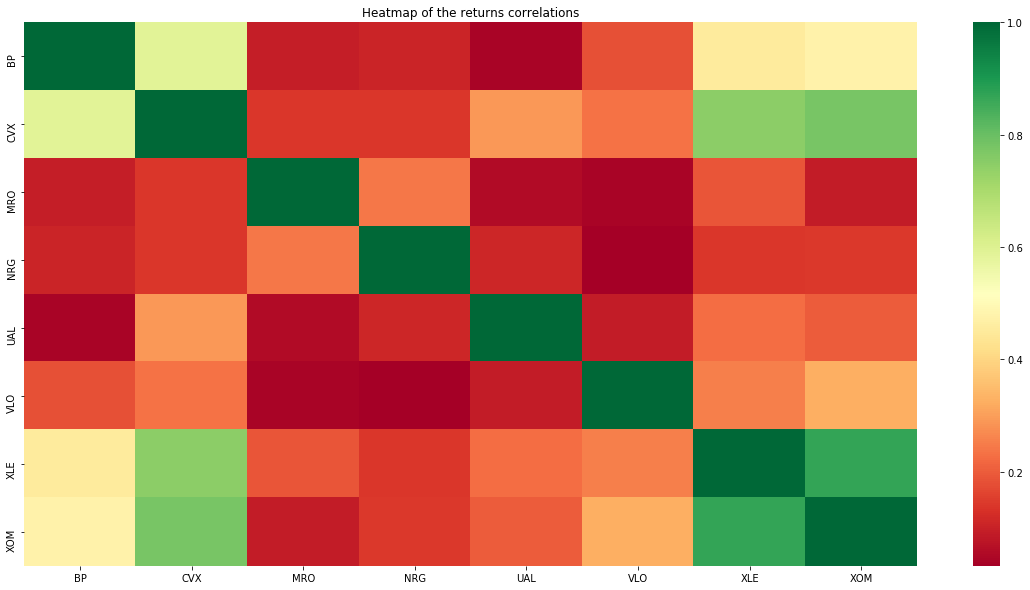


Highest correlation values (>0.7)
     BP       CVX MRO NRG UAL VLO       XLE       XOM
BP   -         -   -   -   -   -         -         -
CVX  -         -   -   -   -   -  0.749978  0.780448
MRO  -         -   -   -   -   -         -         -
NRG  -         -   -   -   -   -         -         -
UAL  -         -   -   -   -   -         -         -
VLO  -         -   -   -   -   -         -         -
XLE  -  0.749978   -   -   -   -         -  0.870018
XOM  -  0.780448   -   -   -   -  0.870018         -


In [4]:
correlation_analysis(stocks, viz=True)

In [ ]:
#Creating the returns
stocks_return = stocks.pct_change()
stocks_return.dropna(inplace=True)
print(stocks_return.head())

#Print the 3 most correlated stock returns: XLE/XOM, CVX/XOM, XLE/CVX
_ = sns.regplot(data=stocks_return, x='XLE', y='XOM', order=1)
#_ = sns.regplot(data=stocks_return, x='XLE', y='XOM', order=2)
_ = plt.title('XLE & XOM returns correlation')
plt.show()

                  BP       CVX       MRO       NRG       UAL       VLO  \
Date                                                                     
2010-01-08  0.060947  0.020815 -0.036739  0.000000  0.319328 -0.314916   
2010-01-15 -0.066356 -0.306821 -0.026363 -0.003620 -0.509554  0.425875   
2010-01-22 -0.073704 -0.401173 -0.076619  0.052317 -0.649351 -0.222821   
2010-01-29 -0.136758 -0.417594 -0.081729 -0.180909 -1.000000 -0.195206   
2010-02-05  0.054317  0.138047 -0.002039  0.010117       inf -0.083379   

                 XLE       XOM  
Date                            
2010-01-08 -0.016982 -0.009652  
2010-01-15 -0.210362 -0.242008  
2010-01-22 -0.279275 -0.186419  
2010-01-29 -0.226775 -0.031603  
2010-02-05  0.336013  0.070709  


In [ ]:

_ = sns.regplot(data=stocks_return, x='XLE', y='CVX', order=1)
#_ = sns.regplot(data=stocks_return, x='XLE', y='CVX', order=2)
_ = plt.title('XLE & CVX returns correlation')
plt.show()

_ = sns.regplot(data=stocks_return, x='CVX', y='XOM', order=1)
#_ = sns.regplot(data=stocks_return, x='CVX', y='XOM', order=2)
_ = plt.title('XOM & CXV returns correlation')
plt.show()

- XLE: Energy Select Sector SPDR Fund
- XOM: Exxon Mobile (Oil & GAs)
- CVX: Chevron Corp (Oil & Gas)    -> activities are linked in real life

#### Currencies

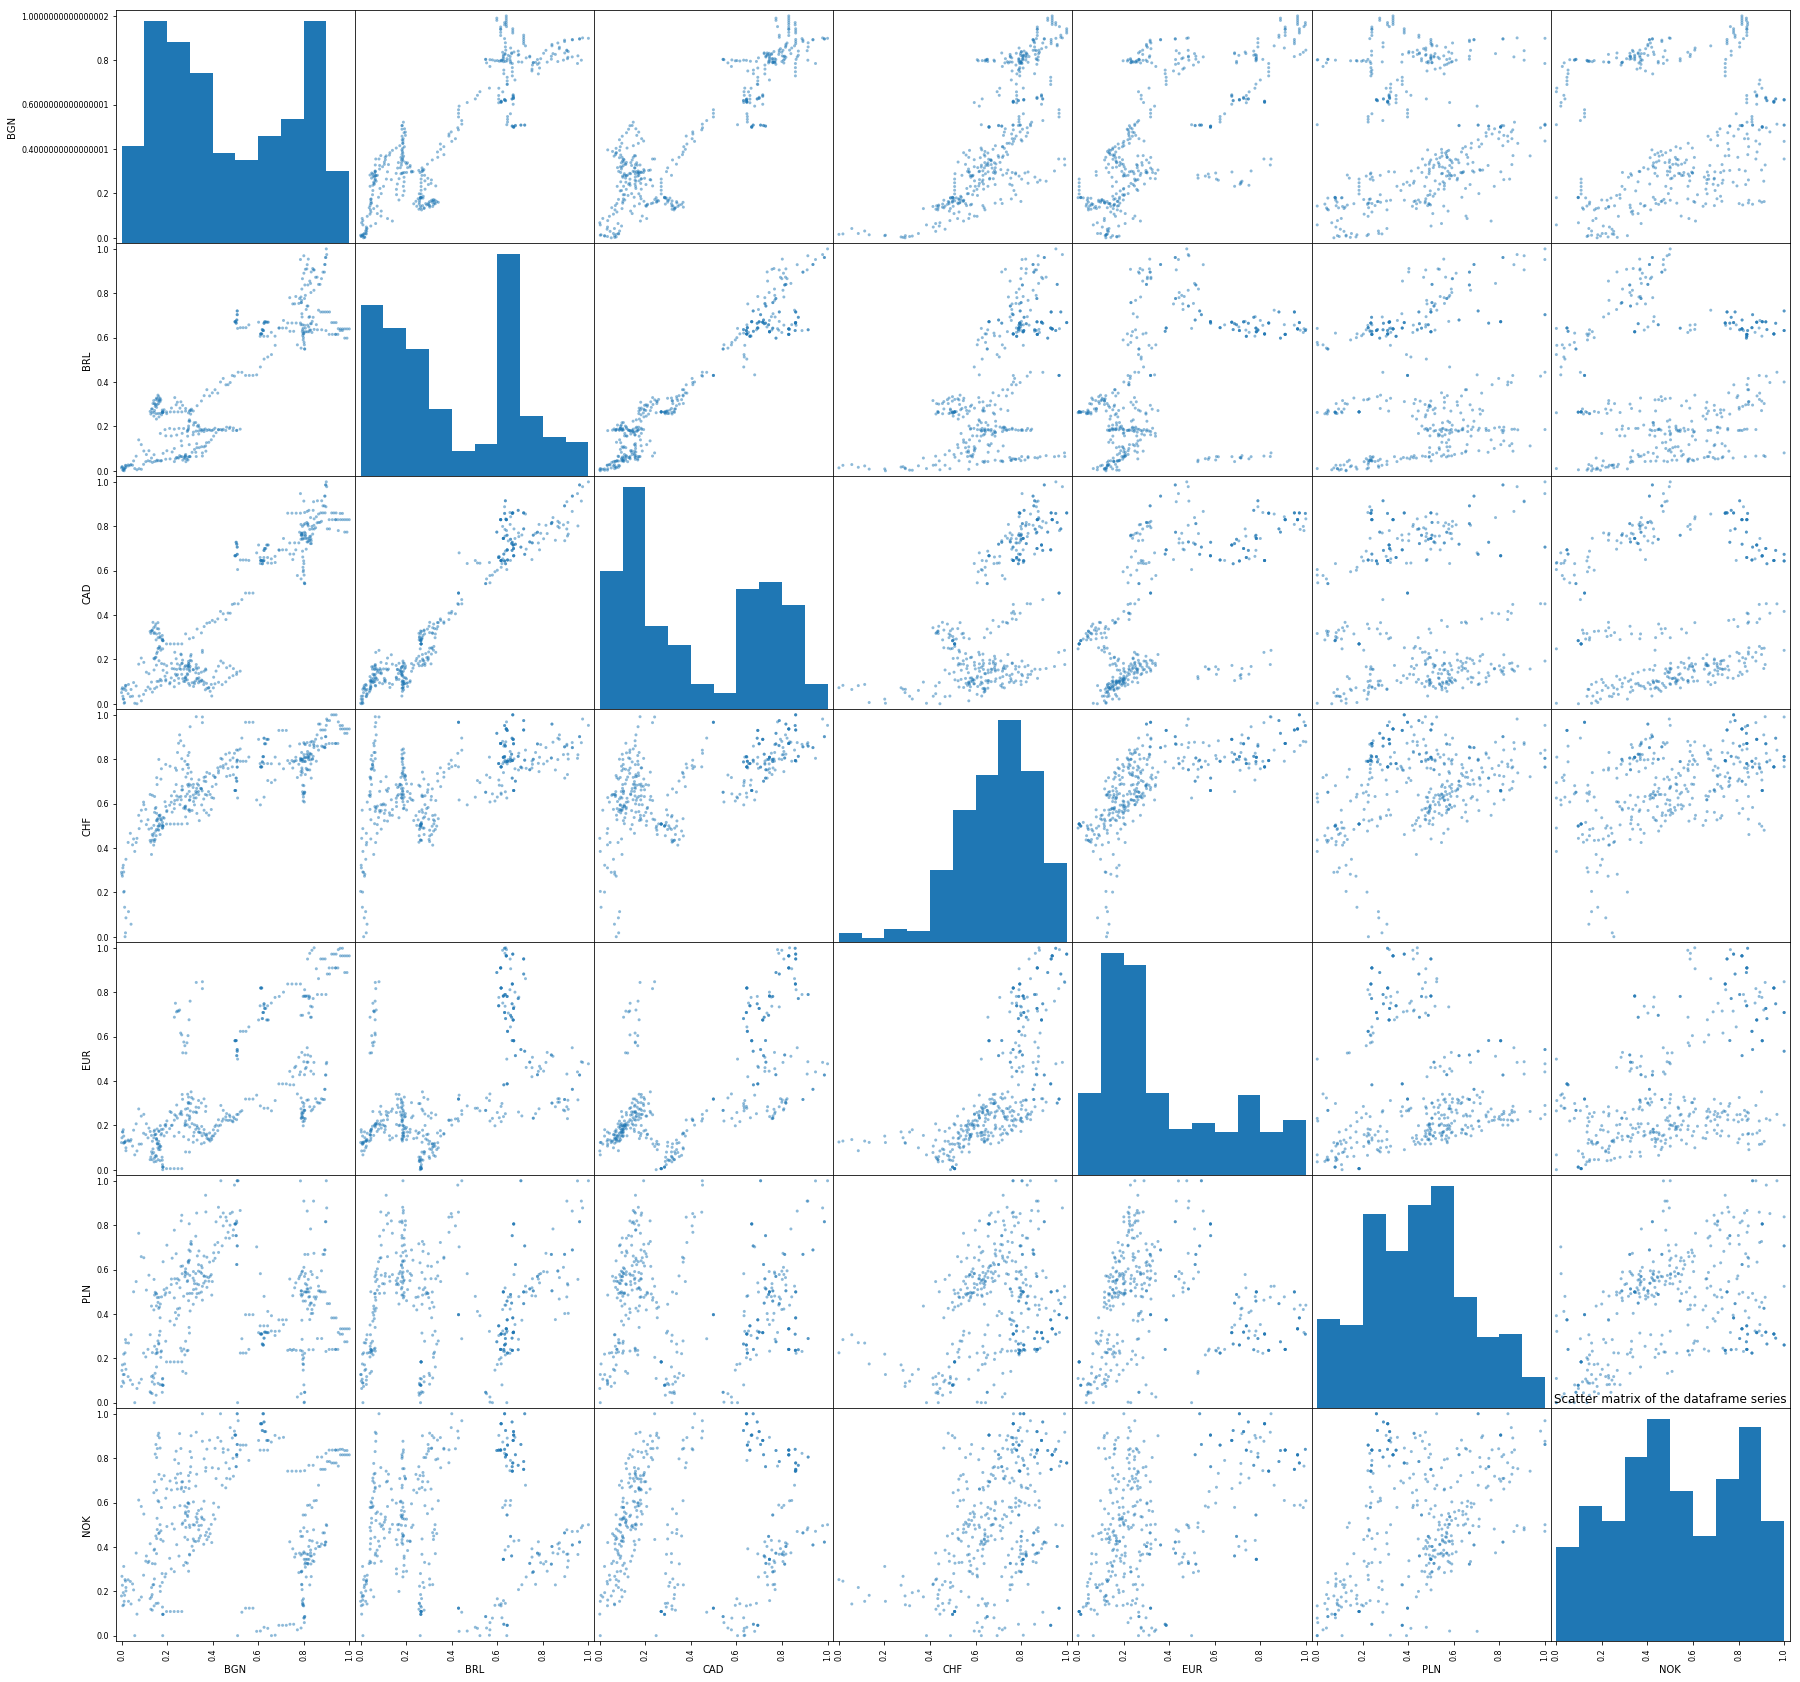

Correlation matrix :
           BGN       BRL       CAD       CHF       EUR       PLN       NOK
BGN  1.000000  0.880744  0.903819  0.768614  0.679968  0.137465  0.147042
BRL  0.880744  1.000000  0.962599  0.615449  0.533195  0.111168  0.104685
CAD  0.903819  0.962599  1.000000  0.642212  0.660896  0.022233  0.133391
CHF  0.768614  0.615449  0.642212  1.000000  0.693514  0.297991  0.437646
EUR  0.679968  0.533195  0.660896  0.693514  1.000000 -0.003907  0.515686
PLN  0.137465  0.111168  0.022233  0.297991 -0.003907  1.000000  0.383499
NOK  0.147042  0.104685  0.133391  0.437646  0.515686  0.383499  1.000000


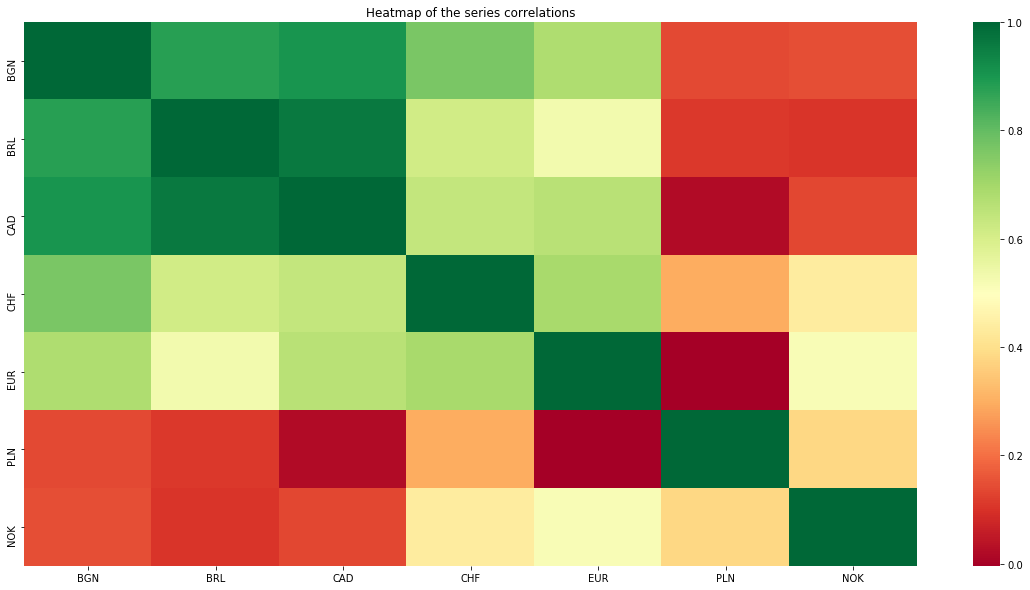


Highest correlation values (>0.7)
           BGN       BRL       CAD       CHF EUR PLN NOK
BGN         -  0.880744  0.903819  0.768614   -   -   -
BRL  0.880744         -  0.962599         -   -   -   -
CAD  0.903819  0.962599         -         -   -   -   -
CHF  0.768614         -         -         -   -   -   -
EUR         -         -         -         -   -   -   -
PLN         -         -         -         -   -   -   -
NOK         -         -         -         -   -   -   -
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 2010-09-05 to 2018-04-29
Data columns (total 7 columns):
BGN    400 non-null float64
BRL    400 non-null float64
CAD    400 non-null float64
CHF    400 non-null float64
EUR    400 non-null float64
PLN    400 non-null float64
NOK    400 non-null float64
dtypes: float64(7)
memory usage: 25.0 KB
None

Correlation matrix for the return :
           BGN       BRL       CAD       CHF       EUR       PLN       NOK
BGN  1.000000  0.081183 -0.016028  0.14

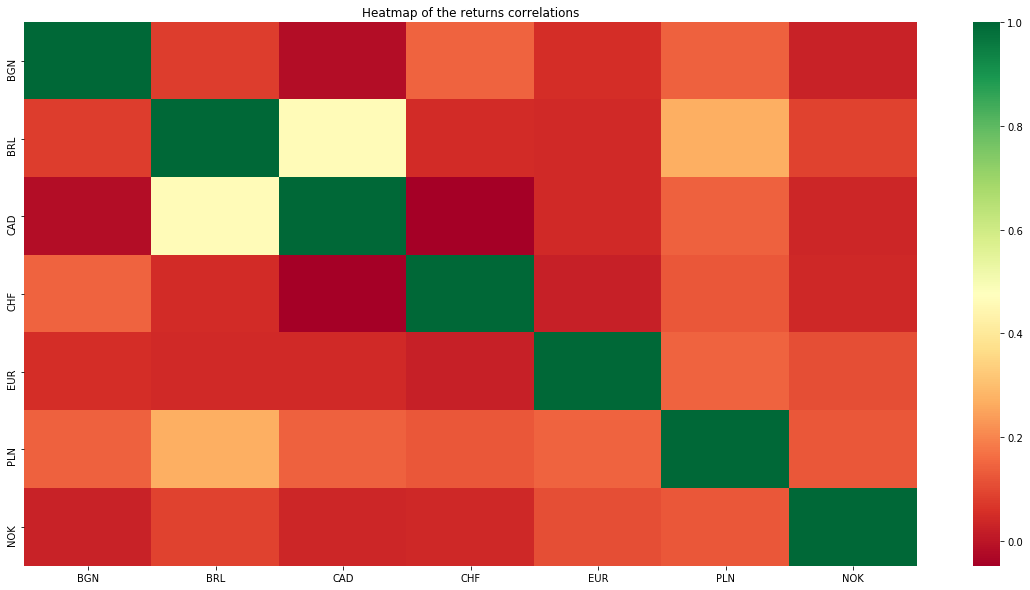


Highest correlation values (>0.7)
     BGN BRL CAD CHF EUR PLN NOK
BGN   -   -   -   -   -   -   -
BRL   -   -   -   -   -   -   -
CAD   -   -   -   -   -   -   -
CHF   -   -   -   -   -   -   -
EUR   -   -   -   -   -   -   -
PLN   -   -   -   -   -   -   -
NOK   -   -   -   -   -   -   -


In [51]:
correlation_analysis(currencies, viz=True)

In [ ]:
#Regplot for the 3 most correlated currencies values series: CAD/BRL, BGN/CAD, BRL/BGN
_ = sns.regplot(data=currencies, x='CAD', y='BRL', order=1)
#_ = sns.regplot(data=currencies, x='CAD', y='BRL', order=2)
_ = plt.title('CAD & BRL values correlation')
plt.show()

In [ ]:
_ = sns.regplot(data=currencies, x='CAD', y='BGN', order=1)
#_ = sns.regplot(data=currencies, x='CAD', y='BGN', order=2)
_ = plt.title('CAD & BRL values correlation')
plt.show()

_ = sns.regplot(data=currencies, x='BRL', y='BGN', order=1)
#_ = sns.regplot(data=currencies, x='BRL', y='BGN', order=2)
_ = plt.title('CAD & BRL values correlation')
plt.show()

### Autocorrelations  <a class="anchor" id="second-third-bullet"></a>

In [3]:
#Print the autocorrelation vaues for each stock
print("Autocorrelation of stocks series: \n")
for stock in stocks.columns:
    print("{} :".format(stock), stocks[stock].autocorr())

#Print the autocorrelation vaues for each currency          
print("\nAutocorrelation of currencies series: \n")
for curr in currencies.columns:
    print("{} :".format(curr), currencies[curr].autocorr())

Autocorrelation of stocks series: 

BP : 0.9720691815486268
CVX : 0.9902608022393066
MRO : 0.9912848803460544
NRG : 0.9880129799388064
UAL : 0.9929161454228284
VLO : 0.9969963210975793
XLE : 0.9842243585368965
XOM : 0.9873834250871578

Autocorrelation of currencies series: 

BGN : 0.9988006343171325
BRL : 0.9972133900442882
CAD : 0.9954902743058198
CHF : 0.9565208150548938
EUR : 0.9884210457661772
PLN : 0.928910839341833
NOK : 0.9246587932429567


*All the series present momentum*

In [3]:
#Get the p-value of a time series to check whether it is a random walk
def adf_test(ts, label, ret=True, diff=True):
    """Computes a Dickey-Fuller test in order to get the p-values for the
    time series put in argument (ts) and its return & diff series (if ret=True and diff=True)
    to check whether they are random walk, and forecastable"""
  

    #Dickey-Fuller test for the values
    results = adfuller(ts)
    print("\n\np-value for {} timeseries: ".format(label), results[1])
    print("ADF statistics: {}".format(results[0]))
    for key, value in results[4].items():
        print('Critical Value {} : '.format(key), value)
    #print(results)
    
    if ret == True:
        #Dickey-Fuller test on the return values
        ts_return = ts.pct_change().iloc[1:]
        #print(ts_return.head())
        results = adfuller(ts_return)
        print("\np-value for {} return timeseries: ".format(label), results[1])
        print("ADF statistics: {}".format(results[0]))
        for key, value in results[4].items():
            print('Critical Value {} : '.format(key), value)
        
    if diff == True:
        #Dickey-Fuller test on the diff values
        ts_diff = ts.diff().iloc[1:]
        #print(ts_diff.head())
        results = adfuller(ts_diff)
        print("\np-value for {} diff timeseries: ".format(label), results[1])
        print("ADF statistics: {}".format(results[0]))
        for key, value in results[4].items():
            print('Critical Value {} : '.format(key), value)
        
    return

In [4]:
#For a range of orders, plot the BIC value to spot the lowest value
def plot_BIC(timeseries, A=[0], M=[0]):
    """
    Plot the evolution of the Bayesian Information Criteria over A values
    of order for an AR model and M for a MA model 
    in order to get the orders couple that offers the min BIC value"""
    
    #Get the BIC for the (A,M) values of order for ARMA model
    BIC = np.empty(len(A)*len(M))
    order = []
    b = 0

    for m in M:
        for a in A:
            try:
                print("Order {}".format((a,m)))
                model = ARMA(timeseries, order=(a,m))
                result = model.fit()
                order.append(str((a,m)))
                BIC[b] = result.bic
                b += 1

            except : #np.linalg.LinAlgError: 
                print("Algorithm could not converge for order {}".format((a,m)))
                order.append(str((a,m)))
                BIC[b] = np.nan
                b += 1
            
    #Plot the BIC values
    plt.figure(figsize=(20,10))
    plt.plot(order, np.array(BIC), marker='o')
    plt.xlabel('Order of the ARMA model')
    plt.ylabel('Value of the Bayesian Information Criteria')
    plt.title('Evolution of the BIC vs the order of the ARMA model')
    plt.show()
        

    #Print the order coresponding to the lowest BIC value
    i = np.argmin(BIC)
    print("Lowest BIC obtained for order {}".format(order[i]))

    return

##### Stocks

In [6]:
#Stationarity test (Augmented Dickey-Fuller) for the stocks
for stock in stocks.columns:
    adf_test(stocks[stock], stock, ret=False)



p-value for BP timeseries:  0.2713977993931868
ADF statistics: -2.035100742282223
Critical Value 1% :  -3.4454725477848998
Critical Value 5% :  -2.8682072297316794
Critical Value 10% :  -2.570321396485665

p-value for BP diff timeseries:  0.0
ADF statistics: -19.059171479417607
Critical Value 1% :  -3.4454725477848998
Critical Value 5% :  -2.8682072297316794
Critical Value 10% :  -2.570321396485665


p-value for CVX timeseries:  0.6911697490443911
ADF statistics: -1.1585449245484463
Critical Value 1% :  -3.445437655635993
Critical Value 5% :  -2.8681918844944785
Critical Value 10% :  -2.5703132171113543

p-value for CVX diff timeseries:  0.0
ADF statistics: -20.38201369074088
Critical Value 1% :  -3.4454725477848998
Critical Value 5% :  -2.8682072297316794
Critical Value 10% :  -2.570321396485665


p-value for MRO timeseries:  0.44887611323160265
ADF statistics: -1.665680221459411
Critical Value 1% :  -3.44550760169756
Critical Value 5% :  -2.868222645936761
Critical Value 10% :  -2.

*The stocks are random walks, but the diff() series are not*

The test for the return series take too much computing time to be carried out

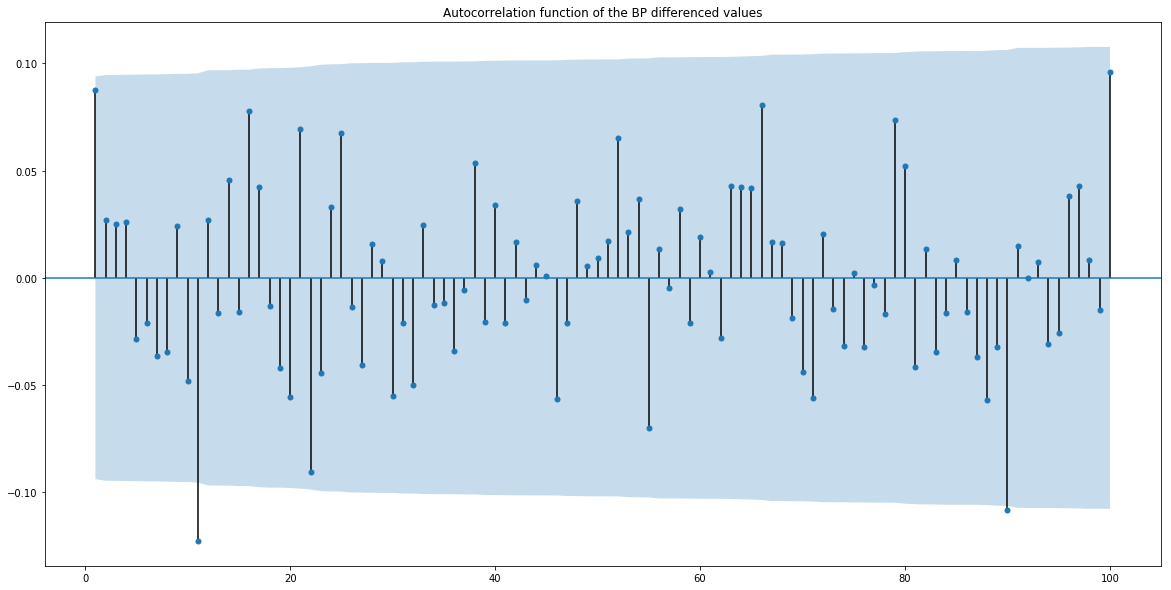

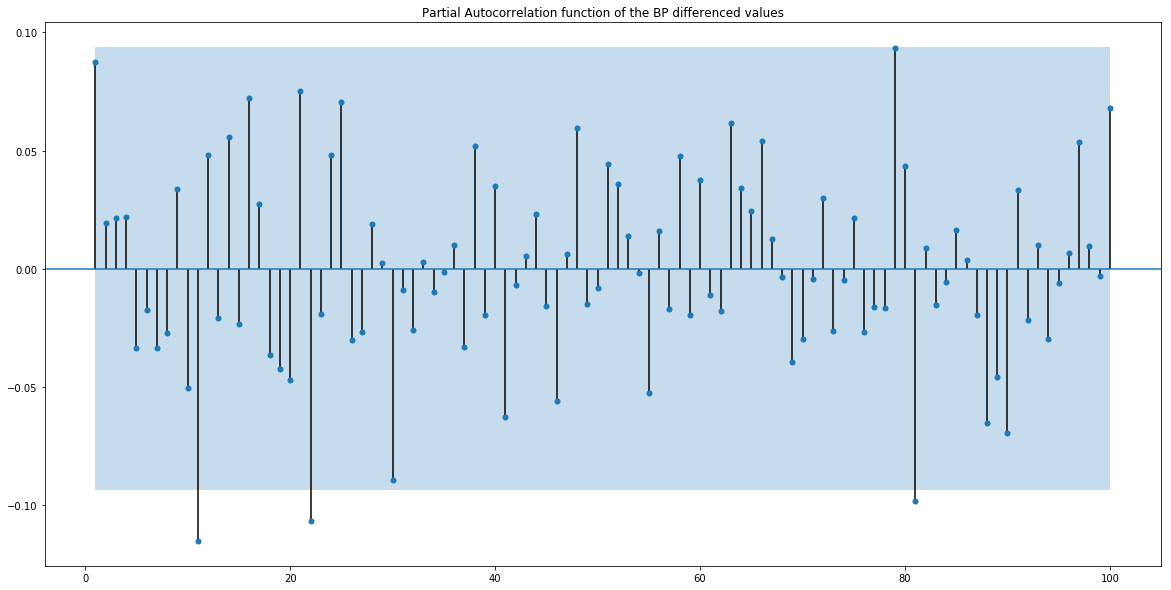

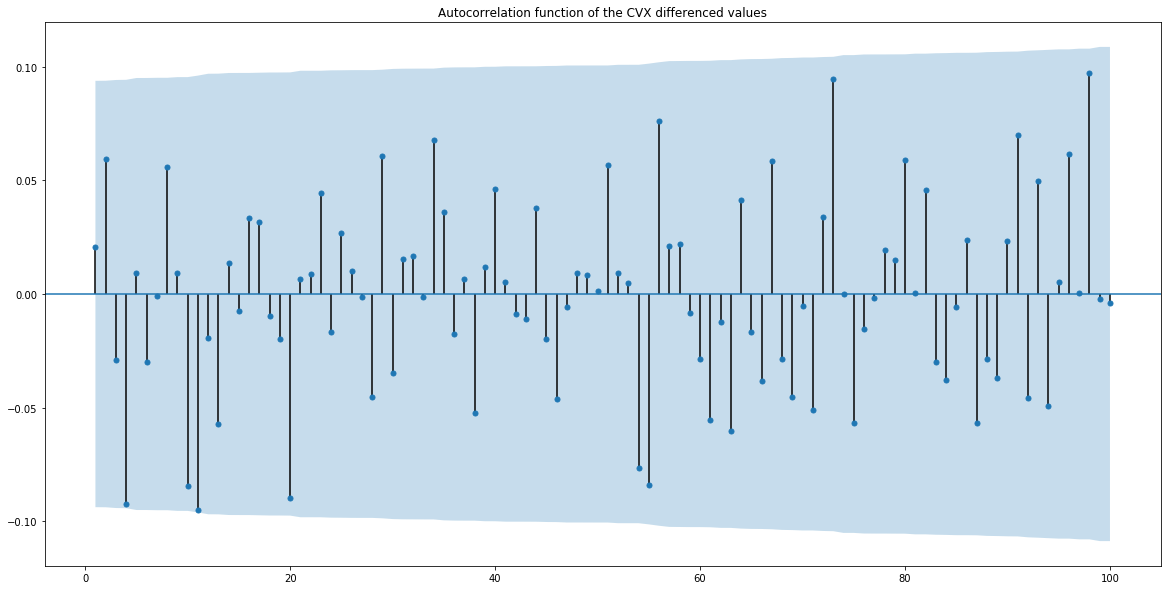

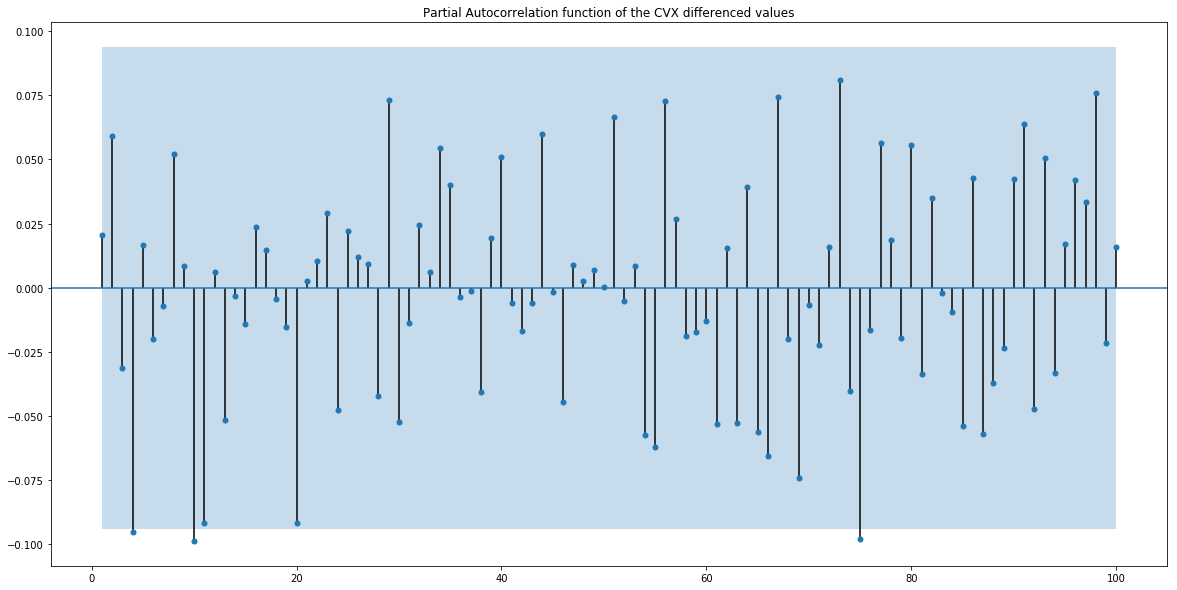

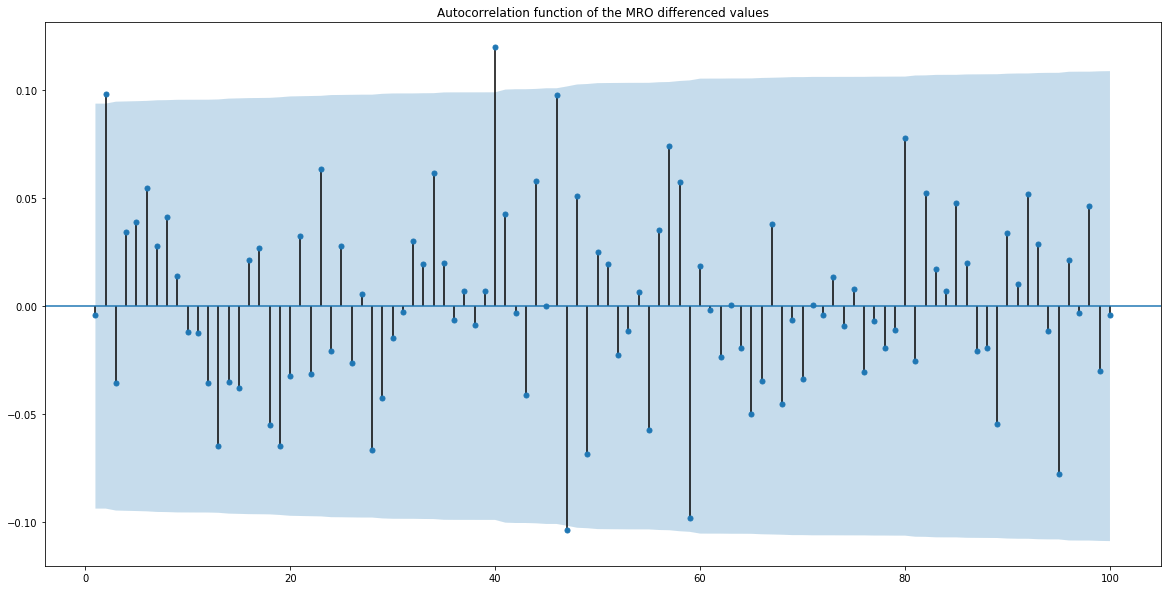

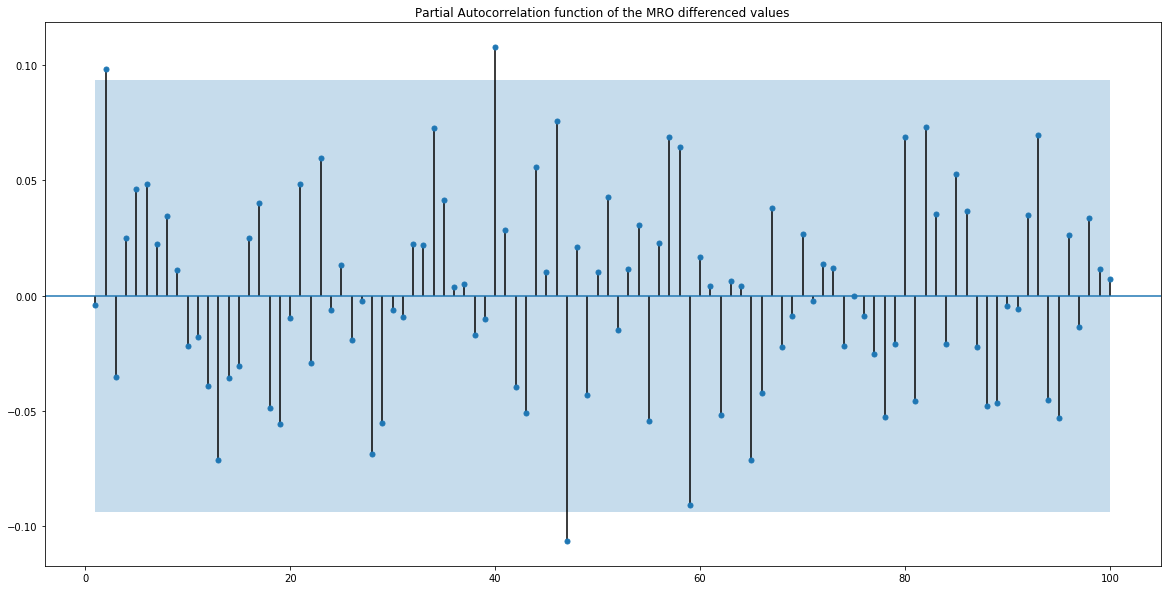

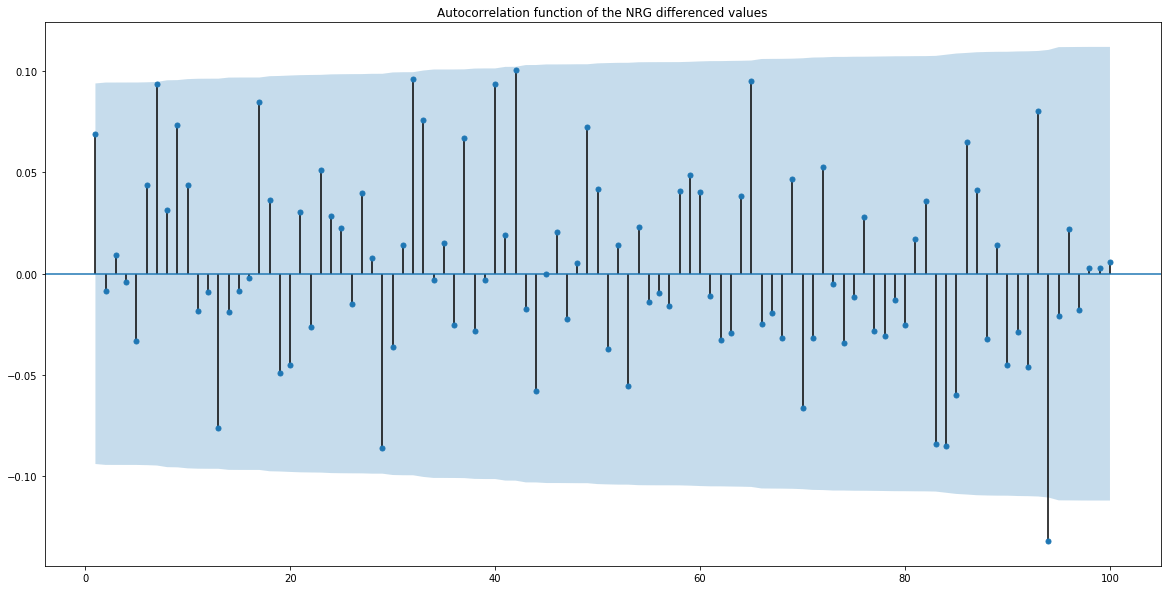

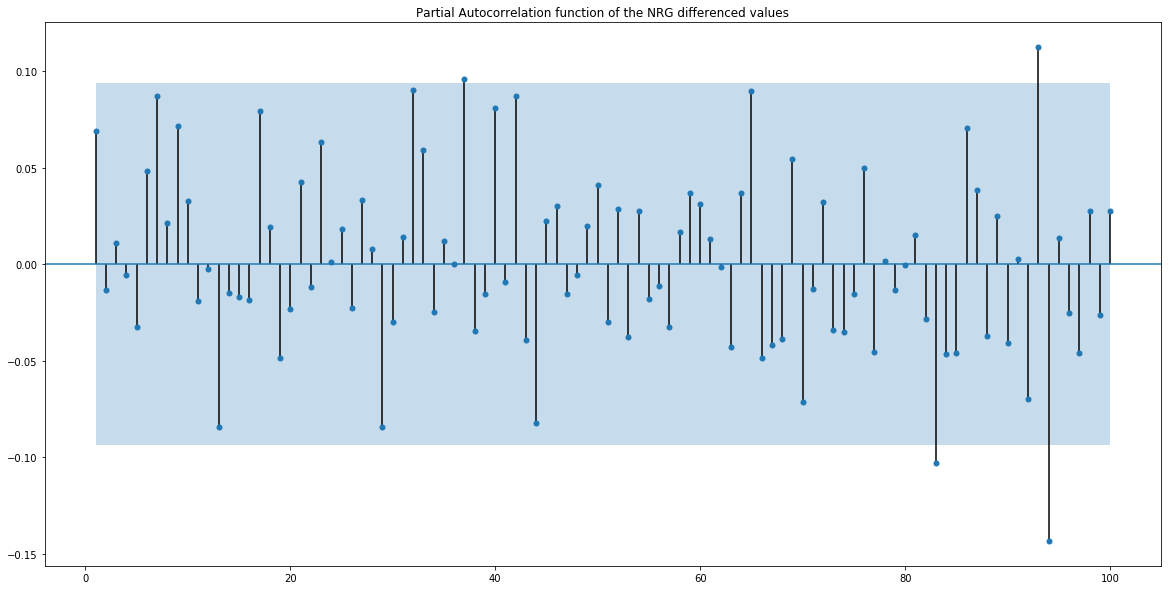

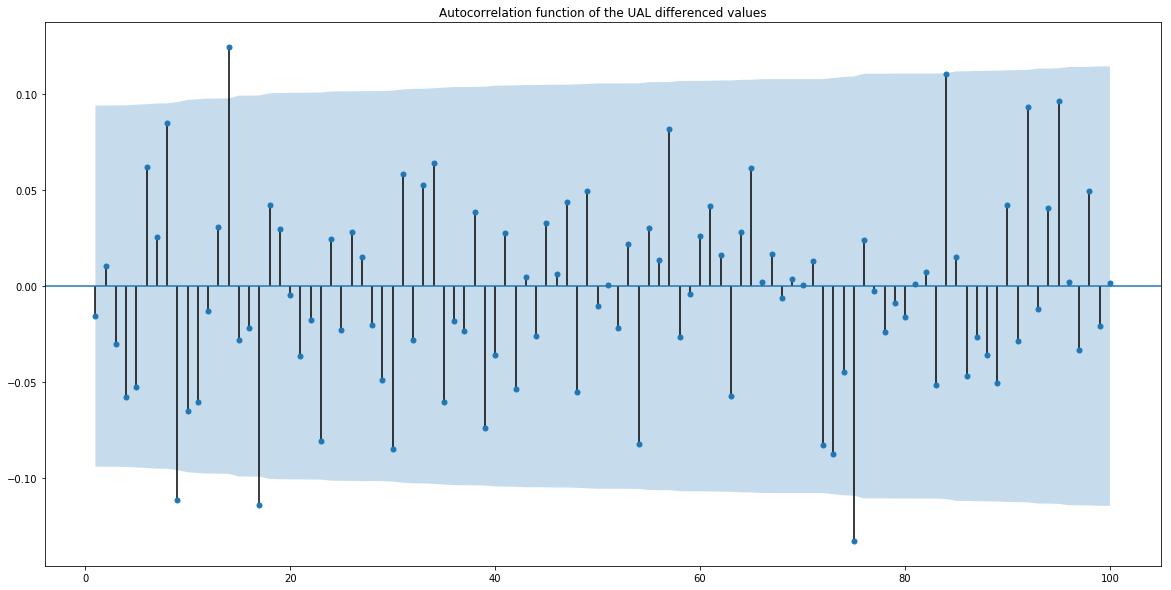

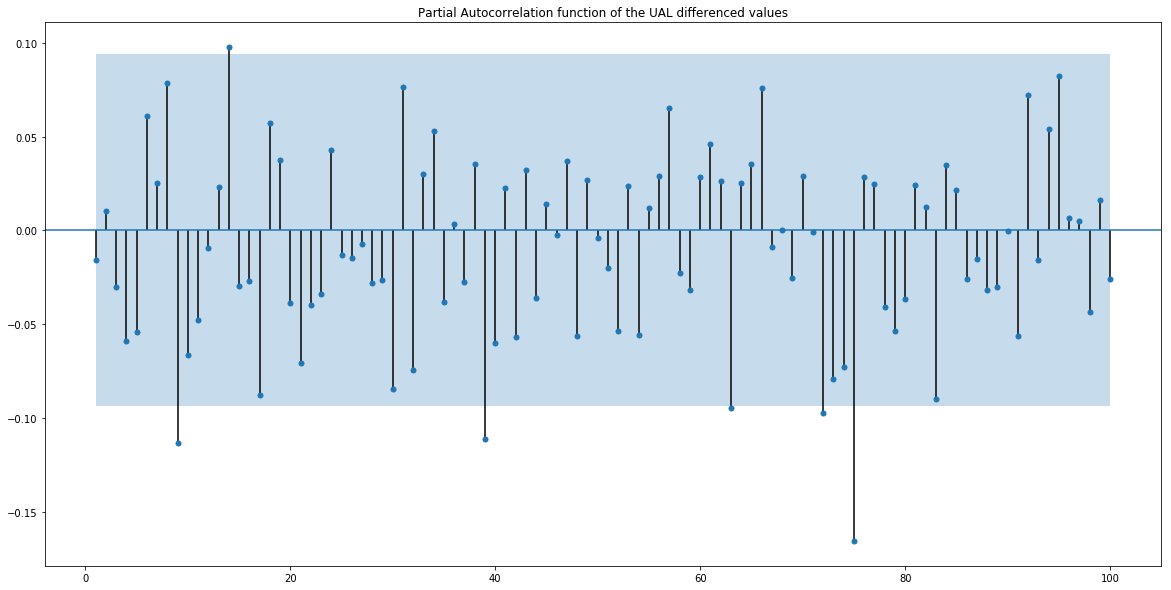

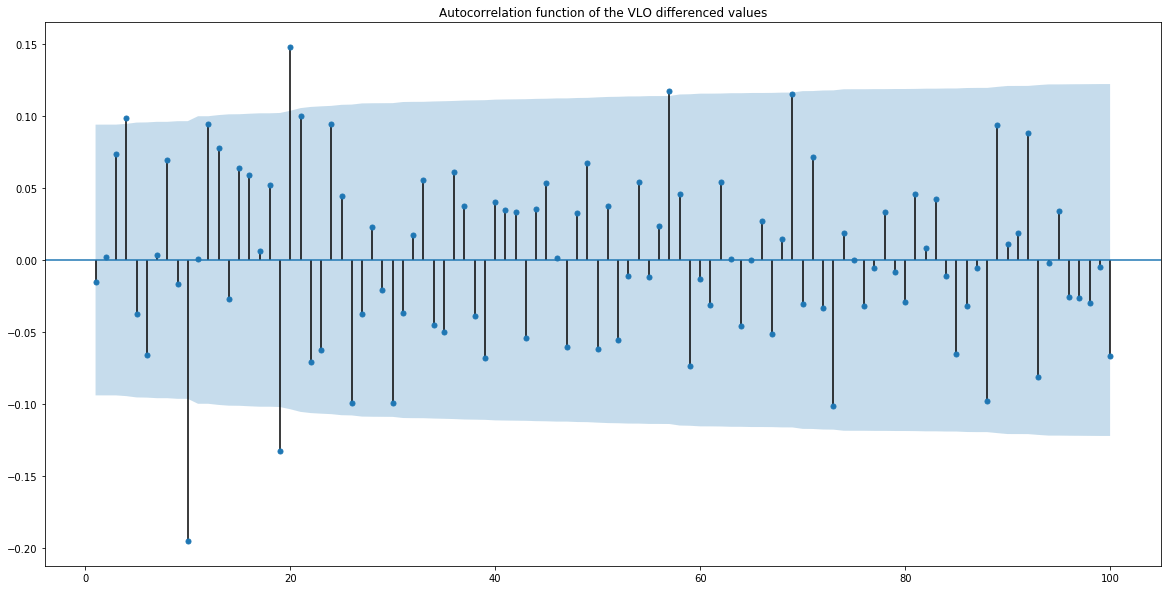

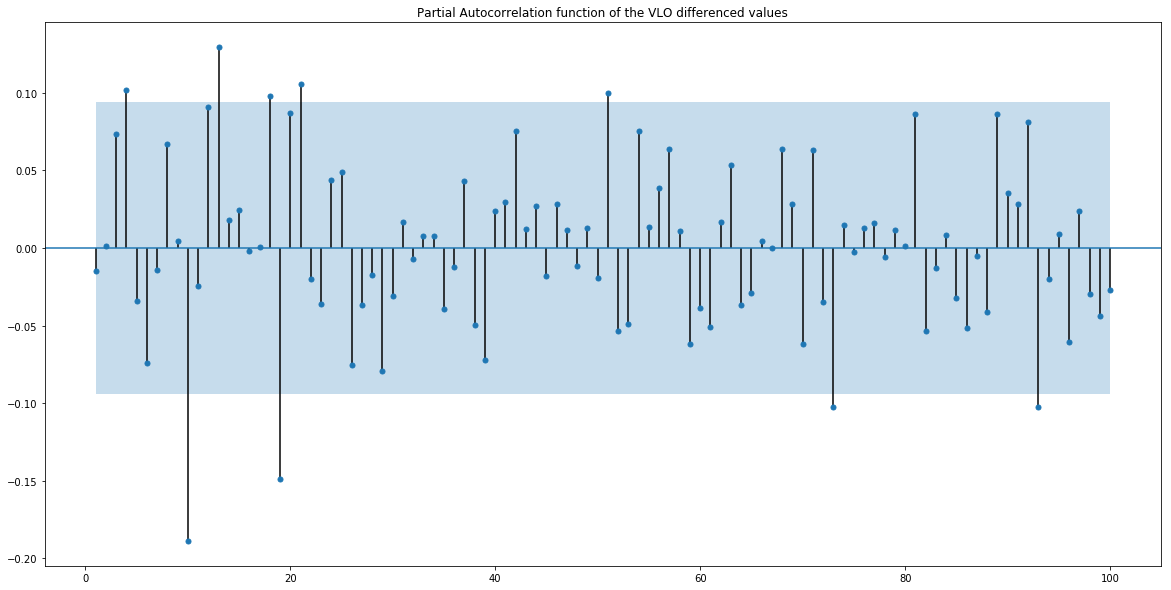

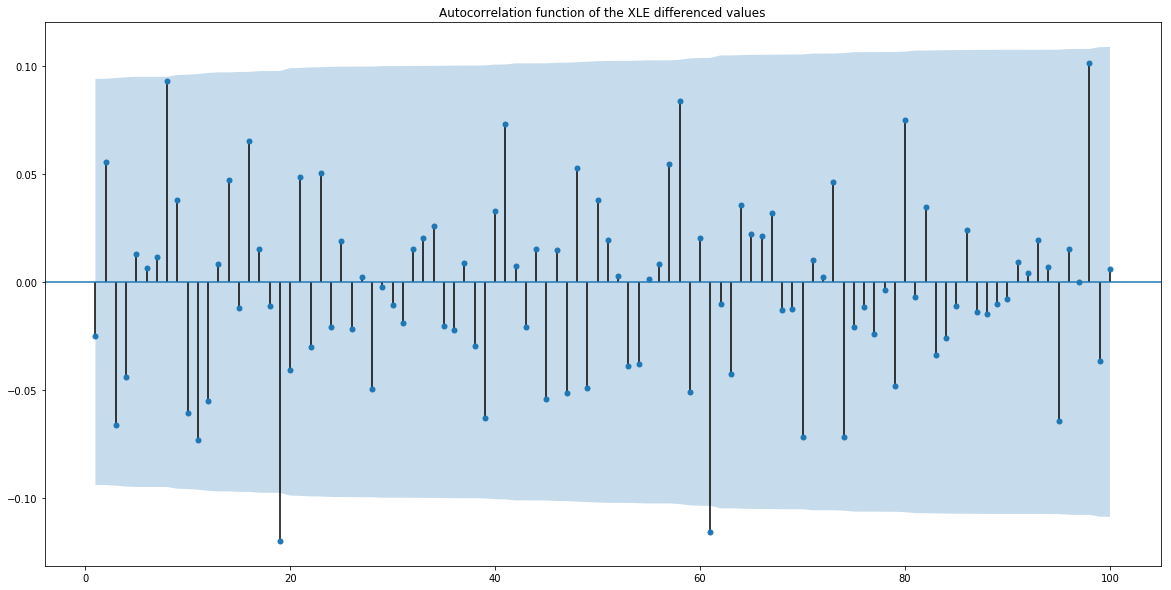

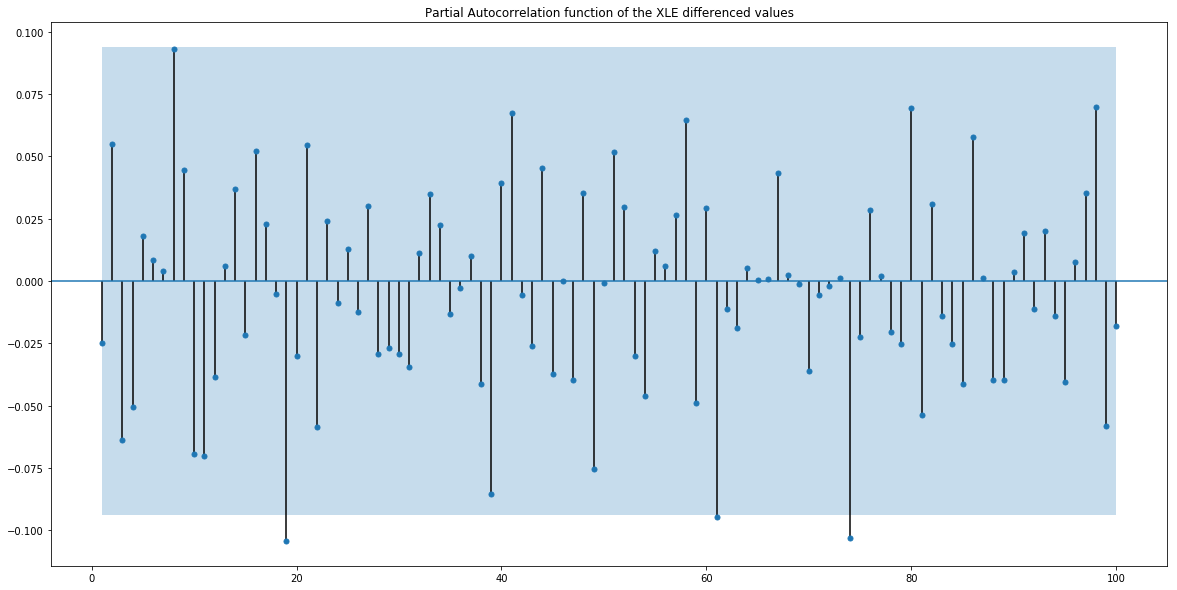

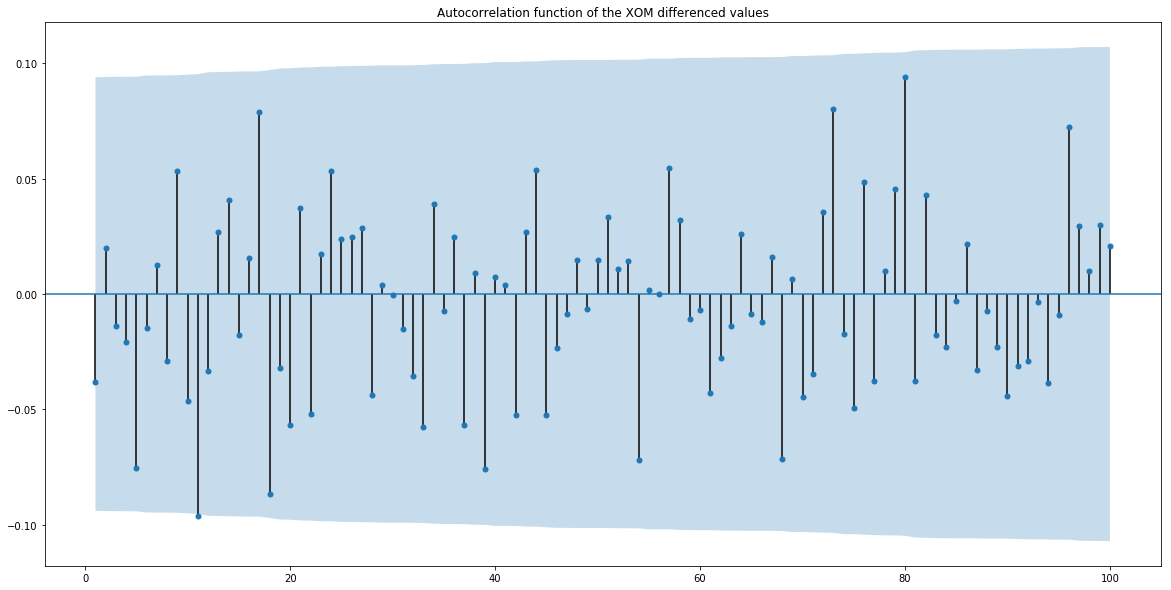

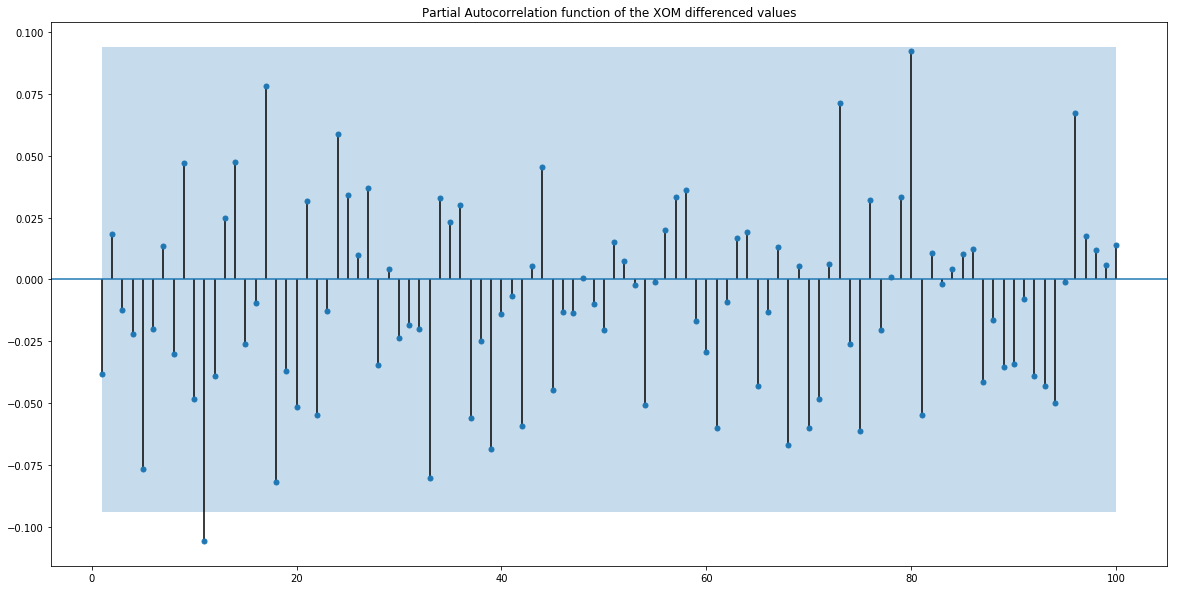

In [5]:
#Use the differenced stock series as a stationary series for the ARMA modeling
stocks_diff = stocks.diff().iloc[1:]

#Autocorrelation functions
for stock in stocks.columns:
    _ = plot_acf(stocks_diff[stock], lags=100, alpha=0.05, zero=False,
            title="Autocorrelation function of the {} differenced values". format(stock))
    _ = plot_pacf(stocks_diff[stock], lags=100, alpha=0.05, zero=False,
            title="Partial Autocorrelation function of the {} differenced values". format(stock))
plt.show()

In [ ]:
#Plot the BIC values for different orders of an ARMA model
for stock in stocks.columns:
    print("Evolution of Bayesian Information Criteria for {}".format(stock))
    plot_BIC(stocks_diff[stock], A=range(20), M=[0])

To go faster for this exercise, I simplify the order estimation process to reduce the computing time and have results faster, rather than testing a range of values for each stock series.

Evolution of Bayesian Information Criteria for BP
Order (10, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


Order (11, 0)
Order (12, 0)
Order (10, 1)
Order (11, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (12, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


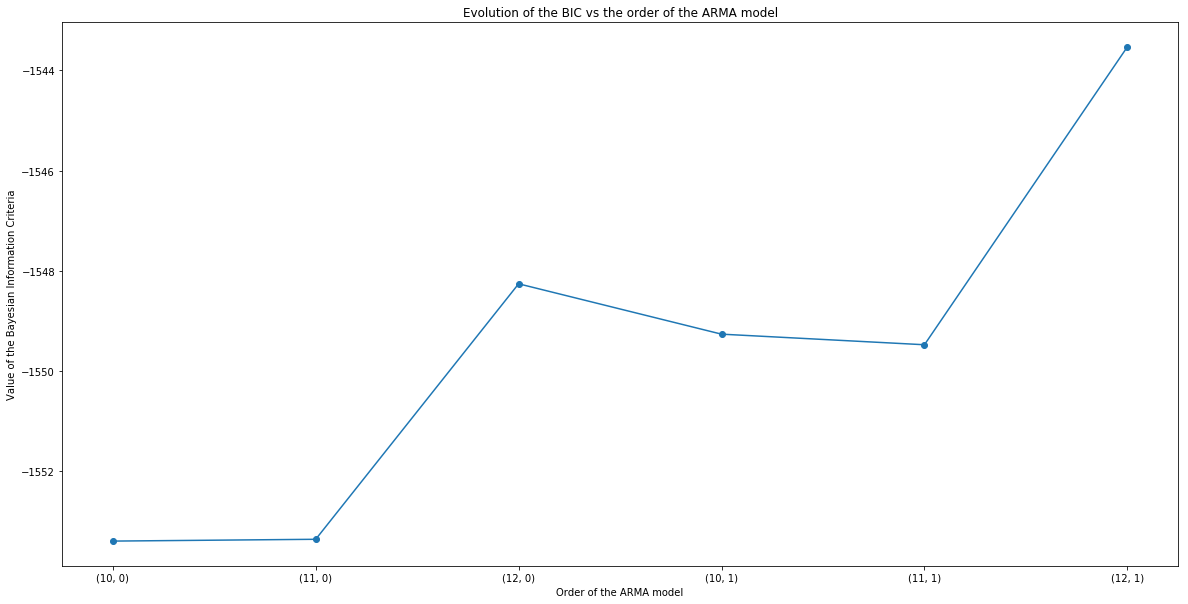

Lowest BIC obtained for order (10, 0)
Evolution of Bayesian Information Criteria for CVX
Order (4, 0)
Order (5, 0)
Order (6, 0)
Order (7, 0)
Order (8, 0)
Order (9, 0)
Order (10, 0)
Order (11, 0)
Order (4, 1)
Order (5, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (6, 1)
Order (7, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (8, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (9, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (10, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (11, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


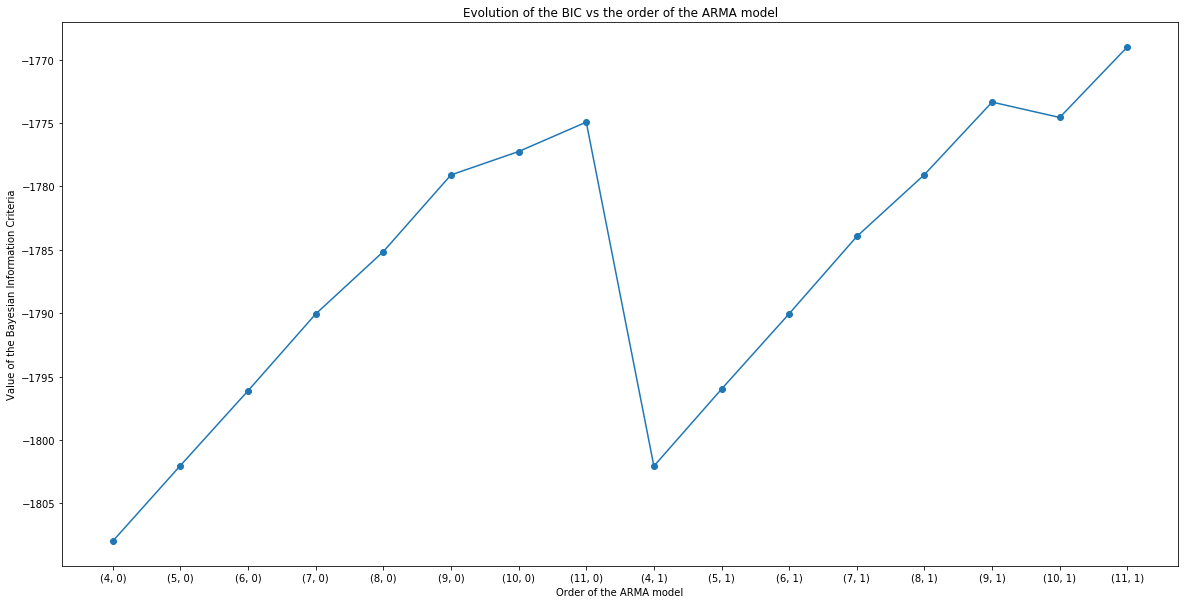

Lowest BIC obtained for order (4, 0)
Evolution of Bayesian Information Criteria for MRO
Order (0, 0)
Order (1, 0)
Order (2, 0)
Order (3, 0)
Order (0, 1)
Order (1, 1)
Algorithm could not converge for order (1, 1)
Order (2, 1)
Order (3, 1)


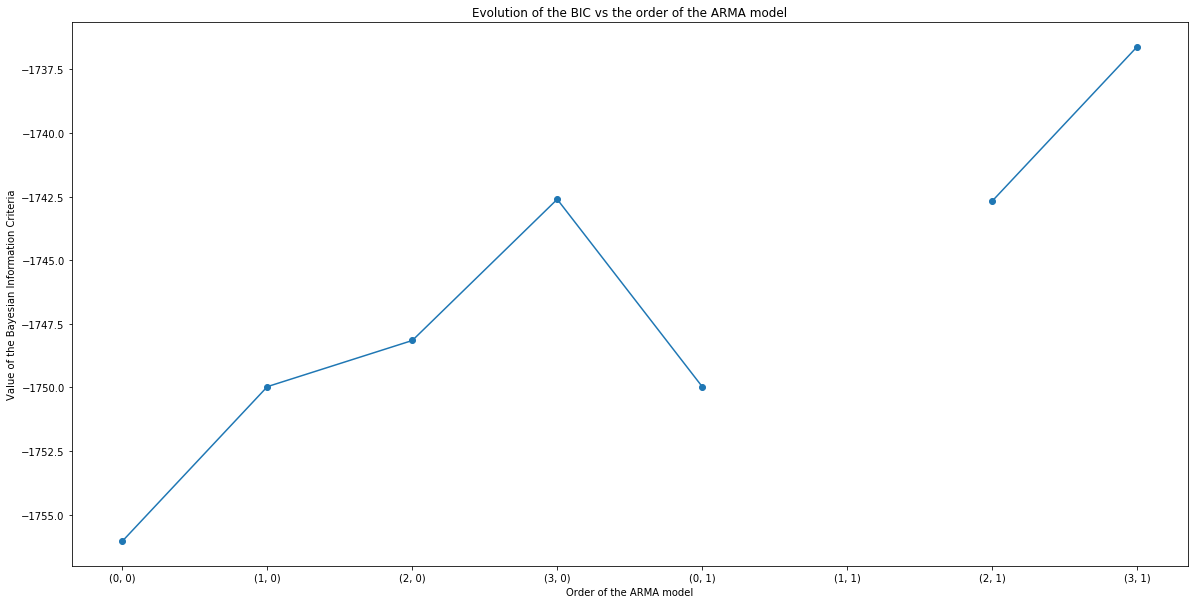

Lowest BIC obtained for order (1, 1)
Evolution of Bayesian Information Criteria for UAL
Order (8, 0)
Order (9, 0)
Order (10, 0)
Order (11, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (12, 0)
Order (13, 0)
Order (14, 0)
Order (15, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (8, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (9, 1)
Order (10, 1)
Order (11, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (12, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (13, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (14, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (15, 1)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


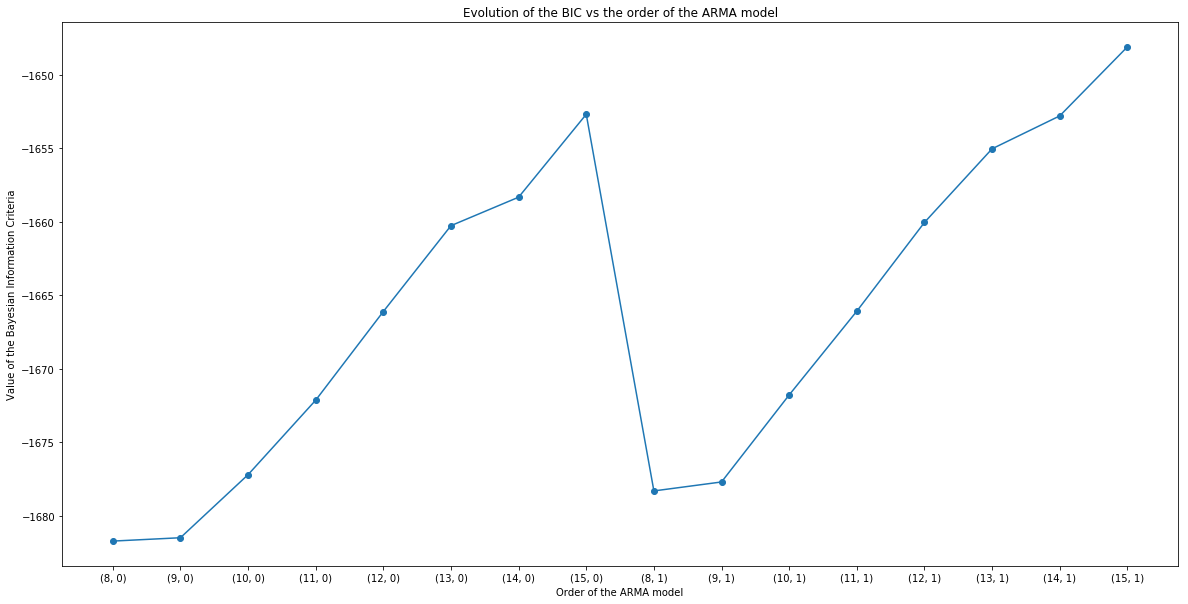

Lowest BIC obtained for order (8, 0)
Evolution of Bayesian Information Criteria for VLO
Order (8, 0)
Order (9, 0)
Order (10, 0)
Order (11, 0)
Order (12, 0)
Order (13, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (14, 0)
Order (15, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (16, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (17, 0)


C:\Users\Damien\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (18, 0)


In [ ]:
#BP: 11
print("Evolution of Bayesian Information Criteria for BP")
plot_BIC(stocks_diff['BP'], A=[10,11,12], M=[0,1])

#CVX: 4 & 10
print("Evolution of Bayesian Information Criteria for CVX")
plot_BIC(stocks_diff['CVX'], A=range(4,12), M=[0,1])
         
#MRO: 2
print("Evolution of Bayesian Information Criteria for MRO")
plot_BIC(stocks_diff['MRO'], A=range(4), M=[0,1])

#NRG: 94 & 95  -> too long to compute on my computer

#UAL: 9 & 14
print("Evolution of Bayesian Information Criteria for UAL")
plot_BIC(stocks_diff['UAL'], A=range(8, 16), M=[0,1])

#VLO: 9, 12, 18, 19
print("Evolution of Bayesian Information Criteria for VLO")
plot_BIC(stocks_diff['VLO'], A=range(8, 21), M=[0,1])

#XLE: 19
print("Evolution of Bayesian Information Criteria for XLE")
plot_BIC(stocks_diff['XLE'], A=range(18, 21), M=[0,1])

#XOM: 11
print("Evolution of Bayesian Information Criteria for XLE")
plot_BIC(stocks_diff['XLE'], A=range(10, 13), M=[0,1])

In [ ]:
#Forecast of a stock values predictions using ARIMA model
stock_model = ARIMA(stocks['CVX'], order=(4, 1, 0))
stock_results = model.fit()
print(stock_results.summary())

#Plot the prediction for the next periods
_ = stock_results.plot_predict(start='2018-01', end='2018-07')
plt.show()

##### Currencies

In [6]:
#Stationarity test (Augmented Dickey-Fuller) for the currencies
for curr in currencies.columns:
    adf_test(currencies[curr], curr, ret=False)



p-value for BGN timeseries:  0.7325599125479
ADF statistics: -1.0553127180189386
Critical Value 1% :  -3.446845912589748
Critical Value 5% :  -2.8688110853002007
Critical Value 10% :  -2.5706432834592747

p-value for BGN diff timeseries:  2.549048692103431e-16
ADF statistics: -9.552540875989733
Critical Value 1% :  -3.446845912589748
Critical Value 5% :  -2.8688110853002007
Critical Value 10% :  -2.5706432834592747


p-value for BRL timeseries:  0.834770799805933
ADF statistics: -0.7449124613273913
Critical Value 1% :  -3.4468044036406247
Critical Value 5% :  -2.868792838125
Critical Value 10% :  -2.57063355625

p-value for BRL diff timeseries:  0.0
ADF statistics: -20.689078822515288
Critical Value 1% :  -3.446845912589748
Critical Value 5% :  -2.8688110853002007
Critical Value 10% :  -2.5706432834592747


p-value for CAD timeseries:  0.8005082636091518
ADF statistics: -0.8611143003907085
Critical Value 1% :  -3.4468044036406247
Critical Value 5% :  -2.868792838125
Critical Value 10

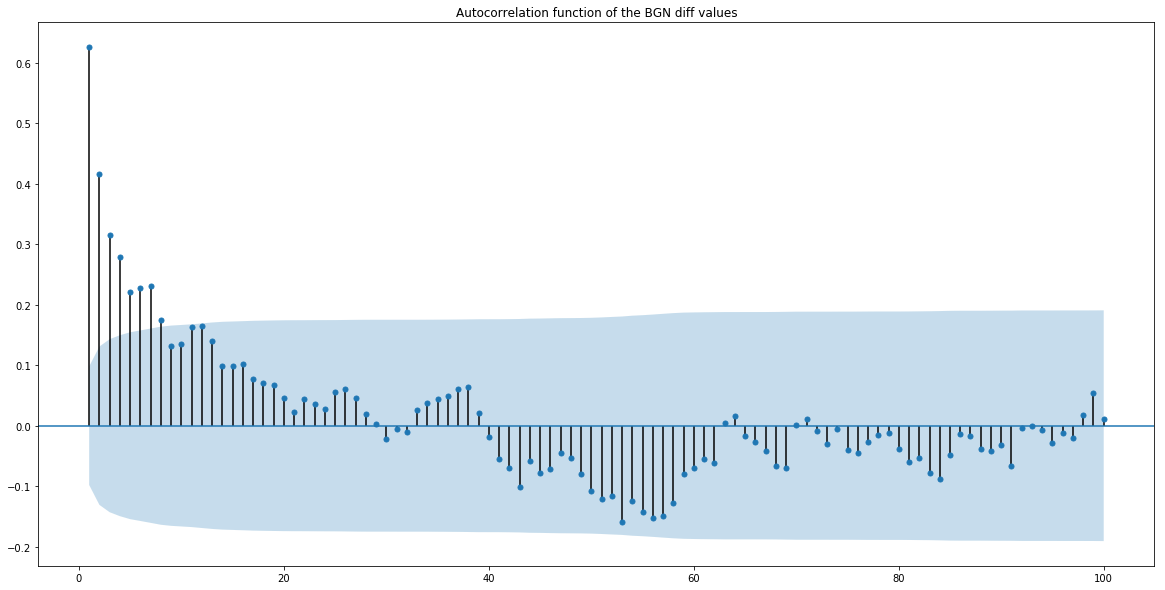

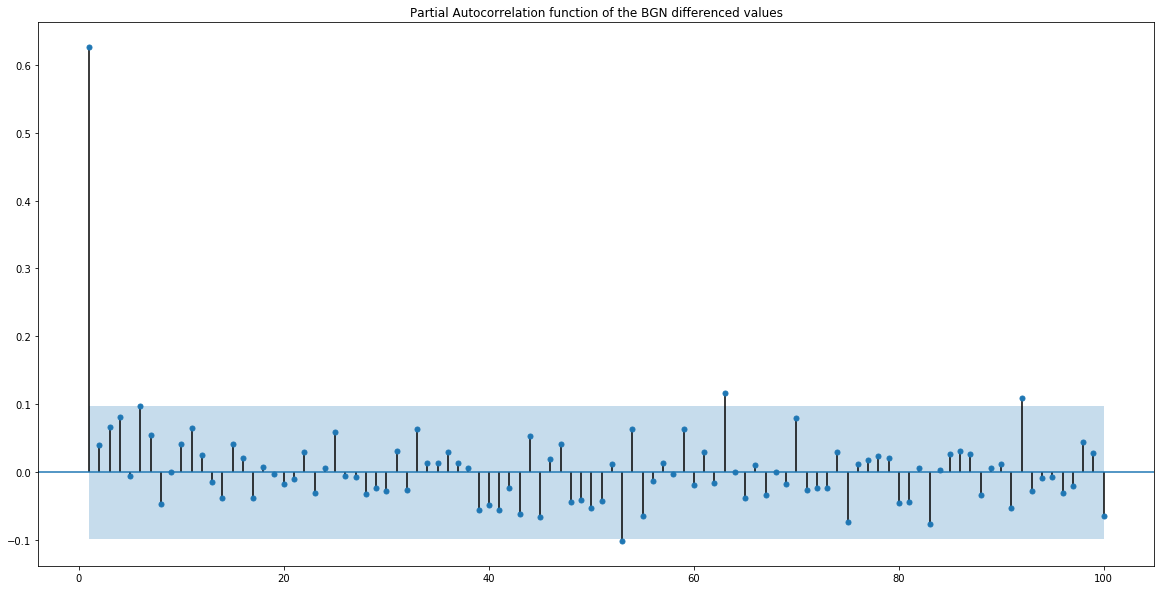

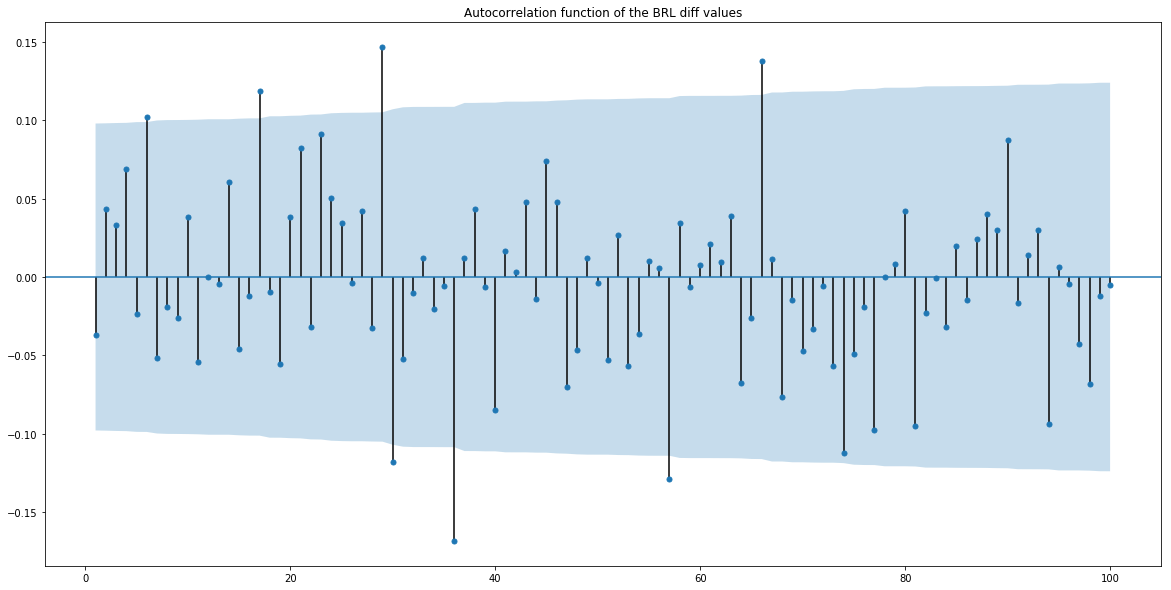

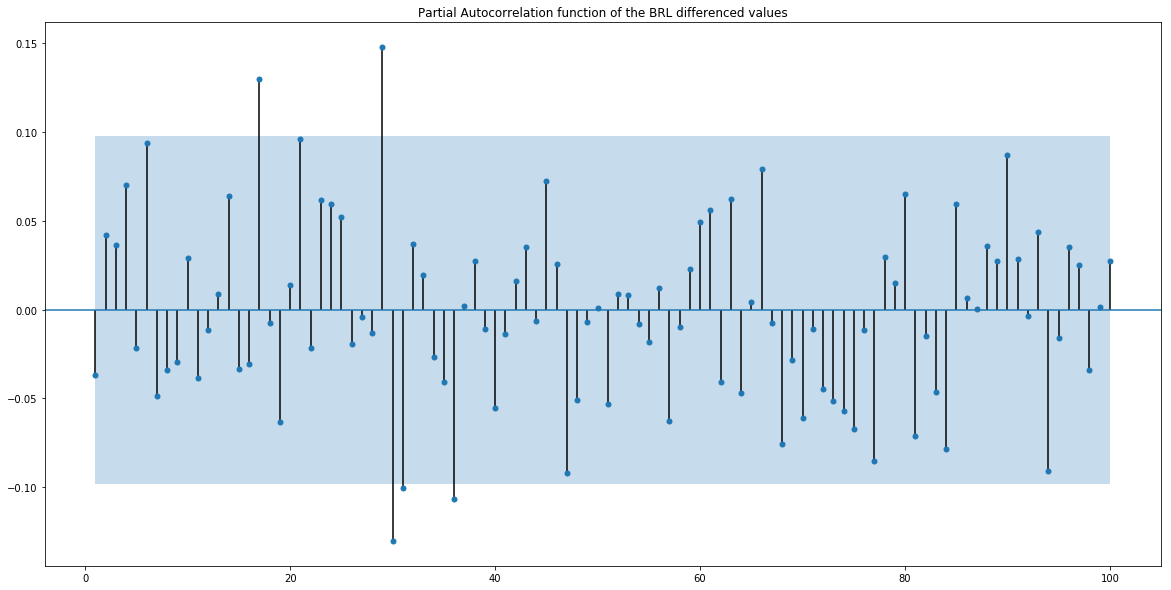

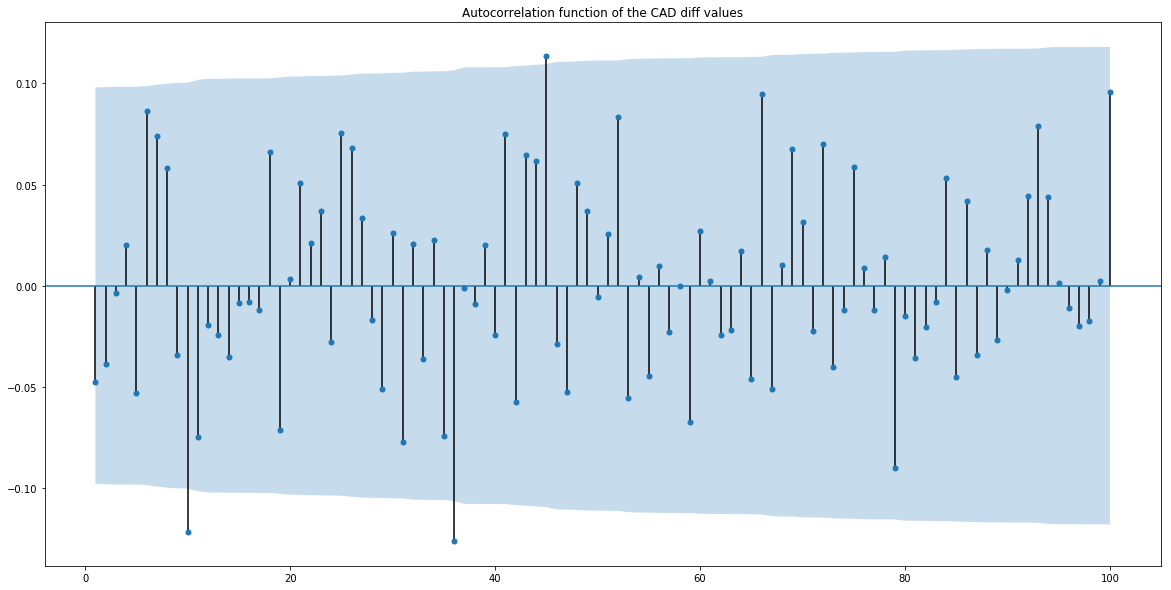

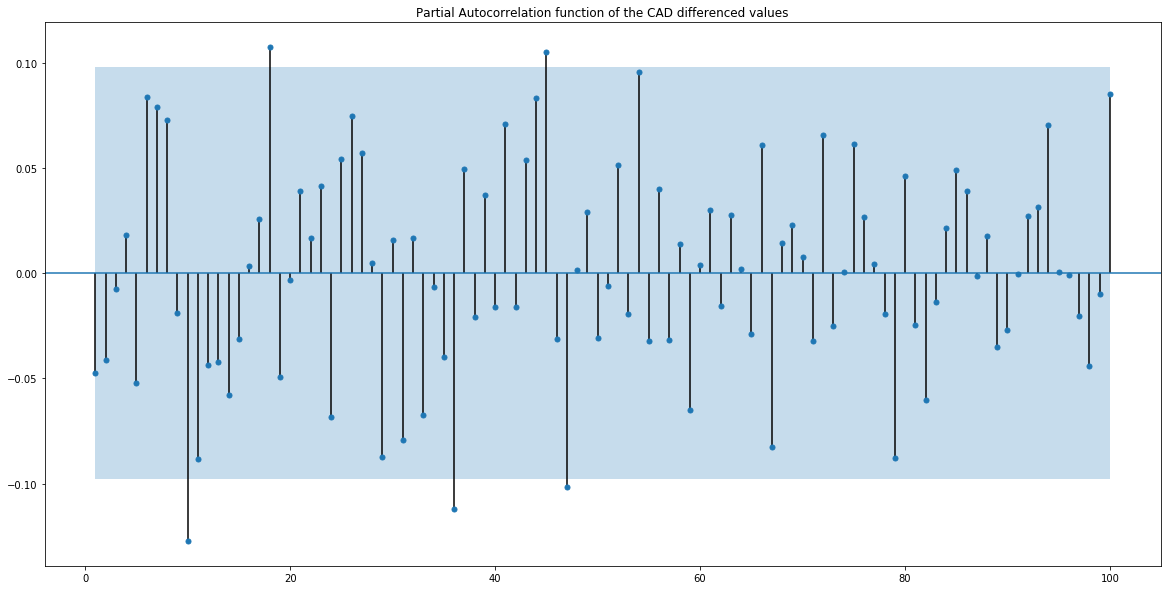

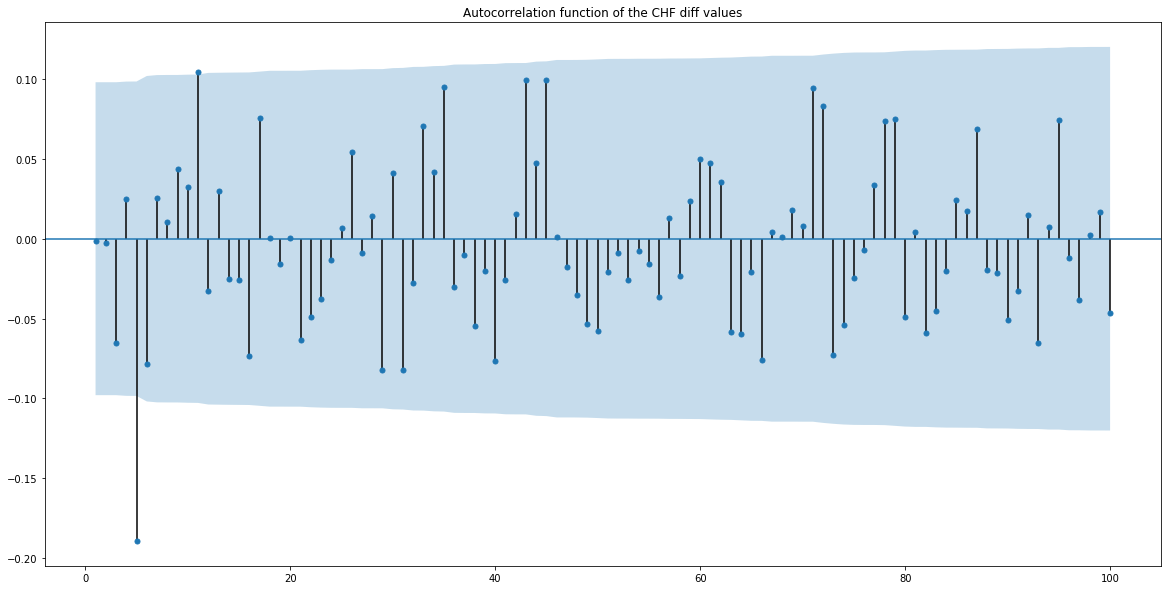

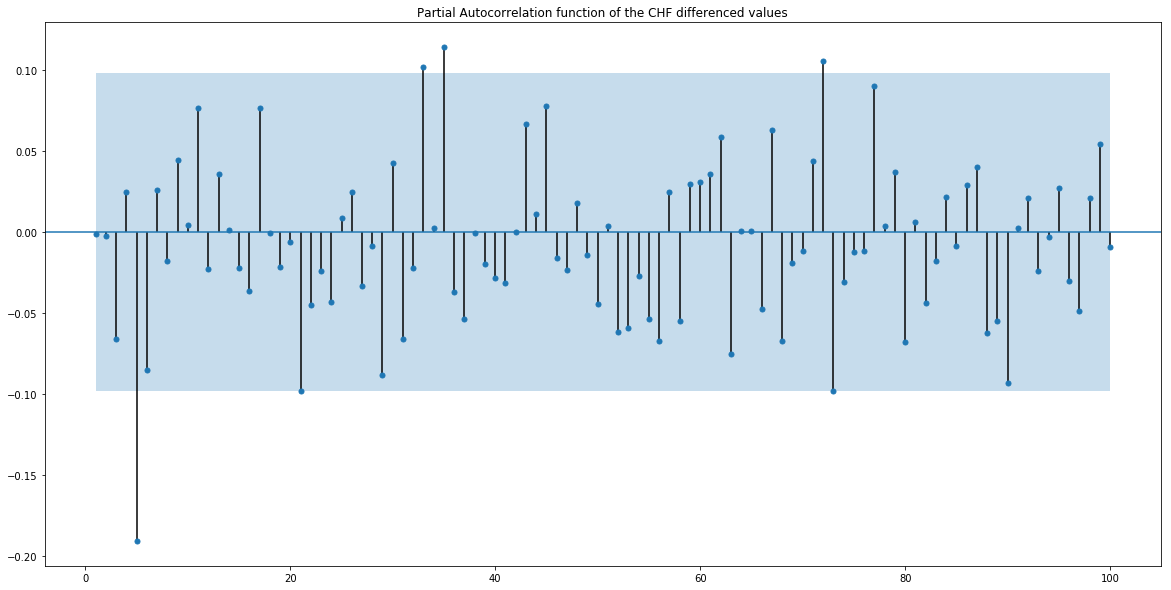

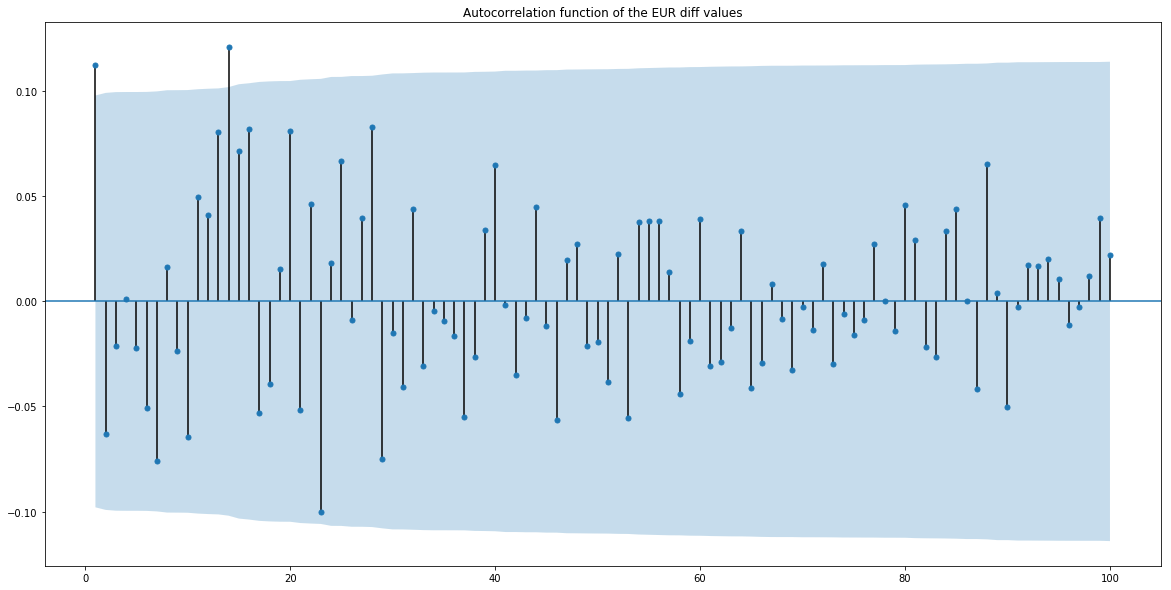

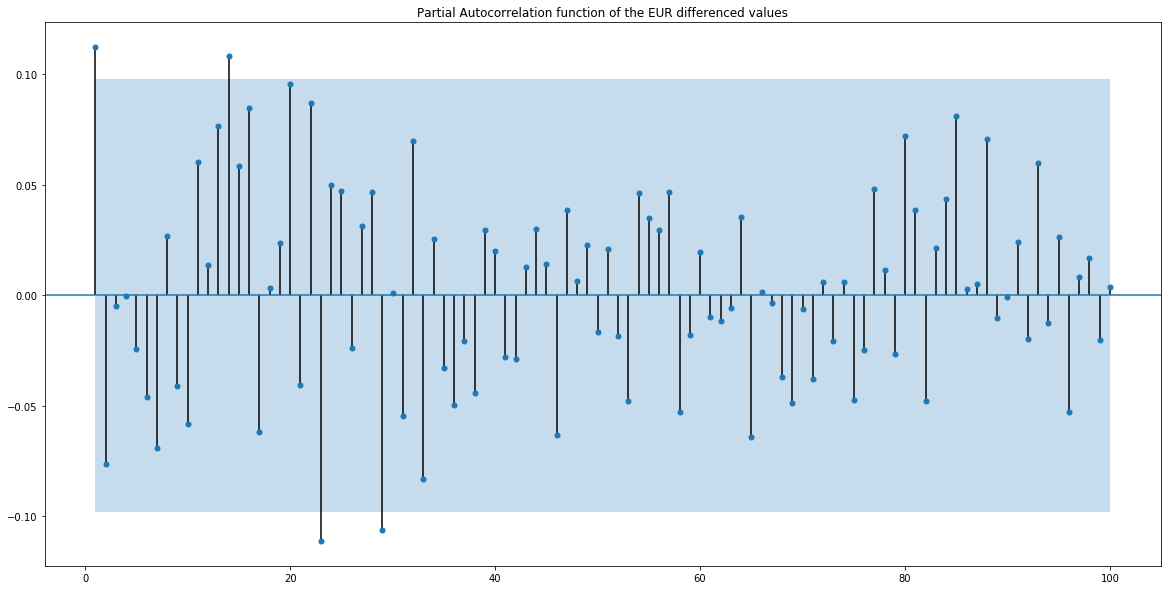

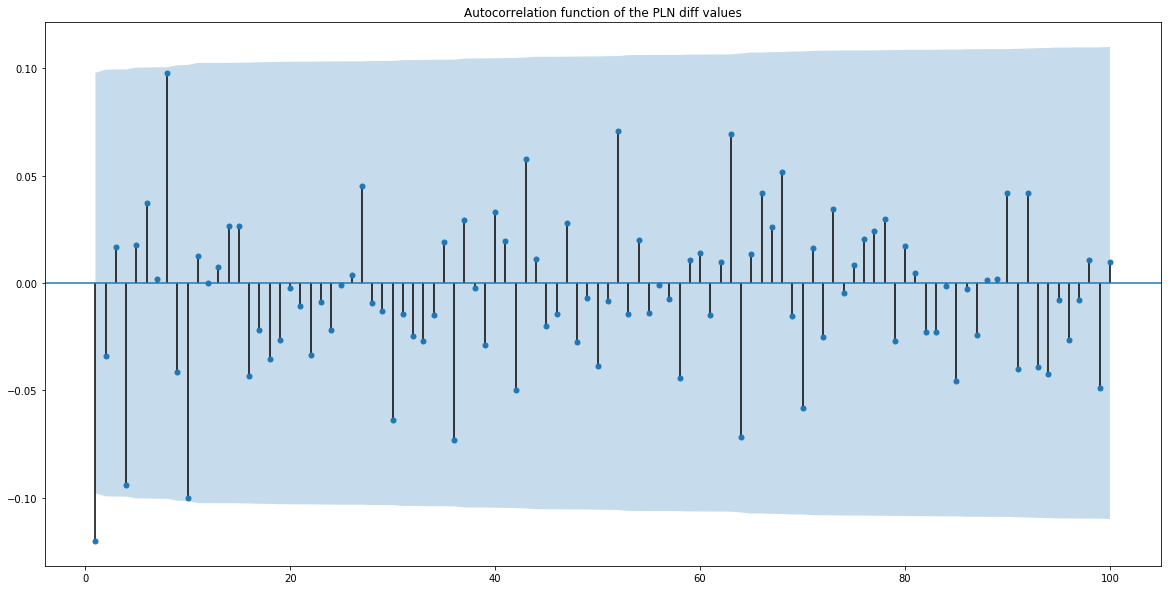

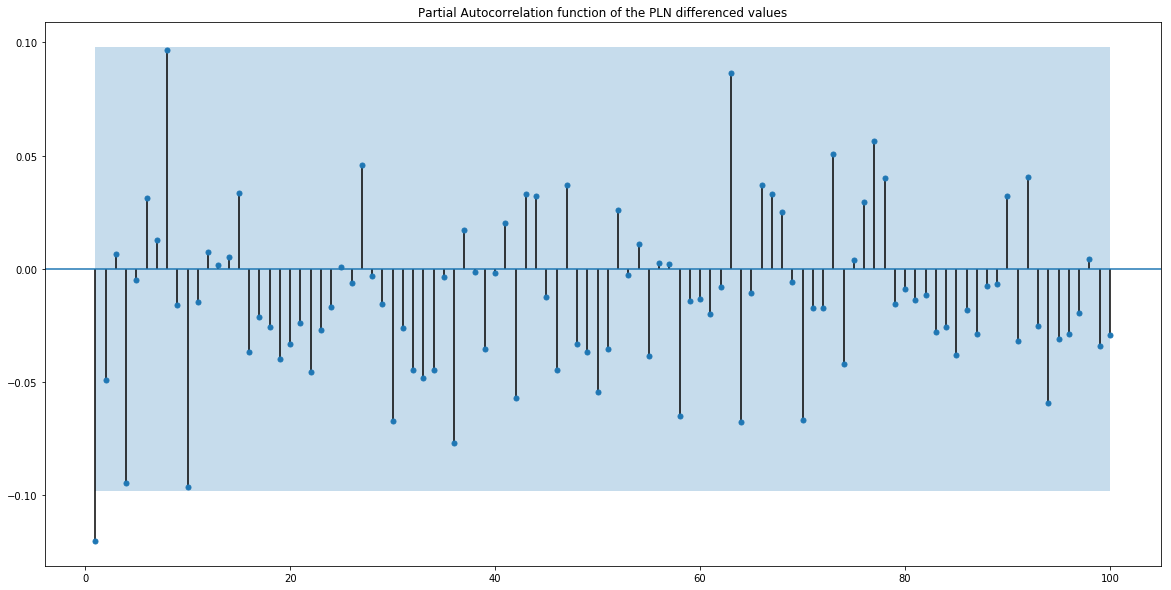

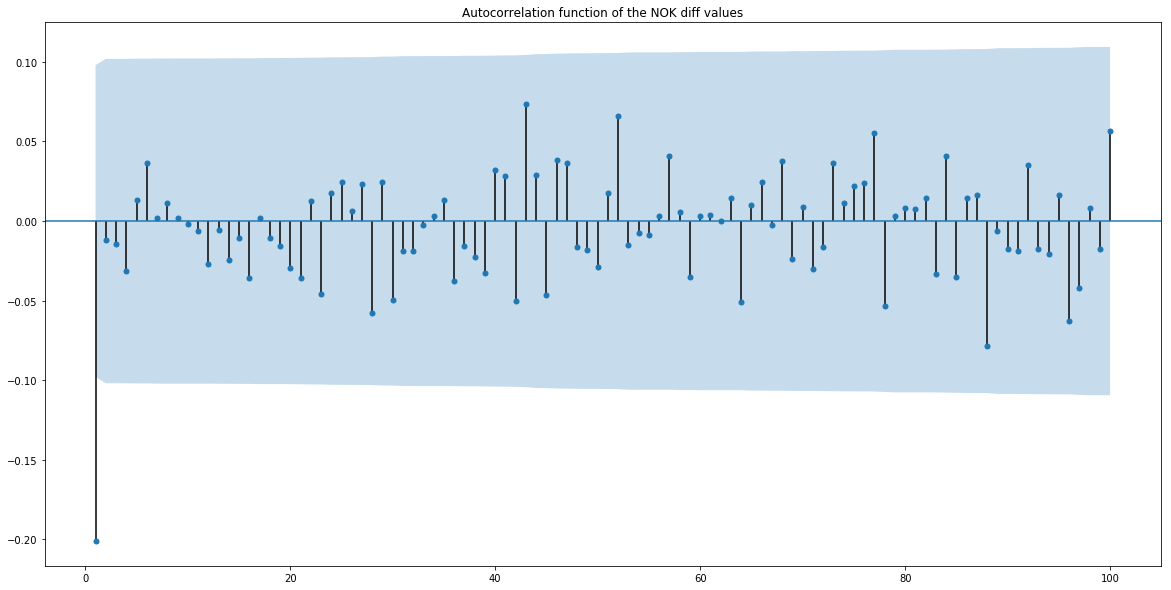

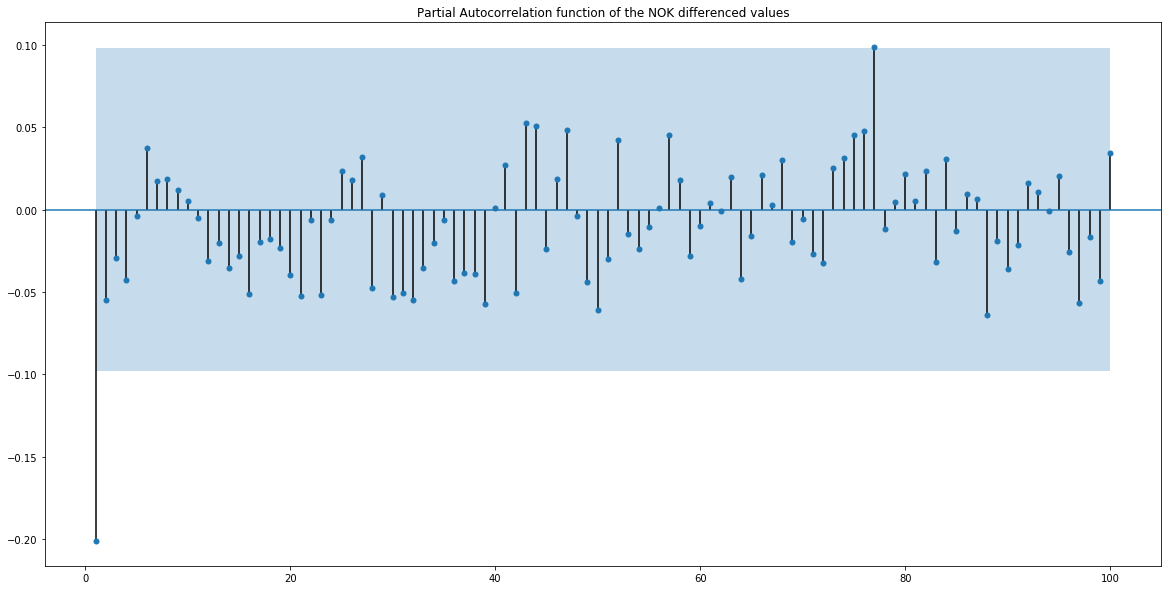

In [7]:
#Use the differenced currency series as a stationary series for the ARMA modeling
currencies_diff = currencies.diff().iloc[1:]

#Autocorrelation functions
for curr in currencies_diff.columns:
    _ = plot_acf(currencies_diff[curr], lags=100, alpha=0.05, zero=False,
            title="Autocorrelation function of the {} diff values". format(curr))
    _ = plot_pacf(currencies_diff[curr], lags=100, alpha=0.05, zero=False,
            title="Partial Autocorrelation function of the {} differenced values". format(curr))
plt.show()

In [ ]:
#Simplified BIC analysis for the currencies (limite computing capacity)

#BGN: 1
print("Evolution of Bayesian Information Criteria for BGN")
plot_BIC(currencies_diff['BGN'], A=range(0, 2), M=[0,1])

#BRL: 17, 29, 30
print("Evolution of Bayesian Information Criteria for BRL")
plot_BIC(currencies_diff['BRL'], A=range(16, 19), M=[0,1])

#CAD: 10, 18
print("Evolution of Bayesian Information Criteria for CAD")
plot_BIC(currencies_diff['CAD'], A=range(9, 20), M=[0,1])

#CHF: 5
print("Evolution of Bayesian Information Criteria for CHF")
plot_BIC(currencies_diff['CHF'], A=range(16, 19), M=[0,1])

#EUR: 1, 14
print("Evolution of Bayesian Information Criteria for EUR")
plot_BIC(currencies_diff['EUR'], A=range(0, 16), M=[0,1])

#PLN: 1
print("Evolution of Bayesian Information Criteria for PLN")
plot_BIC(currencies_diff['PLN'], A=range(0, 5), M=[0,1])

#NOK: 1
print("Evolution of Bayesian Information Criteria for NOK")
plot_BIC(currencies_diff['NOK'], A=range(0, 5), M=[0,1])

To go faster for this exercise, I simplify the order estimation process to reduce the computing time and have results faster, rather than testing a range of values for each stock series.

In [ ]:
#Plot the BIC values for different orders of an ARMA model
for curr in currencies_diff.columns:
    print("Evolution of Bayesian Information Criteria for {}".format(curr))
    plot_BIC(currencies_diff[curr], A=range(20), M=[0])

In [ ]:
#Forecast for a currencies value using an ARIMA model
currencie_model = ARIMA(currencies['EUR'], order=(14, 1, 0))
currencie_results = model.fit()
print(currencie_results.summary())

#Plot the prediction for the next periods
_ = currencie_results.plot_predict(start='2017-01', end='2018-02')
plt.show()

### Cointegration  <a class="anchor" id="second-forth-bullet"></a>
Is the linear combination of 2 random walks (stocks or currencies) not a random walk ? If yes, they are cointegrated and their linear combination is forecastable

In [ ]:
#Re-Load the csv files
stocks = pd.read_csv('stocks_cleaned_scaled.csv', index_col=[0], parse_dates=[0])
currencies = pd.read_csv('currencies_cleaned_scaled.csv', index_col=[0], parse_dates=[0])
print(stocks.head())
print(currencies.head())

#Plot the series
_ = stocks.plot()
plt.show()

_ = currencies.plot()
plt.show()

In [ ]:
#Test the null hypothesis that 2 stocks are NOT cointegrated and check the p-value
score, pvalue, _ = coint(stocks['XLE'], stocks['XOM'], autolag='BIC')
print('Score of the test: {}\n'.format(score), 'p-value of the test: {}'.format(pvalue))

In [ ]:
#Test the null hypothesis that 2 currencies are NOT cointegrated and check the p-value
score, pvalue, _ = coint(currencies['CAD'], currencies['BRL'], autolag='BIC')
print('Score of the test: {}\n'.format(score), 'p-value of the test: {}'.format(pvalue))